# Check time format and do imputation accordingly

In [3]:
import os
import pandas as pd
import numpy as np
lines = open("Hoppe_without.csv",'r').read().split('\n')
del lines[-1]
del lines[0]

In [4]:
lines[1]

'779878,11/28/14 10:58,124,75,11/28/2014  12:28:00 PM,94,58,11/28/2014  12:43:00 PM,99,61,11/28/2014  1:06:00 PM,110,60,11/28/2014  1:18:00 PM,116,62,11/28/2014  1:50:00 PM,128,73,11/28/2014  2:59:00 PM,124,67,11/28/2014  5:08:00 PM,116,76,11/28/2014  7:54:00 AM,119,62,11/28/2014  8:38:00 PM,123,72,11/29/2014  12:53:00 AM,120,68,11/29/2014  4:45:00 AM,117,66,11/29/2014  5:22:00 PM,109,58,11/29/2014  7:40:00 AM,136,70,11/30/2014  3:02:00 AM,125,58,11/30/2014  3:37:00 PM,113,64,11/30/2014  8:11:00 AM,136,65,12/1/2014  12:20:00 AM'

# Data cleaning: find labor time, delivery date and BP information at certain time period for each patient

In [5]:
MRN = []
delivery_time = []
bp_high = []
bp_low = []
labor_time = []

for line in lines:
    Lis = line.split(",")
    n = len(Lis)
    Lis[1]=pd.to_datetime(Lis[1]).strftime('%y-%m-%d %H:%M')
    for i in range(int((n-2)/3)):
        Lis[4+i*3]=pd.to_datetime(Lis[4+i*3]).strftime('%y-%m-%d %H:%M')
        if Lis[1]> Lis[4+i*3]:
            MRN.append(Lis[0])
            delivery_time.append(Lis[1])
            bp_high.append(Lis[2+i*3])
            bp_low.append(Lis[3+i*3])
            labor_time.append(Lis[4+i*3])
        
df = pd.DataFrame({'MRN': MRN,
                   'delivery_time': delivery_time,
                   'bp_high': bp_high,
                   'bp_low': bp_low,
                   'labor_time':labor_time
                  })

In [ ]:
df.loc[df['MRN'] == '268293']

In [7]:
a=df['delivery_time']
b=a.values.tolist()
delivery_date=[]
for x in b:
    #delivery_date.append(pd.to_datetime(x).strftime('%y-%m-%d'))
    delivery_date.append(pd.to_datetime(x, yearfirst = True).strftime('%y-%m-%d'))

In [8]:
df['delivery_date']=delivery_date

In [ ]:
df.tail(5)

In [ ]:
df.isnull().sum()

In [11]:
df_date = df.drop(['delivery_time'], axis=1)
df_date = df_date.drop_duplicates()

In [12]:
df_date['bp_high'] = [int(i) for i in df_date['bp_high']] 

In [13]:
df_date.sort_values(['MRN','delivery_date','bp_high'],ascending=[1,1,0],inplace=True)
grouped = df_date.groupby(['MRN','delivery_date']).head(3)

In [ ]:
grouped.loc[df['MRN'] == '268293']

In [ ]:
grouped.loc[df['MRN'] == '799976']

In [ ]:
grouped1 = df_date.groupby(['MRN','delivery_date']).head(1)
grouped1.loc[df['MRN'] == '268293']

In [17]:
grouped.columns = ["mother's_mrn", 'bp_high', 'bp_low', 'labor_time', 'date of_birth']

In [18]:
grouped1.columns = ["mother's_mrn", 'bp_high', 'bp_low', 'labor_time', 'date of_birth']

# Merge feature information from other datasets

In [21]:
HP = pd.ExcelFile('Hoppe_HTN_Data_9.2020.xlsx')
df1 = pd.read_excel(HP, 'Old Data')
df1['date of_birth']=df1['date of_birth'].apply(lambda x: x.strftime('%y-%m-%d'))

In [ ]:
grouped.head()

In [ ]:
pd.to_datetime(grouped['date of_birth'], yearfirst = True)

In [ ]:
df1['date of_birth'] = pd.to_datetime(df1['date of_birth'], yearfirst = True)
grouped['date of_birth'] = pd.to_datetime(grouped['date of_birth'], yearfirst = True)

In [ ]:
grouped1['date of_birth'] = pd.to_datetime(grouped1['date of_birth'], yearfirst = True)

In [ ]:
grouped1["mother's_mrn"] = grouped1["mother's_mrn"].astype(str).astype(int)
olddff = pd.merge(df1, grouped1, on=["mother's_mrn",'date of_birth'])

In [27]:
olddff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22395 entries, 0 to 22394
Columns: 550 entries, mother's_mrn to labor_time
dtypes: datetime64[ns](138), float64(284), int64(31), object(97)
memory usage: 94.1+ MB


In [28]:
olddff.head()

,mother's_mrn,mother's_dob,maternal_age,date of_admission,time of_admission,date of_birth,time of_birth,discharge_date,Postpartum days,Total Days of Admission,...,route_std_25,strt_tm_26,med_nm_26,dose_26,quantity_26,unit_26,route_std_26,bp_high,bp_low,labor_time
0,753717,1988-06-17,21.0,2009-01-01,645,2009-01-01,1500,2009-01-03,2.0,2.0,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,109,61,09-01-01 07:07
1,773792,1993-05-18,16.0,2009-01-01,1027,2009-01-01,1412,2009-01-03,2.0,2.0,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,104,60,09-01-01 11:06
2,780226,1981-12-08,27.0,2009-01-01,1557,2009-01-03,1449,2009-01-05,2.0,4.0,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,134,81,09-01-02 21:19
3,63811,1970-07-13,39.0,2009-01-02,1838,2009-01-06,819,NaT,NaN,NaN,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,175,103,09-01-02 18:45
4,142638,1980-05-31,29.0,2009-01-02,700,2009-01-02,2206,2009-01-04,2.0,2.0,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,123,80,09-01-02 08:12


In [29]:
import datetime
from dateutil.relativedelta import relativedelta
from datetime import date
MRN = []
delivery_time = []
bp_high24 = []
bp_low24 = []
labor_time = []


for line in lines:
    Lis = line.split(",")
    n = len(Lis)
    #list[1]=pd.to_datetime(list[1]).strftime('%y-%m-%d %H:%M')
    Lis[1]=pd.to_datetime(Lis[1])
    for i in range(int((n-2)/3)):
        #list[4+i*3]=pd.to_datetime(list[4+i*3]).strftime('%y-%m-%d %H:%M')
        Lis[4+i*3]=pd.to_datetime(Lis[4+i*3])
        diff = pd.Timedelta(Lis[4+i*3] - Lis[1], unit = 'hours').total_seconds()/3600
        if  0<diff<24:
            #print(list[4+i*3].strftime('%y-%m-%d %H:%M')+','+list[1].strftime('%y-%m-%d %H:%M'))
            MRN.append(Lis[0])
            delivery_time.append(Lis[1])
            bp_high24.append(Lis[2+i*3])
            bp_low24.append(Lis[3+i*3])
            labor_time.append(Lis[4+i*3])
        
df_1d = pd.DataFrame({'MRN': MRN,
                   'delivery_time': delivery_time,
                   'bp_high24': bp_high24,
                   'bp_low24': bp_low24,
                   'labor_time':labor_time
                  })

In [30]:
a=df_1d['delivery_time']
b=a.values.tolist()
delivery_date=[]
for x in b:
    #delivery_date.append(pd.to_datetime(x).strftime('%y-%m-%d'))
    delivery_date.append(pd.to_datetime(x, yearfirst = True).strftime('%y-%m-%d'))

In [31]:
df_1d['delivery_date']=delivery_date

In [32]:
df_date = df_1d.drop(['delivery_time'], axis=1)
df_date = df_date.drop_duplicates()

In [33]:
df_date['bp_high24'] = [int(i) for i in df_date['bp_high24']] 

In [34]:
df_date.sort_values(['MRN','delivery_date','bp_high24'],ascending=[1,1,0],inplace=True)
grouped = df_date.groupby(['MRN','delivery_date']).head(3)

In [ ]:
grouped.loc[df_1d['MRN'] == '268293']

In [ ]:
grouped1 = df_date.groupby(['MRN','delivery_date']).head(1)
grouped1.loc[df_1d['MRN'] == '268293']

In [37]:
grouped.columns = ["mother's_mrn", 'bp_high24', 'bp_low24', 'labor_time', 'date of_birth']
grouped1.columns = ["mother's_mrn", 'bp_high24', 'bp_low24', 'labor_time', 'date of_birth']

In [ ]:
grouped['date of_birth'] = pd.to_datetime(grouped['date of_birth'], yearfirst = True)
grouped1['date of_birth'] = pd.to_datetime(grouped1['date of_birth'], yearfirst = True)

In [ ]:
grouped1["mother's_mrn"] = grouped1["mother's_mrn"].astype(str).astype(int)
olddfff = pd.merge(olddff, grouped1, on=["mother's_mrn",'date of_birth'])

In [40]:
olddfff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22380 entries, 0 to 22379
Columns: 553 entries, mother's_mrn to labor_time_y
dtypes: datetime64[ns](139), float64(284), int64(32), object(98)
memory usage: 94.6+ MB


In [ ]:
import datetime
from dateutil.relativedelta import relativedelta
from datetime import date
MRN = []
delivery_time = []
bp_high48 = []
bp_low48 = []
labor_time = []


for line in lines:
    Lis = line.split(",")
    n = len(Lis)
    #list[1]=pd.to_datetime(list[1]).strftime('%y-%m-%d %H:%M')
    Lis[1]=pd.to_datetime(Lis[1])
    for i in range(int((n-2)/3)):
        #list[4+i*3]=pd.to_datetime(list[4+i*3]).strftime('%y-%m-%d %H:%M')
        Lis[4+i*3]=pd.to_datetime(Lis[4+i*3])
        diff = pd.Timedelta(Lis[4+i*3] - Lis[1], unit = 'hours').total_seconds()/3600
        if  24<diff<48:
            print(Lis[4+i*3].strftime('%y-%m-%d %H:%M')+','+Lis[1].strftime('%y-%m-%d %H:%M'))
            MRN.append(Lis[0])
            delivery_time.append(Lis[1])
            bp_high48.append(Lis[2+i*3])
            bp_low48.append(Lis[3+i*3])
            labor_time.append(Lis[4+i*3])
        
df_2d = pd.DataFrame({'MRN': MRN,
                   'delivery_time': delivery_time,
                   'bp_high48': bp_high48,
                   'bp_low48': bp_low48,
                   'labor_time':labor_time
                  })

In [42]:
a=df_2d['delivery_time']
b=a.values.tolist()
delivery_date=[]
for x in b:
    #delivery_date.append(pd.to_datetime(x).strftime('%y-%m-%d'))
    delivery_date.append(pd.to_datetime(x, yearfirst = True).strftime('%y-%m-%d'))

In [43]:
df_2d['delivery_date']=delivery_date

In [44]:
df_date = df_2d.drop(['delivery_time'], axis=1)
df_date = df_date.drop_duplicates()

In [45]:
df_date['bp_high48'] = [int(i) for i in df_date['bp_high48']] 

In [46]:
df_date.sort_values(['MRN','delivery_date','bp_high48'],ascending=[1,1,0],inplace=True)
grouped = df_date.groupby(['MRN','delivery_date']).head(3)

In [47]:
grouped1 = df_date.groupby(['MRN','delivery_date']).head(1)

In [48]:
grouped.columns = ["mother's_mrn", 'bp_high48', 'bp_low48', 'labor_time', 'date of_birth']
grouped1.columns = ["mother's_mrn", 'bp_high48', 'bp_low48', 'labor_time', 'date of_birth']

In [ ]:
grouped['date of_birth'] = pd.to_datetime(grouped['date of_birth'], yearfirst = True)
grouped1['date of_birth'] = pd.to_datetime(grouped1['date of_birth'], yearfirst = True)

In [ ]:
grouped1["mother's_mrn"] = grouped1["mother's_mrn"].astype(str).astype(int)
olddffff = pd.merge(olddfff, grouped1, on=["mother's_mrn",'date of_birth'])

In [51]:
olddffff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21210 entries, 0 to 21209
Columns: 556 entries, mother's_mrn to labor_time
dtypes: datetime64[ns](140), float64(284), int64(33), object(99)
memory usage: 90.1+ MB


In [52]:
olddffff["mother's_mrn"].isin(df1["mother's_mrn"]).value_counts()

True    21210
Name: mother's_mrn, dtype: int64

In [53]:
olddffff.head()

,mother's_mrn,mother's_dob,maternal_age,date of_admission,time of_admission,date of_birth,time of_birth,discharge_date,Postpartum days,Total Days of Admission,...,route_std_26,bp_high,bp_low,labor_time_x,bp_high24,bp_low24,labor_time_y,bp_high48,bp_low48,labor_time
0,753717,1988-06-17,21.0,2009-01-01,645,2009-01-01,1500,2009-01-03,2.0,2.0,...,NaN,109,61,09-01-01 07:07,121,65,2009-01-01 15:24:00,107,67,2009-01-02 22:19:00
1,773792,1993-05-18,16.0,2009-01-01,1027,2009-01-01,1412,2009-01-03,2.0,2.0,...,NaN,104,60,09-01-01 11:06,144,63,2009-01-01 16:29:00,129,76,2009-01-03 00:06:00
2,780226,1981-12-08,27.0,2009-01-01,1557,2009-01-03,1449,2009-01-05,2.0,4.0,...,NaN,134,81,09-01-02 21:19,141,75,2009-01-03 15:12:00,139,89,2009-01-04 16:08:00
3,63811,1970-07-13,39.0,2009-01-02,1838,2009-01-06,819,NaT,NaN,NaN,...,NaN,175,103,09-01-02 18:45,159,92,2009-01-06 11:54:00,131,80,2009-01-07 18:09:00
4,142638,1980-05-31,29.0,2009-01-02,700,2009-01-02,2206,2009-01-04,2.0,2.0,...,NaN,123,80,09-01-02 08:12,122,51,2009-01-02 22:39:00,125,88,2009-01-04 09:30:00


# Demographic infomation collection

In [54]:
olddemo = olddffff[["mother's_mrn",'maternal_age','bp_high24','bp_low24','bp_high48','bp_low48','bp_high','bp_low',"m9's bmi_prepregnancy",'nullipara/_multipara',"gestational_age (ob_clinician's_final estimate-_calculated)",'primary_race','final_route and_method of_delivery','hispanic_origin','READMIT_ ADM_DATE_TIME_1','READMIT_ ADM_DATE_TIME_2']]
olddemo.head()

,mother's_mrn,maternal_age,bp_high24,bp_low24,bp_high48,bp_low48,bp_high,bp_low,m9's bmi_prepregnancy,nullipara/_multipara,gestational_age (ob_clinician's_final estimate-_calculated),primary_race,final_route and_method of_delivery,hispanic_origin,READMIT_ ADM_DATE_TIME_1,READMIT_ ADM_DATE_TIME_2
0,753717,21.0,121,65,107,67,109,61,22.3,0,40.7,1,1,0,NaT,NaT
1,773792,16.0,144,63,129,76,104,60,22.5,0,38.6,1,1,1,NaT,NaT
2,780226,27.0,141,75,139,89,134,81,31.4,1,38.1,2,1,0,NaT,NaT
3,63811,39.0,159,92,131,80,175,103,47.6,0,38.4,1,4,0,NaT,NaT
4,142638,29.0,122,51,125,88,123,80,22.2,0,39.9,1,1,0,NaT,NaT


In [605]:
import numpy as np
#throw NaN in each column.
olddemo = olddemo.replace('.', np.nan)
olddemo.dropna(subset=['bp_high24','bp_low24','bp_high48','bp_low48', 'bp_high', 'bp_low', "m9's bmi_prepregnancy"], how='any', axis=0, inplace = True)
print(olddemo.shape)
olddemo.head()
olddemo.info()

(21037, 16)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21037 entries, 0 to 21209
Data columns (total 16 columns):
 #   Column                                                       Non-Null Count  Dtype         
---  ------                                                       --------------  -----         
 0   mother's_mrn                                                 21037 non-null  int64         
 1   maternal_age                                                 21037 non-null  float64       
 2   bp_high24                                                    21037 non-null  int64         
 3   bp_low24                                                     21037 non-null  object        
 4   bp_high48                                                    21037 non-null  int64         
 5   bp_low48                                                     21037 non-null  object        
 6   bp_high                                                      21037 non-null  int64         
 7   b

In [606]:
olddemo['READMIT_ ADM_DATE_TIME_1'].fillna(0,inplace=True)
olddemo['READMIT_ ADM_DATE_TIME_1']=olddemo['READMIT_ ADM_DATE_TIME_1'].apply(lambda x: 1 if x!=0 else 0)
olddemo['READMIT_ ADM_DATE_TIME_2'].fillna(0,inplace=True)
olddemo['READMIT_ ADM_DATE_TIME_2']=olddemo['READMIT_ ADM_DATE_TIME_2'].apply(lambda x: 1 if x!=0 else 0)

In [607]:
readmit = np.logical_or(olddemo['READMIT_ ADM_DATE_TIME_1'] > 0, olddemo['READMIT_ ADM_DATE_TIME_2'] > 0)
olddemo['Readmit'] = readmit
# change True False to 1 0
olddemo['Readmit'] = olddemo['Readmit']*1
olddemo.head()

,mother's_mrn,maternal_age,bp_high24,bp_low24,bp_high48,bp_low48,bp_high,bp_low,m9's bmi_prepregnancy,nullipara/_multipara,gestational_age (ob_clinician's_final estimate-_calculated),primary_race,final_route and_method of_delivery,hispanic_origin,READMIT_ ADM_DATE_TIME_1,READMIT_ ADM_DATE_TIME_2,Readmit
0,753717,21.0,121,65,107,67,109,61,22.3,0,40.7,1,1,0,0,0,0
1,773792,16.0,144,63,129,76,104,60,22.5,0,38.6,1,1,1,0,0,0
2,780226,27.0,141,75,139,89,134,81,31.4,1,38.1,2,1,0,0,0,0
3,63811,39.0,159,92,131,80,175,103,47.6,0,38.4,1,4,0,0,0,0
4,142638,29.0,122,51,125,88,123,80,22.2,0,39.9,1,1,0,0,0,0


In [279]:
oldbpdiag['bp_low'] = oldbpdiag['bp_low'].astype(int)
oldbpdiag['bp_low24'] = oldbpdiag['bp_low24'].astype(int)
oldbpdiag['bp_low48'] = oldbpdiag['bp_low48'].astype(int)

In [280]:
oldbpdiag.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21037 entries, 0 to 21209
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   mother's_mrn               21037 non-null  int64         
 1   bp_high24                  21037 non-null  int64         
 2   bp_low24                   21037 non-null  int64         
 3   bp_high48                  21037 non-null  int64         
 4   bp_low48                   21037 non-null  int64         
 5   bp_high                    21037 non-null  int64         
 6   bp_low                     21037 non-null  int64         
 7   m9's bmi_prepregnancy      21037 non-null  float64       
 8   hypertension_prepregnancy  21037 non-null  int64         
 9   hypertension_gestational   21037 non-null  int64         
 10  protein_24_hour_ur_fst_tm  309 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(9)
memory usage: 1.9 MB


In [407]:
oldps = oldbpdiag["mother's_mrn"]

In [281]:
Index_label1 = oldbpdiag[(oldbpdiag['bp_low']>90)|(oldbpdiag['bp_high']>140)].index.tolist() 

In [282]:
Index_label2 = oldbpdiag[(oldbpdiag['bp_low24']>90)|(oldbpdiag['bp_high24']>140)].index.tolist() 

In [283]:
Index_label3 = oldbpdiag[(oldbpdiag['bp_low48']>90)|(oldbpdiag['bp_high48']>140)].index.tolist() 

In [284]:
qulify1_set = set.intersection(set(Index_label1), set(Index_label2))
qulify2_set = set.intersection(set(Index_label1), set(Index_label3))
qulify3_set = set.intersection(set(Index_label2), set(Index_label3))

In [285]:
oldqulify = qulify1_set.union(qulify2_set, qulify3_set)

In [286]:
len(oldqulify)

3639

In [287]:
oldbpdiag[oldbpdiag['hypertension_prepregnancy']==1].count()

mother's_mrn                 452
bp_high24                    452
bp_low24                     452
bp_high48                    452
bp_low48                     452
bp_high                      452
bp_low                       452
m9's bmi_prepregnancy        452
hypertension_prepregnancy    452
hypertension_gestational     452
protein_24_hour_ur_fst_tm     41
dtype: int64

In [288]:
Index_label4 = oldbpdiag[(oldbpdiag['protein_24_hour_ur_fst_tm'].isnull())].index.tolist()

In [289]:
Index_label5 = oldbpdiag[(oldbpdiag['protein_24_hour_ur_fst_tm'].notnull())].index.tolist()

In [290]:
gesqualify = set.intersection(set(oldqulify), set(Index_label4))

In [291]:
preeclamquali = set.intersection(set(oldqulify), set(Index_label5))

In [292]:
len(gesqualify)

3393

In [293]:
len(preeclamquali)

246

In [ ]:
oldbpdiag[oldbpdiag['hypertension_gestational']==1].count()

In [ ]:
oldbpdiag[oldbpdiag['hypertension_gestational']==0].count()

In [55]:
olddffff_key = olddffff[['READMIT_ ADM_DATE_TIME_1','READMIT_ ADM_DATE_TIME_2','bp_high24','bp_low24','bp_high48','bp_low48',"m9's bmi_prepregnancy","gestational_age (ob_clinician's_final estimate-_calculated)",'maternal_age', 'bp_high', 'bp_low']]
summary_key=olddffff_key.isnull().sum()
summary_key

READMIT_ ADM_DATE_TIME_1                                       21102
READMIT_ ADM_DATE_TIME_2                                       21206
bp_high24                                                          0
bp_low24                                                           0
bp_high48                                                          0
bp_low48                                                           0
m9's bmi_prepregnancy                                              0
gestational_age (ob_clinician's_final estimate-_calculated)        0
maternal_age                                                       0
bp_high                                                            0
bp_low                                                             0
dtype: int64

# Old data without med information

In [56]:
import numpy as np
#throw NaN in each column.
olddffff_key = olddffff_key.replace('.', np.nan)
olddffff_key.dropna(subset=['bp_high24','bp_low24','bp_high48','bp_low48',"m9's bmi_prepregnancy","gestational_age (ob_clinician's_final estimate-_calculated)",'maternal_age', 'bp_high', 'bp_low'], how='any', axis=0, inplace = True)
print(olddffff_key.shape)
olddffff_key.head()
olddffff_key.info()

(21037, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21037 entries, 0 to 21209
Data columns (total 11 columns):
 #   Column                                                       Non-Null Count  Dtype         
---  ------                                                       --------------  -----         
 0   READMIT_ ADM_DATE_TIME_1                                     108 non-null    datetime64[ns]
 1   READMIT_ ADM_DATE_TIME_2                                     4 non-null      datetime64[ns]
 2   bp_high24                                                    21037 non-null  int64         
 3   bp_low24                                                     21037 non-null  object        
 4   bp_high48                                                    21037 non-null  int64         
 5   bp_low48                                                     21037 non-null  object        
 6   m9's bmi_prepregnancy                                        21037 non-null  float64       
 7   g

In [57]:
olddffff_key['READMIT_ ADM_DATE_TIME_1'].fillna(0,inplace=True)
olddffff_key['READMIT_ ADM_DATE_TIME_1']=olddffff_key['READMIT_ ADM_DATE_TIME_1'].apply(lambda x: 1 if x!=0 else 0)
olddffff_key['READMIT_ ADM_DATE_TIME_2'].fillna(0,inplace=True)
olddffff_key['READMIT_ ADM_DATE_TIME_2']=olddffff_key['READMIT_ ADM_DATE_TIME_2'].apply(lambda x: 1 if x!=0 else 0)

In [58]:
olddffff_key.head()

,READMIT_ ADM_DATE_TIME_1,READMIT_ ADM_DATE_TIME_2,bp_high24,bp_low24,bp_high48,bp_low48,m9's bmi_prepregnancy,gestational_age (ob_clinician's_final estimate-_calculated),maternal_age,bp_high,bp_low
0,0,0,121,65,107,67,22.3,40.7,21.0,109,61
1,0,0,144,63,129,76,22.5,38.6,16.0,104,60
2,0,0,141,75,139,89,31.4,38.1,27.0,134,81
3,0,0,159,92,131,80,47.6,38.4,39.0,175,103
4,0,0,122,51,125,88,22.2,39.9,29.0,123,80


In [59]:
readmit = np.logical_or(olddffff_key['READMIT_ ADM_DATE_TIME_1'] > 0, olddffff_key['READMIT_ ADM_DATE_TIME_2'] > 0)
olddffff_key['Readmit'] = readmit
# change True False to 1 0
olddffff_key['Readmit'] = olddffff_key['Readmit']*1
olddffff_key.head()

,READMIT_ ADM_DATE_TIME_1,READMIT_ ADM_DATE_TIME_2,bp_high24,bp_low24,bp_high48,bp_low48,m9's bmi_prepregnancy,gestational_age (ob_clinician's_final estimate-_calculated),maternal_age,bp_high,bp_low,Readmit
0,0,0,121,65,107,67,22.3,40.7,21.0,109,61,0
1,0,0,144,63,129,76,22.5,38.6,16.0,104,60,0
2,0,0,141,75,139,89,31.4,38.1,27.0,134,81,0
3,0,0,159,92,131,80,47.6,38.4,39.0,175,103,0
4,0,0,122,51,125,88,22.2,39.9,29.0,123,80,0


# Medication data cleaning

In [60]:
#Med data
MD = pd.ExcelFile('Old Data - Only MRN and Medication.xlsx')
Medinfo = pd.read_excel(MD, 'Sheet1')
print(Medinfo.shape)

(24925, 131)


In [61]:
Medinfo.head()

,mother's_mrn,strt_tm_1,med_nm_1,quantity_1,unit_1,route_std_1,strt_tm_2,med_nm_2,quantity_2,unit_2,...,strt_tm_25,med_nm_25,quantity_25,unit_25,route_std_25,strt_tm_26,med_nm_26,quantity_26,unit_26,route_std_26
0,698505,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
1,788300,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2,755765,2009-05-22 04:38:00,1.0,600,mg,PO,NaT,NaN,NaN,NaN,...,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
3,755765,2009-05-22 04:38:00,1.0,600,mg,PO,NaT,NaN,NaN,NaN,...,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
4,498826,2009-05-24 05:46:00,2.0,10,mg,PO,NaT,NaN,NaN,NaN,...,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN


In [62]:
Mednodup = Medinfo.drop_duplicates()
Mednodup.head()

,mother's_mrn,strt_tm_1,med_nm_1,quantity_1,unit_1,route_std_1,strt_tm_2,med_nm_2,quantity_2,unit_2,...,strt_tm_25,med_nm_25,quantity_25,unit_25,route_std_25,strt_tm_26,med_nm_26,quantity_26,unit_26,route_std_26
0,698505,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
1,788300,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2,755765,2009-05-22 04:38:00,1.0,600,mg,PO,NaT,NaN,NaN,NaN,...,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
4,498826,2009-05-24 05:46:00,2.0,10,mg,PO,NaT,NaN,NaN,NaN,...,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
5,768615,2009-05-08 06:31:00,3.0,200,mg,PO,2009-05-08 15:48:00,4.0,4,g,...,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN


In [63]:
Medlist = Mednodup.values.tolist()

In [ ]:
Mednodup[0:1]

In [65]:
len(Mednodup)

19993

In [66]:
Mednodup.iloc[0,0]

698505

In [67]:
MRN = []
med_time = []
med_name = []
med_dose = []
dose_unit = []
route = []

n=131

for j in range(len(Mednodup)):
    for i in range(int((n-1)/5)):
        MRN.append(Mednodup.iloc[j,0])
        med_time.append(Mednodup.iloc[j,5*i+1])
        med_name.append(Mednodup.iloc[j,5*i+2])
        med_dose.append(Mednodup.iloc[j,5*i+3])
        dose_unit.append(Mednodup.iloc[j,5*i+4])
        route.append(Mednodup.iloc[j,5*i+5])
        
df_minfo = pd.DataFrame({'MRN': MRN,
                   'med_time': med_time,
                   'med_name': med_name,
                   'med_dose': med_dose,
                   'dose_unit': dose_unit,
                   'route':route
                  })

In [68]:
df_minfo = df_minfo.replace('15-30', 30)
df_minfo = df_minfo.replace('400-800', 400)

In [69]:
df_minfo.loc[df_minfo['med_dose'].apply(lambda x: isinstance(x,datetime.date)),'med_dose'] = 20

In [ ]:
df_minfo.loc[df_minfo['MRN'] == 409754]

In [71]:
M1 = (
    df_minfo.groupby('MRN')
    .apply(lambda x: (x['med_name'].eq(1)).any())
    .to_frame('If Ibuprofen'))

In [72]:
df_minfo["ifnacute"] = ((df_minfo["med_name"] == 2)&(df_minfo["med_dose"].fillna(-1)>=10)&(df_minfo["med_dose"].fillna(-1)<=20))

In [ ]:
df_minfo[(df_minfo["med_name"] == 2)&(df_minfo["med_dose"].fillna(-1)>=10)&(df_minfo["med_dose"].fillna(-1)<=20)]

In [74]:
df_minfo["ifnsustain"] = ((df_minfo["med_name"] == 2)&(df_minfo["med_dose"].fillna(-1)>=30)&(df_minfo["med_dose"].fillna(-1)<=90))

In [75]:
M2_1 = (
    df_minfo.groupby('MRN')
    .apply(lambda x: (x['ifnacute'].eq(True)).any())
    .to_frame('If nifedipine acute'))

In [ ]:
M2_1.head(5)

In [77]:
M2_2 = (
    df_minfo.groupby('MRN')
    .apply(lambda x: (x['ifnsustain'].eq(True)).any())
    .to_frame('If nifedipine sustain'))

In [ ]:
df_minfo[(df_minfo["med_name"] == 2)&(df_minfo["med_dose"].fillna(-1)>=30)&(df_minfo["med_dose"].fillna(-1)<=90)]

In [ ]:
M2_2.head(5)

In [80]:
M3_1 = (
    df_minfo.groupby('MRN')
    .apply(lambda x: (x['med_name'].eq(3) & x['route'].eq('IV')).any())
    .to_frame('If Labetalol given IV'))

In [81]:
M3_2 = (
    df_minfo.groupby('MRN')
    .apply(lambda x: (x['med_name'].eq(3) & x['route'].eq('PO')).any())
    .to_frame('If Labetalol given PO'))

In [82]:
M6 = (
    df_minfo.groupby('MRN')
    .apply(lambda x: (x['med_name'].eq(6)).any())
    .to_frame('If hydralazine'))

In [ ]:
M6.head(5)

In [84]:
Mdata = pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(M1,M2_1,on='MRN'),M2_2,on='MRN'),M3_1,on='MRN'),M3_2,on='MRN'),M6,on='MRN')
Mdata.head()

,If Ibuprofen,If nifedipine acute,If nifedipine sustain,If Labetalol given IV,If Labetalol given PO,If hydralazine
MRN,,,,,,
264,False,False,False,False,False,False
839,False,False,False,False,False,False
1303,False,False,False,False,False,False
3497,False,False,False,False,False,False
7383,True,False,False,False,False,False


In [85]:
Mdata1 = Mdata.reset_index()

In [ ]:
Mdata1.head(30)

In [87]:
Mdata1.columns = ["mother's_mrn", 'If Ibuprofen', 'If nifedipine acute', 'If nifedipine sustain', 'If Labetalol given IV', 'If Labetalol given PO', 'If hydralazine']
olddfwithmed = pd.merge(olddffff, Mdata1, on=["mother's_mrn"])

# Old data with medication information

In [88]:
olddfwithmed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21210 entries, 0 to 21209
Columns: 562 entries, mother's_mrn to If hydralazine
dtypes: bool(6), datetime64[ns](140), float64(284), int64(33), object(99)
memory usage: 90.3+ MB


In [89]:
olddfwithmed_key = olddfwithmed[['READMIT_ ADM_DATE_TIME_1','READMIT_ ADM_DATE_TIME_2','bp_high24','bp_low24','bp_high48','bp_low48',"m9's bmi_prepregnancy","gestational_age (ob_clinician's_final estimate-_calculated)",'maternal_age', 'bp_high', 'bp_low','If Ibuprofen', 'If nifedipine acute', 'If nifedipine sustain', 'If Labetalol given IV', 'If Labetalol given PO', 'If hydralazine']]
summary_key=olddfwithmed_key.isnull().sum()
summary_key

READMIT_ ADM_DATE_TIME_1                                       21102
READMIT_ ADM_DATE_TIME_2                                       21206
bp_high24                                                          0
bp_low24                                                           0
bp_high48                                                          0
bp_low48                                                           0
m9's bmi_prepregnancy                                              0
gestational_age (ob_clinician's_final estimate-_calculated)        0
maternal_age                                                       0
bp_high                                                            0
bp_low                                                             0
If Ibuprofen                                                       0
If nifedipine acute                                                0
If nifedipine sustain                                              0
If Labetalol given IV             

In [90]:
olddfwithmed_key = olddfwithmed_key.replace('.', np.nan)
olddfwithmed_key.dropna(subset=['bp_high24','bp_low24','bp_high48','bp_low48',"m9's bmi_prepregnancy","gestational_age (ob_clinician's_final estimate-_calculated)",'maternal_age', 'bp_high', 'bp_low','If Ibuprofen', 'If nifedipine acute', 'If nifedipine sustain', 'If Labetalol given IV', 'If Labetalol given PO', 'If hydralazine'], how='any', axis=0, inplace = True)
print(olddfwithmed_key.shape)
olddfwithmed_key.head()
olddfwithmed_key.info()

(21037, 17)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21037 entries, 0 to 21209
Data columns (total 17 columns):
 #   Column                                                       Non-Null Count  Dtype         
---  ------                                                       --------------  -----         
 0   READMIT_ ADM_DATE_TIME_1                                     108 non-null    datetime64[ns]
 1   READMIT_ ADM_DATE_TIME_2                                     4 non-null      datetime64[ns]
 2   bp_high24                                                    21037 non-null  int64         
 3   bp_low24                                                     21037 non-null  object        
 4   bp_high48                                                    21037 non-null  int64         
 5   bp_low48                                                     21037 non-null  object        
 6   m9's bmi_prepregnancy                                        21037 non-null  float64       
 7   g

In [91]:
olddfwithmed_key['READMIT_ ADM_DATE_TIME_1'].fillna(0,inplace=True)
olddfwithmed_key['READMIT_ ADM_DATE_TIME_1']=olddfwithmed_key['READMIT_ ADM_DATE_TIME_1'].apply(lambda x: 1 if x!=0 else 0)
olddfwithmed_key['READMIT_ ADM_DATE_TIME_2'].fillna(0,inplace=True)
olddfwithmed_key['READMIT_ ADM_DATE_TIME_2']=olddfwithmed_key['READMIT_ ADM_DATE_TIME_2'].apply(lambda x: 1 if x!=0 else 0)
# change True False to 1 0
olddfwithmed_key['If Ibuprofen'] = olddfwithmed_key['If Ibuprofen']*1
olddfwithmed_key['If nifedipine acute'] = olddfwithmed_key['If nifedipine acute']*1
olddfwithmed_key['If nifedipine sustain'] = olddfwithmed_key['If nifedipine sustain']*1
olddfwithmed_key['If Labetalol given IV'] = olddfwithmed_key['If Labetalol given IV']*1
olddfwithmed_key['If Labetalol given PO'] = olddfwithmed_key['If Labetalol given PO']*1
olddfwithmed_key['If hydralazine'] = olddfwithmed_key['If hydralazine']*1
olddfwithmed_key.head(50)

,READMIT_ ADM_DATE_TIME_1,READMIT_ ADM_DATE_TIME_2,bp_high24,bp_low24,bp_high48,bp_low48,m9's bmi_prepregnancy,gestational_age (ob_clinician's_final estimate-_calculated),maternal_age,bp_high,bp_low,If Ibuprofen,If nifedipine acute,If nifedipine sustain,If Labetalol given IV,If Labetalol given PO,If hydralazine
0,0,0,121,65,107,67,22.3,40.7,21.0,109,61,0,0,0,0,0,0
1,0,0,144,63,129,76,22.5,38.6,16.0,104,60,0,0,0,0,0,0
2,0,0,141,75,139,89,31.4,38.1,27.0,134,81,0,0,0,0,0,0
3,0,0,127,69,131,84,30.9,39.1,29.0,110,64,0,0,0,0,0,0
4,0,0,159,92,131,80,47.6,38.4,39.0,175,103,0,0,0,0,0,0
5,0,0,122,51,125,88,22.2,39.9,29.0,123,80,0,0,0,0,0,0
6,0,0,121,73,122,76,21.3,38.1,30.0,113,66,0,0,0,0,0,0
7,0,0,132,71,121,78,24.3,38.1,35.0,130,70,0,0,0,0,0,0
8,0,0,140,92,126,84,25.7,41.1,24.0,139,82,0,0,0,0,0,0
9,0,0,155,97,118,69,27.4,40.1,26.0,131,82,0,0,0,0,0,0


In [ ]:
readmit = np.logical_or(olddfwithmed_key['READMIT_ ADM_DATE_TIME_1'] > 0, olddfwithmed_key['READMIT_ ADM_DATE_TIME_2'] > 0)
olddfwithmed_key['Readmit'] = readmit
# change True False to 1 0
olddfwithmed_key['Readmit'] = olddfwithmed_key['Readmit']*1
olddfwithmed_key.head()

In [ ]:
olddfwithmed_key.loc[olddfwithmed_key['Readmit']==1]

In [94]:
olddfwithmed_key.to_csv('olddata.csv')

In [ ]:
olddfwithmed_key

# Same for new data infomation

In [96]:
HP = pd.ExcelFile('Hoppe_HTN_Data_9.2020.xlsx')
dfnew = pd.read_excel(HP, 'New Data')

In [97]:
dfnew_laborbp = dfnew[["mother's_mrn",'sysbp_labor1','diabp_labor1','sysbp_labor2','diabp_labor2','sysbp_labor3','diabp_labor3']]

In [98]:
dfnew_laborbp.head()

,mother's_mrn,sysbp_labor1,diabp_labor1,sysbp_labor2,diabp_labor2,sysbp_labor3,diabp_labor3
0,6026485,NaN,NaN,NaN,NaN,NaN,NaN
1,6027266,NaN,NaN,NaN,NaN,NaN,NaN
2,96064667,NaN,NaN,NaN,NaN,NaN,NaN
3,95757015,NaN,NaN,NaN,NaN,NaN,NaN
4,791962,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
MRN = []
bp_high = []
bp_low = []

n=7

for j in range(len(dfnew_laborbp)):
    for i in range(int((n-1)/2)):
        MRN.append(dfnew_laborbp.iloc[j,0])
        bp_high.append(dfnew_laborbp.iloc[j,2*i+1])
        bp_low.append(dfnew_laborbp.iloc[j,2*i+2])
        
dfnew_bpns = pd.DataFrame({'MRN': MRN,
                   'bp_high': bp_high,
                   'bp_low': bp_low
                  })

In [ ]:
dfnew_bpns.head(50)

In [101]:
dfnew_bpns = dfnew_bpns.drop_duplicates()

In [102]:
dfnew_bpns = dfnew_bpns.dropna()

In [103]:
dfnew_bpns['bp_high'] = [float(i) for i in dfnew_bpns['bp_high']] 
dfnew_bpns.sort_values(['MRN','bp_high'],ascending=[1,0],inplace=True)
grouped_1 = dfnew_bpns.groupby(['MRN']).head(1)

In [ ]:
grouped_1.head()

In [107]:
len(grouped_1)

12272

In [108]:
grouped_1.columns = ["mother's_mrn", 'bp_high', 'bp_low']

In [109]:
newdfbp = pd.merge(grouped_1,dfnew,on="mother's_mrn")
newdfbp.head()

,mother's_mrn,bp_high,bp_low,mother's_dob,maternal_age,date of_admission,date of_birth,time of_birth,discharge_date,Postpartum days,...,Creatinine_max,Hemoglobin_min,platelet_fst_vlu,protein_24_hour_ur_mx_vlu,READMIT_ ADM_DATE_TIME_1,DAYS_AFTER_DISCHARGE_1,DX_NAME_1,READMIT_ ADM_DATE_TIME_2,DAYS_AFTER_DISCHARGE_2,DX_NAME_2
0,90120882,139.0,97.0,1982-05-23,35,2017-08-29,2017-08-30,1341,2017-09-01,2,...,0.55,13.3,174.0,NaN,NaT,NaN,NaN,NaT,NaN,NaN
1,90223001,131.0,78.0,1994-03-20,24,2018-11-27,2018-11-27,1403,2018-11-29,2,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN
2,90245526,126.0,92.0,1984-04-24,32,2016-09-08,2016-09-08,2346,2016-09-10,2,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN
3,90245526,126.0,92.0,1984-04-24,34,2018-08-15,2018-08-16,237,2018-08-19,3,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN
4,90269425,155.0,89.0,1975-09-15,40,2016-09-05,2016-09-06,1207,2016-09-09,3,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN


In [110]:
newdfbp = newdfbp.drop_duplicates(subset=["mother's_mrn", 'bp_high', 'bp_low'], keep='last')
newdfbp.head()

,mother's_mrn,bp_high,bp_low,mother's_dob,maternal_age,date of_admission,date of_birth,time of_birth,discharge_date,Postpartum days,...,Creatinine_max,Hemoglobin_min,platelet_fst_vlu,protein_24_hour_ur_mx_vlu,READMIT_ ADM_DATE_TIME_1,DAYS_AFTER_DISCHARGE_1,DX_NAME_1,READMIT_ ADM_DATE_TIME_2,DAYS_AFTER_DISCHARGE_2,DX_NAME_2
0,90120882,139.0,97.0,1982-05-23,35,2017-08-29,2017-08-30,1341,2017-09-01,2,...,0.55,13.3,174.0,NaN,NaT,NaN,NaN,NaT,NaN,NaN
1,90223001,131.0,78.0,1994-03-20,24,2018-11-27,2018-11-27,1403,2018-11-29,2,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN
3,90245526,126.0,92.0,1984-04-24,34,2018-08-15,2018-08-16,237,2018-08-19,3,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN
4,90269425,155.0,89.0,1975-09-15,40,2016-09-05,2016-09-06,1207,2016-09-09,3,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN
5,90336145,138.0,95.0,1992-11-09,24,2017-09-13,2017-09-13,839,2017-09-15,2,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN


# New data Med info

In [ ]:
dfnew_med = pd.read_excel('January_2020_-_15_through_18_data_combinedv4.xlsx', 'Meds 15-19')

In [107]:
dfnew_med.head()

,id,Med Date,Medication Name
0,95271631,2017-08-02 11:35:00,"ibuprofen (ADVIL,MOTRIN) tablet"
1,95271631,2017-08-02 11:35:00,"ibuprofen (ADVIL,MOTRIN) tablet"
2,95271631,2017-08-02 11:35:00,"ibuprofen (ADVIL,MOTRIN) tablet"
3,95353940,2019-03-27 10:34:00,"ibuprofen (ADVIL,MOTRIN) 600 MG tablet"
4,95353940,2019-03-27 10:49:00,"ibuprofen (ADVIL,MOTRIN) tablet"


In [108]:
dfnew_med = dfnew_med.drop_duplicates()

In [ ]:
dfnew_med.head()

In [110]:
dfnew_med['If Ibuprofen'] = dfnew_med['Medication Name'].str.contains("ibuprofen")

In [ ]:
dfnew_med.head()

In [112]:
dfnew_med['If nifedipine sustain'] = (dfnew_med['Medication Name'].str.contains("NIFEdipine")) & (dfnew_med['Medication Name'].str.contains("tablet"))
dfnew_med['If nifedipine acute'] = (dfnew_med['Medication Name'].str.contains("NIFEdipine")) & (dfnew_med['Medication Name'].str.contains("capsule"))

In [ ]:
dfnew_med.loc[dfnew_med['id']==95744946]

In [114]:
dfnew_med['If Labetalol given IV'] = (dfnew_med['Medication Name'].str.contains("labetalol")) & (dfnew_med['Medication Name'].str.contains("injection|syringe|infusion"))
dfnew_med['If Labetalol given PO'] = (dfnew_med['Medication Name'].str.contains("labetalol")) & (dfnew_med['Medication Name'].str.contains("tablet"))

In [ ]:
dfnew_med.loc[dfnew_med['id']==95958203]

In [116]:
dfnew_med['If hydralazine'] = dfnew_med['Medication Name'].str.contains("hydrALAZINE")

In [ ]:
dfnew_med.loc[dfnew_med['id']==95621830]

In [118]:
bool_cols = dfnew_med.columns[dfnew_med.dtypes == 'bool']
dfnew_med[bool_cols] = dfnew_med[bool_cols].replace({True: 'Yes', False: 'No'})

In [ ]:
dfnew_med.loc[dfnew_med['id']==95621830]

In [120]:
NM_1 = (
    dfnew_med.groupby('id')
    .apply(lambda x: x['If Ibuprofen'].eq('Yes').any())
    .to_frame('If Ibuprofen'))

In [121]:
NM_21 = (
    dfnew_med.groupby('id')
    .apply(lambda x: x['If nifedipine acute'].eq('Yes').any())
    .to_frame('If nifedipine acute'))

In [122]:
NM_22 = (
    dfnew_med.groupby('id')
    .apply(lambda x: x['If nifedipine sustain'].eq('Yes').any())
    .to_frame('If nifedipine sustain'))

In [123]:
NM_31 = (
    dfnew_med.groupby('id')
    .apply(lambda x: x['If Labetalol given IV'].eq('Yes').any())
    .to_frame('If Labetalol given IV'))

In [124]:
NM_32 = (
    dfnew_med.groupby('id')
    .apply(lambda x: x['If Labetalol given PO'].eq('Yes').any())
    .to_frame('If Labetalol given PO'))

In [125]:
NM_6 = (
    dfnew_med.groupby('id')
    .apply(lambda x: x['If hydralazine'].eq('Yes').any())
    .to_frame('If hydralazine'))

In [126]:
NMdata = pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(NM_1,NM_21,on='id'),NM_22,on='id'),NM_31,on='id'),NM_32,on='id'),NM_6,on='id')
NMdata.head()

,If Ibuprofen,If nifedipine acute,If nifedipine sustain,If Labetalol given IV,If Labetalol given PO,If hydralazine
id,,,,,,
90797682,True,False,False,False,False,False
93117269,True,False,False,False,False,False
93690830,True,False,False,False,False,False
93862044,True,True,True,True,True,True
95263089,True,False,False,False,False,False


In [127]:
NMdata1 = NMdata.reset_index()
NMdata1.head()

,id,If Ibuprofen,If nifedipine acute,If nifedipine sustain,If Labetalol given IV,If Labetalol given PO,If hydralazine
0,90797682,True,False,False,False,False,False
1,93117269,True,False,False,False,False,False
2,93690830,True,False,False,False,False,False
3,93862044,True,True,True,True,True,True
4,95263089,True,False,False,False,False,False


In [ ]:
NMdata1.loc[NMdata1['id']==95621830]

In [129]:
NMdata1.columns = ["mother's_mrn", 'If Ibuprofen', 'If nifedipine acute', 'If nifedipine sustain', 'If Labetalol given IV', 'If Labetalol given PO', 'If hydralazine']
newdfwithmed = newdfbp.merge(NMdata1, on="mother's_mrn", how='left')

In [ ]:
newdfwithmed.info()

In [131]:
newdfwithmed[['If Ibuprofen', 'If nifedipine acute', 'If nifedipine sustain', 'If Labetalol given IV', 'If Labetalol given PO', 'If hydralazine']] = newdfwithmed[['If Ibuprofen', 'If nifedipine acute', 'If nifedipine sustain', 'If Labetalol given IV', 'If Labetalol given PO', 'If hydralazine']].fillna(False).astype(bool)

In [ ]:
newdfwithmed.info()

In [133]:
newdemo = newdfwithmed[["mother's_mrn",'maternal_age','sysbp_24deliv1','diabp_24deliv1','sysbp_24_48deliv1','diabp_24_48deliv1','bp_high','bp_low',"mother's bmi_prepregnancy",'nullipara/_multipara',"gestational_age (ob_clinician's_final estimate-_calculated)",'primary_race','hispanic_origin','final_route and_method of_delivery','READMIT_ ADM_DATE_TIME_1','READMIT_ ADM_DATE_TIME_2']]


In [ ]:
newdemo.dropna(subset=['sysbp_24deliv1','diabp_24deliv1','sysbp_24_48deliv1','diabp_24_48deliv1',"mother's bmi_prepregnancy","gestational_age (ob_clinician's_final estimate-_calculated)",'maternal_age', 'bp_high', 'bp_low'], how='any', axis=0, inplace = True)
print(newdemo.shape)
newdemo.head()
newdemo.info()

In [ ]:
newdemo['READMIT_ ADM_DATE_TIME_1'].fillna(0,inplace=True)
newdemo['READMIT_ ADM_DATE_TIME_1']=newdemo['READMIT_ ADM_DATE_TIME_1'].apply(lambda x: 1 if x!=0 else 0)
newdemo['READMIT_ ADM_DATE_TIME_2'].fillna(0,inplace=True)
newdemo['READMIT_ ADM_DATE_TIME_2']=newdemo['READMIT_ ADM_DATE_TIME_2'].apply(lambda x: 1 if x!=0 else 0)

In [ ]:
newreadmit = np.logical_or(newdemo['READMIT_ ADM_DATE_TIME_1'] > 0, newdemo['READMIT_ ADM_DATE_TIME_2'] > 0)
newdemo['Readmit'] = newreadmit
# change True False to 1 0
newdemo['Readmit'] = newdemo['Readmit']*1
newdemo.head()

In [615]:
newdemo = newdemo[["mother's_mrn", "maternal_age", "sysbp_24deliv1", "diabp_24deliv1", "sysbp_24_48deliv1", "diabp_24_48deliv1", "bp_high", "bp_low", "mother's bmi_prepregnancy", "nullipara/_multipara", "gestational_age (ob_clinician's_final estimate-_calculated)", "primary_race", "final_route and_method of_delivery", "hispanic_origin", "READMIT_ ADM_DATE_TIME_1", "READMIT_ ADM_DATE_TIME_2", "Readmit"]]

In [619]:
newdemo=newdemo.rename(columns={"sysbp_24deliv1": "bp_high24", "diabp_24deliv1": "bp_low24", "sysbp_24_48deliv1": "bp_high48", "diabp_24_48deliv1": "bp_low48", "mother's bmi_prepregnancy": "m9's bmi_prepregnancy"})

In [620]:
newdemo

,mother's_mrn,maternal_age,bp_high24,bp_low24,bp_high48,bp_low48,bp_high,bp_low,m9's bmi_prepregnancy,nullipara/_multipara,gestational_age (ob_clinician's_final estimate-_calculated),primary_race,final_route and_method of_delivery,hispanic_origin,READMIT_ ADM_DATE_TIME_1,READMIT_ ADM_DATE_TIME_2,Readmit
0,90120882,35,131.0,82.0,128.0,74.0,139.0,97.0,28.2,1.0,37.6,1,1,0,0,0,0
1,90223001,24,123.0,81.0,108.0,68.0,131.0,78.0,17.7,1.0,39.6,0,1,0,0,0,0
2,90245526,34,125.0,82.0,121.0,81.0,126.0,92.0,21.1,1.0,40.1,1,4,0,0,0,0
3,90269425,40,143.0,78.0,139.0,72.0,155.0,89.0,22.9,NaN,39.3,1,4,0,0,0,0
4,90336145,24,133.0,92.0,112.0,71.0,138.0,95.0,20.5,NaN,40.3,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12266,97055997,31,159.0,116.0,160.0,85.0,171.0,94.0,31.4,1.0,34.3,1,2,0,0,0,0
12267,97057923,21,158.0,89.0,116.0,61.0,139.0,99.0,21.5,0.0,40.7,2,4,0,0,0,0
12269,97058038,34,125.0,84.0,128.0,83.0,145.0,88.0,26.6,1.0,40.1,4,1,0,0,0,0
12270,97060228,33,115.0,71.0,109.0,74.0,123.0,87.0,25.6,1.0,38.1,1,1,1,0,0,0


In [621]:
alldemo=olddemo.append(newdemo)

In [624]:
alldemo['nullipara/_multipara']=alldemo['nullipara/_multipara'].fillna(2)
alldemo['primary_race']=alldemo['primary_race'].fillna(0)

In [625]:
alldemo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32645 entries, 0 to 12271
Data columns (total 17 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   mother's_mrn                                                 32645 non-null  object 
 1   maternal_age                                                 32645 non-null  float64
 2   bp_high24                                                    32645 non-null  float64
 3   bp_low24                                                     32645 non-null  object 
 4   bp_high48                                                    32645 non-null  float64
 5   bp_low48                                                     32645 non-null  object 
 6   bp_high                                                      32645 non-null  float64
 7   bp_low                                                       32645 non-null 

In [626]:
alldemo.groupby(['Readmit'])['maternal_age'].mean()

Readmit
0    30.474119
1    32.876471
Name: maternal_age, dtype: float64

In [655]:
alldemo.groupby(['Readmit'])['maternal_age'].std()

Readmit
0    5.310385
1    5.664384
Name: maternal_age, dtype: float64

In [629]:
alldemo.groupby(['Readmit'])['nullipara/_multipara'].value_counts()

Readmit  nullipara/_multipara
0        1.0                     17851
         0.0                     10725
         2.0                      3899
1        1.0                        95
         0.0                        61
         2.0                        14
Name: nullipara/_multipara, dtype: int64

In [630]:
alldemo.groupby(['Readmit'])["gestational_age (ob_clinician's_final estimate-_calculated)"].mean()

Readmit
0    38.931467
1    37.677647
Name: gestational_age (ob_clinician's_final estimate-_calculated), dtype: float64

In [656]:
alldemo.groupby(['Readmit'])["gestational_age (ob_clinician's_final estimate-_calculated)"].std()

Readmit
0    2.441480
1    2.530448
Name: gestational_age (ob_clinician's_final estimate-_calculated), dtype: float64

In [631]:
alldemo.groupby(['Readmit'])['primary_race'].value_counts()

Readmit  primary_race         
0        1                        26058
         3                         2520
         2                         1203
         0                         1094
         4                          852
         5                          456
         9                          220
         6                           67
         Guamanian or Chamorro        2
         Native Hawaiian              2
         Samoan                       1
1        1                          130
         2                           18
         3                           12
         0                            4
         4                            3
         9                            2
         5                            1
Name: primary_race, dtype: int64

In [632]:
alldemo.groupby(['Readmit'])['hispanic_origin'].value_counts()

Readmit  hispanic_origin
0        0                  29371
         1                   2929
         2                    175
1        0                    161
         1                      8
         2                      1
Name: hispanic_origin, dtype: int64

In [633]:
alldemo.groupby(['Readmit'])["m9's bmi_prepregnancy"].mean()

Readmit
0    26.488807
1    28.671765
Name: m9's bmi_prepregnancy, dtype: float64

In [657]:
alldemo.groupby(['Readmit'])["m9's bmi_prepregnancy"].std()

Readmit
0    8.552064
1    8.935066
Name: m9's bmi_prepregnancy, dtype: float64

In [634]:
alldemo.groupby(['Readmit'])['final_route and_method of_delivery'].value_counts()

Readmit  final_route and_method of_delivery
0        1                                     20141
         4                                     10068
         2                                      1687
         3                                       579
1        4                                        83
         1                                        76
         2                                         8
         3                                         3
Name: final_route and_method of_delivery, dtype: int64

In [650]:
alldemo

,mother's_mrn,maternal_age,bp_high24,bp_low24,bp_high48,bp_low48,bp_high,bp_low,m9's bmi_prepregnancy,nullipara/_multipara,gestational_age (ob_clinician's_final estimate-_calculated),primary_race,final_route and_method of_delivery,hispanic_origin,READMIT_ ADM_DATE_TIME_1,READMIT_ ADM_DATE_TIME_2,Readmit
0,753717,21.0,121.0,65,107.0,67,109.0,61,22.3,0.0,40.7,1,1,0,0,0,0
1,773792,16.0,144.0,63,129.0,76,104.0,60,22.5,0.0,38.6,1,1,1,0,0,0
2,780226,27.0,141.0,75,139.0,89,134.0,81,31.4,1.0,38.1,2,1,0,0,0,0
3,63811,39.0,159.0,92,131.0,80,175.0,103,47.6,0.0,38.4,1,4,0,0,0,0
4,142638,29.0,122.0,51,125.0,88,123.0,80,22.2,0.0,39.9,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12266,97055997,31.0,159.0,116,160.0,85,171.0,94,31.4,1.0,34.3,1,2,0,0,0,0
12267,97057923,21.0,158.0,89,116.0,61,139.0,99,21.5,0.0,40.7,2,4,0,0,0,0
12269,97058038,34.0,125.0,84,128.0,83,145.0,88,26.6,1.0,40.1,4,1,0,0,0,0
12270,97060228,33.0,115.0,71,109.0,74,123.0,87,25.6,1.0,38.1,1,1,1,0,0,0


In [648]:
alldemo['maternal_age'].mean()

30.486628886506356

In [649]:
alldemo['maternal_age'].std()

5.3150106989748

In [651]:
alldemo["gestational_age (ob_clinician's_final estimate-_calculated)"].mean()

38.92493796906258

In [652]:
alldemo["gestational_age (ob_clinician's_final estimate-_calculated)"].std()

2.4435787932737876

In [653]:
alldemo["m9's bmi_prepregnancy"].mean()

26.500174605606155

In [654]:
alldemo["m9's bmi_prepregnancy"].std()

8.555402757325695

In [134]:
newdfwithmed_key = newdfwithmed[['READMIT_ ADM_DATE_TIME_1','READMIT_ ADM_DATE_TIME_2','sysbp_24deliv1','diabp_24deliv1','sysbp_24_48deliv1','diabp_24_48deliv1',"mother's bmi_prepregnancy","gestational_age (ob_clinician's_final estimate-_calculated)",'maternal_age', 'bp_high', 'bp_low','If Ibuprofen', 'If nifedipine acute', 'If nifedipine sustain', 'If Labetalol given IV', 'If Labetalol given PO', 'If hydralazine']]
summary_key=newdfwithmed_key.isnull().sum()
summary_key

READMIT_ ADM_DATE_TIME_1                                       12210
READMIT_ ADM_DATE_TIME_2                                       12270
sysbp_24deliv1                                                    10
diabp_24deliv1                                                    10
sysbp_24_48deliv1                                                663
diabp_24_48deliv1                                                663
mother's bmi_prepregnancy                                          0
gestational_age (ob_clinician's_final estimate-_calculated)        0
maternal_age                                                       0
bp_high                                                            0
bp_low                                                             0
If Ibuprofen                                                       0
If nifedipine acute                                                0
If nifedipine sustain                                              0
If Labetalol given IV             

In [135]:
newdfwithmed_key.dropna(subset=['sysbp_24deliv1','diabp_24deliv1','sysbp_24_48deliv1','diabp_24_48deliv1',"mother's bmi_prepregnancy","gestational_age (ob_clinician's_final estimate-_calculated)",'maternal_age', 'bp_high', 'bp_low','If Ibuprofen', 'If nifedipine acute', 'If nifedipine sustain', 'If Labetalol given IV', 'If Labetalol given PO', 'If hydralazine'], how='any', axis=0, inplace = True)
print(newdfwithmed_key.shape)
newdfwithmed_key.head()
newdfwithmed_key.info()

(11608, 17)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11608 entries, 0 to 12271
Data columns (total 17 columns):
 #   Column                                                       Non-Null Count  Dtype         
---  ------                                                       --------------  -----         
 0   READMIT_ ADM_DATE_TIME_1                                     62 non-null     datetime64[ns]
 1   READMIT_ ADM_DATE_TIME_2                                     2 non-null      datetime64[ns]
 2   sysbp_24deliv1                                               11608 non-null  float64       
 3   diabp_24deliv1                                               11608 non-null  float64       
 4   sysbp_24_48deliv1                                            11608 non-null  float64       
 5   diabp_24_48deliv1                                            11608 non-null  float64       
 6   mother's bmi_prepregnancy                                    11608 non-null  float64       
 7   g

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
newps = newdfwithmed_key["mother's_mrn"]

In [ ]:
newdfwithmed_key['READMIT_ ADM_DATE_TIME_1'].fillna(0,inplace=True)
newdfwithmed_key['READMIT_ ADM_DATE_TIME_1']=newdfwithmed_key['READMIT_ ADM_DATE_TIME_1'].apply(lambda x: 1 if x!=0 else 0)
newdfwithmed_key['READMIT_ ADM_DATE_TIME_2'].fillna(0,inplace=True)
newdfwithmed_key['READMIT_ ADM_DATE_TIME_2']=newdfwithmed_key['READMIT_ ADM_DATE_TIME_2'].apply(lambda x: 1 if x!=0 else 0)
# change True False to 1 0
newdfwithmed_key['If Ibuprofen'] = newdfwithmed_key['If Ibuprofen']*1
newdfwithmed_key['If nifedipine acute'] = newdfwithmed_key['If nifedipine acute']*1
newdfwithmed_key['If nifedipine sustain'] = newdfwithmed_key['If nifedipine sustain']*1
newdfwithmed_key['If Labetalol given IV'] = newdfwithmed_key['If Labetalol given IV']*1
newdfwithmed_key['If Labetalol given PO'] = newdfwithmed_key['If Labetalol given PO']*1
newdfwithmed_key['If hydralazine'] = newdfwithmed_key['If hydralazine']*1
newdfwithmed_key.head(50)

In [ ]:
newreadmit = np.logical_or(newdfwithmed_key['READMIT_ ADM_DATE_TIME_1'] > 0, newdfwithmed_key['READMIT_ ADM_DATE_TIME_2'] > 0)
newdfwithmed_key['Readmit'] = newreadmit
# change True False to 1 0
newdfwithmed_key['Readmit'] = newdfwithmed_key['Readmit']*1
newdfwithmed_key.head()

In [140]:
newdfwithmed_key.head()

,READMIT_ ADM_DATE_TIME_1,READMIT_ ADM_DATE_TIME_2,sysbp_24deliv1,diabp_24deliv1,sysbp_24_48deliv1,diabp_24_48deliv1,mother's bmi_prepregnancy,gestational_age (ob_clinician's_final estimate-_calculated),maternal_age,bp_high,bp_low,If Ibuprofen,If nifedipine acute,If nifedipine sustain,If Labetalol given IV,If Labetalol given PO,If hydralazine,Readmit
0,0,0,131.0,82.0,128.0,74.0,28.2,37.6,35,139.0,97.0,0,0,0,0,0,0,0
1,0,0,123.0,81.0,108.0,68.0,17.7,39.6,24,131.0,78.0,0,0,0,0,0,0,0
2,0,0,125.0,82.0,121.0,81.0,21.1,40.1,34,126.0,92.0,0,0,0,0,0,0,0
3,0,0,143.0,78.0,139.0,72.0,22.9,39.3,40,155.0,89.0,0,0,0,0,0,0,0
4,0,0,133.0,92.0,112.0,71.0,20.5,40.3,24,138.0,95.0,0,0,0,0,0,0,0


In [141]:
newdfwithmed_key.columns = ['READMIT_ ADM_DATE_TIME_1','READMIT_ ADM_DATE_TIME_2','bp_high24','bp_low24','bp_high48','bp_low48',"m9's bmi_prepregnancy","gestational_age (ob_clinician's_final estimate-_calculated)",'maternal_age','bp_high','bp_low','If Ibuprofen','If nifedipine acute','If nifedipine sustain','If Labetalol given IV','If Labetalol given PO','If hydralazine','Readmit']

In [142]:
newdfwithmed_key = newdfwithmed_key[['READMIT_ ADM_DATE_TIME_1','READMIT_ ADM_DATE_TIME_2','bp_high24','bp_low24','bp_high48','bp_low48',"m9's bmi_prepregnancy","gestational_age (ob_clinician's_final estimate-_calculated)",'maternal_age','bp_high','bp_low','If Ibuprofen','If nifedipine acute','If nifedipine sustain','If Labetalol given IV','If Labetalol given PO','If hydralazine','Readmit']]

In [143]:
olddfwithmed_key.head()

,READMIT_ ADM_DATE_TIME_1,READMIT_ ADM_DATE_TIME_2,bp_high24,bp_low24,bp_high48,bp_low48,m9's bmi_prepregnancy,gestational_age (ob_clinician's_final estimate-_calculated),maternal_age,bp_high,bp_low,If Ibuprofen,If nifedipine acute,If nifedipine sustain,If Labetalol given IV,If Labetalol given PO,If hydralazine,Readmit
0,0,0,121,65,107,67,22.3,40.7,21.0,109,61,0,0,0,0,0,0,0
1,0,0,144,63,129,76,22.5,38.6,16.0,104,60,0,0,0,0,0,0,0
2,0,0,141,75,139,89,31.4,38.1,27.0,134,81,0,0,0,0,0,0,0
3,0,0,127,69,131,84,30.9,39.1,29.0,110,64,0,0,0,0,0,0,0
4,0,0,159,92,131,80,47.6,38.4,39.0,175,103,0,0,0,0,0,0,0


In [ ]:
olddfwithmed_key.tail(1)

In [ ]:
olddfwithmed_key

In [144]:
newdfwithmed_key.loc[newdfwithmed_key['Readmit']==1]

,READMIT_ ADM_DATE_TIME_1,READMIT_ ADM_DATE_TIME_2,bp_high24,bp_low24,bp_high48,bp_low48,m9's bmi_prepregnancy,gestational_age (ob_clinician's_final estimate-_calculated),maternal_age,bp_high,bp_low,If Ibuprofen,If nifedipine acute,If nifedipine sustain,If Labetalol given IV,If Labetalol given PO,If hydralazine,Readmit
253,1,0,147.0,93.0,126.0,79.0,23.7,36.7,32,168.0,99.0,1,0,1,1,1,0,1
366,1,0,140.0,84.0,117.0,74.0,26.6,36.9,37,142.0,90.0,1,1,1,1,1,0,1
746,1,0,158.0,90.0,148.0,81.0,24.2,37.7,32,172.0,99.0,1,0,0,0,0,0,1
852,1,0,125.0,88.0,134.0,75.0,19.2,39.6,36,146.0,85.0,1,0,1,0,1,0,1
964,1,0,134.0,89.0,133.0,82.0,24.5,39.6,39,130.0,82.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11322,1,0,154.0,89.0,136.0,87.0,24.2,35.6,39,160.0,107.0,0,0,0,0,0,0,1
11330,1,0,123.0,77.0,122.0,70.0,21.4,39.9,39,142.0,98.0,0,0,0,0,0,0,1
11557,1,0,158.0,94.0,141.0,80.0,30.0,38.4,33,157.0,97.0,0,0,0,0,0,0,1
11939,1,0,129.0,68.0,101.0,67.0,24.7,37.4,31,130.0,87.0,0,0,0,0,0,0,1


In [ ]:
combineddf

# Combined data

In [145]:
combineddf = olddfwithmed_key.append(newdfwithmed_key)

In [182]:
combineddf.head()

,READMIT_ ADM_DATE_TIME_1,READMIT_ ADM_DATE_TIME_2,bp_high24,bp_low24,bp_high48,bp_low48,m9's bmi_prepregnancy,gestational_age (ob_clinician's_final estimate-_calculated),maternal_age,bp_high,bp_low,If Ibuprofen,If nifedipine acute,If nifedipine sustain,If Labetalol given IV,If Labetalol given PO,If hydralazine,Readmit
0,0,0,121.0,65,107.0,67,22.3,40.7,21.0,109.0,61,0,0,0,0,0,0,0
1,0,0,144.0,63,129.0,76,22.5,38.6,16.0,104.0,60,0,0,0,0,0,0,0
2,0,0,141.0,75,139.0,89,31.4,38.1,27.0,134.0,81,0,0,0,0,0,0,0
3,0,0,127.0,69,131.0,84,30.9,39.1,29.0,110.0,64,0,0,0,0,0,0,0
4,0,0,159.0,92,131.0,80,47.6,38.4,39.0,175.0,103,0,0,0,0,0,0,0


In [4]:
combineddf.to_csv('mergeddata.csv')

In [143]:
combineddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32645 entries, 0 to 32644
Data columns (total 19 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   Unnamed: 0                                                   32645 non-null  int64  
 1   READMIT_ ADM_DATE_TIME_1                                     32645 non-null  int64  
 2   READMIT_ ADM_DATE_TIME_2                                     32645 non-null  int64  
 3   bp_high24                                                    32645 non-null  float64
 4   bp_low24                                                     32645 non-null  float64
 5   bp_high48                                                    32645 non-null  float64
 6   bp_low48                                                     32645 non-null  float64
 7   m9's bmi_prepregnancy                                        32645 non-null 

In [3]:
import pandas as pd 
combineddf = pd.read_csv('mergeddata.csv') 

In [2]:
combineddf

,Unnamed: 0,READMIT_ ADM_DATE_TIME_1,READMIT_ ADM_DATE_TIME_2,bp_high24,bp_low24,bp_high48,bp_low48,m9's bmi_prepregnancy,gestational_age (ob_clinician's_final estimate-_calculated),maternal_age,bp_high,bp_low,If Ibuprofen,If nifedipine acute,If nifedipine sustain,If Labetalol given IV,If Labetalol given PO,If hydralazine,Readmit
0,0,0,0,121.0,65.0,107.0,67.0,22.3,40.7,21.0,109.0,61.0,0,0,0,0,0,0,0
1,1,0,0,144.0,63.0,129.0,76.0,22.5,38.6,16.0,104.0,60.0,0,0,0,0,0,0,0
2,2,0,0,141.0,75.0,139.0,89.0,31.4,38.1,27.0,134.0,81.0,0,0,0,0,0,0,0
3,3,0,0,127.0,69.0,131.0,84.0,30.9,39.1,29.0,110.0,64.0,0,0,0,0,0,0,0
4,4,0,0,159.0,92.0,131.0,80.0,47.6,38.4,39.0,175.0,103.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32640,12266,0,0,159.0,116.0,160.0,85.0,31.4,34.3,31.0,171.0,94.0,0,0,0,0,0,0,0
32641,12267,0,0,158.0,89.0,116.0,61.0,21.5,40.7,21.0,139.0,99.0,0,0,0,0,0,0,0
32642,12269,0,0,125.0,84.0,128.0,83.0,26.6,40.1,34.0,145.0,88.0,0,0,0,0,0,0,0
32643,12270,0,0,115.0,71.0,109.0,74.0,25.6,38.1,33.0,123.0,87.0,0,0,0,0,0,0,0


In [5]:
X = combineddf.drop(['Unnamed: 0','READMIT_ ADM_DATE_TIME_1','READMIT_ ADM_DATE_TIME_2','Readmit'],axis=1)
y = combineddf.Readmit

In [6]:
X

,bp_high24,bp_low24,bp_high48,bp_low48,m9's bmi_prepregnancy,gestational_age (ob_clinician's_final estimate-_calculated),maternal_age,bp_high,bp_low,If Ibuprofen,If nifedipine acute,If nifedipine sustain,If Labetalol given IV,If Labetalol given PO,If hydralazine
0,121.0,65.0,107.0,67.0,22.3,40.7,21.0,109.0,61.0,0,0,0,0,0,0
1,144.0,63.0,129.0,76.0,22.5,38.6,16.0,104.0,60.0,0,0,0,0,0,0
2,141.0,75.0,139.0,89.0,31.4,38.1,27.0,134.0,81.0,0,0,0,0,0,0
3,127.0,69.0,131.0,84.0,30.9,39.1,29.0,110.0,64.0,0,0,0,0,0,0
4,159.0,92.0,131.0,80.0,47.6,38.4,39.0,175.0,103.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32640,159.0,116.0,160.0,85.0,31.4,34.3,31.0,171.0,94.0,0,0,0,0,0,0
32641,158.0,89.0,116.0,61.0,21.5,40.7,21.0,139.0,99.0,0,0,0,0,0,0
32642,125.0,84.0,128.0,83.0,26.6,40.1,34.0,145.0,88.0,0,0,0,0,0,0
32643,115.0,71.0,109.0,74.0,25.6,38.1,33.0,123.0,87.0,0,0,0,0,0,0


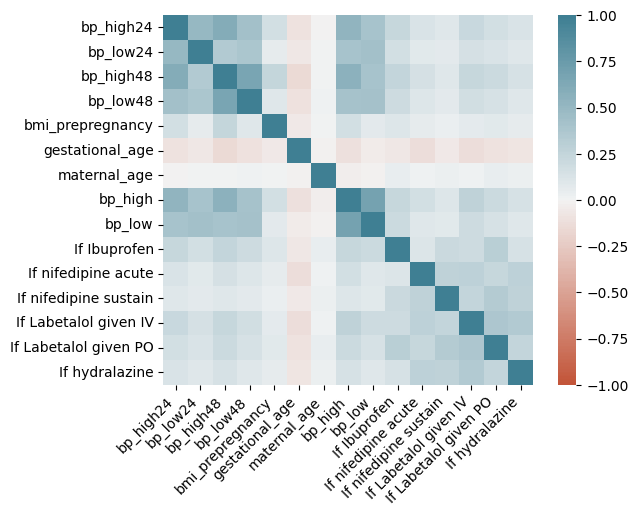

In [11]:
X.rename(columns={"m9's bmi_prepregnancy": "bmi_prepregnancy", "gestational_age (ob_clinician's_final estimate-_calculated)": "gestational_age"}, inplace = True)
corr = X.corr()

import seaborn as sns
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.savefig("all_data_corr.png", dpi=300)

In [7]:
#old and new data sets
X_old, y_old = X.iloc[0:21037], y.iloc[0:21037]
X_new, y_new = X.iloc[21037:], y.iloc[21037:]

In [237]:
corr_old = X_old.corr()

,bp_high24,bp_low24,bp_high48,bp_low48,m9's bmi_prepregnancy,gestational_age (ob_clinician's_final estimate-_calculated),maternal_age,bp_high,bp_low,If Ibuprofen,If nifedipine acute,If nifedipine sustain,If Labetalol given IV,If Labetalol given PO,If hydralazine
bp_high24,1.000000,0.515256,0.596587,0.416330,0.157387,-0.084610,-0.005473,0.535033,0.398831,0.208758,0.148132,0.034438,0.253379,0.152926,0.137403
bp_low24,0.515256,1.000000,0.355705,0.363519,0.041584,-0.067640,-0.005024,0.341705,0.353570,0.125711,0.106734,0.034194,0.200399,0.117052,0.099496
bp_high48,0.596587,0.355705,1.000000,0.642779,0.222785,-0.143508,0.005009,0.561152,0.416348,0.221158,0.173441,0.033182,0.263393,0.190024,0.145657
bp_low48,0.416330,0.363519,0.642779,1.000000,0.085596,-0.091216,0.023067,0.389502,0.415570,0.152541,0.119440,0.031630,0.206205,0.142658,0.091424
m9's bmi_prepregnancy,0.157387,0.041584,0.222785,0.085596,1.000000,-0.050979,0.005044,0.150250,0.067885,0.071891,0.046864,0.005907,0.060674,0.049009,0.039530
gestational_age (ob_clinician's_final estimate-_calculated),-0.084610,-0.067640,-0.143508,-0.091216,-0.050979,1.000000,-0.008965,-0.131892,-0.050813,-0.068299,-0.137768,-0.016473,-0.132837,-0.103452,-0.091560
maternal_age,-0.005473,-0.005024,0.005009,0.023067,0.005044,-0.008965,1.000000,-0.022458,-0.001976,0.029719,0.015602,0.009885,0.009361,0.025132,0.012316
bp_high,0.535033,0.341705,0.561152,0.389502,0.150250,-0.131892,-0.022458,1.000000,0.646138,0.195267,0.194006,0.046237,0.323115,0.190357,0.163140
bp_low,0.398831,0.353570,0.416348,0.415570,0.067885,-0.050813,-0.001976,0.646138,1.000000,0.161279,0.129585,0.046712,0.241833,0.143337,0.109119
If Ibuprofen,0.208758,0.125711,0.221158,0.152541,0.071891,-0.068299,0.029719,0.195267,0.161279,1.000000,0.056996,0.022844,0.128087,0.108849,0.035459


In [238]:
corr_new = X_new.corr()
corr_new

,bp_high24,bp_low24,bp_high48,bp_low48,m9's bmi_prepregnancy,gestational_age (ob_clinician's_final estimate-_calculated),maternal_age,bp_high,bp_low,If Ibuprofen,If nifedipine acute,If nifedipine sustain,If Labetalol given IV,If Labetalol given PO,If hydralazine
bp_high24,1.000000,0.577079,0.606364,0.461428,0.195603,-0.106543,-0.012337,0.561665,0.424880,0.260492,0.100345,0.142204,0.156650,0.198864,0.120456
bp_low24,0.577079,1.000000,0.418839,0.420246,0.081305,-0.072954,-0.027220,0.390843,0.382818,0.188905,0.069448,0.094983,0.101088,0.127482,0.077628
bp_high48,0.606364,0.418839,1.000000,0.703658,0.285633,-0.175083,0.002499,0.560730,0.417729,0.304521,0.110126,0.165429,0.177562,0.234173,0.139635
bp_low48,0.461428,0.420246,0.703658,1.000000,0.112823,-0.139978,0.016028,0.434781,0.433392,0.229358,0.067993,0.114934,0.113200,0.151491,0.083465
m9's bmi_prepregnancy,0.195603,0.081305,0.285633,0.112823,1.000000,-0.088975,-0.001095,0.188745,0.092005,0.164911,0.057022,0.063945,0.082861,0.123353,0.062245
gestational_age (ob_clinician's_final estimate-_calculated),-0.106543,-0.072954,-0.175083,-0.139978,-0.088975,1.000000,-0.017254,-0.090465,-0.017020,-0.076030,-0.082536,-0.096908,-0.088722,-0.110874,-0.058814
maternal_age,-0.012337,-0.027220,0.002499,0.016028,-0.001095,-0.017254,1.000000,-0.045568,-0.072085,0.052156,0.030971,0.048977,0.049031,0.071951,0.045328
bp_high,0.561665,0.390843,0.560730,0.434781,0.188745,-0.090465,-0.045568,1.000000,0.703419,0.263107,0.112560,0.144187,0.193083,0.196637,0.124322
bp_low,0.424880,0.382818,0.417729,0.433392,0.092005,-0.017020,-0.072085,0.703419,1.000000,0.201654,0.067319,0.094628,0.124001,0.129652,0.081429
If Ibuprofen,0.260492,0.188905,0.304521,0.229358,0.164911,-0.076030,0.052156,0.263107,0.201654,1.000000,0.212514,0.281405,0.318243,0.450834,0.248100


/var/folders/5q/wwpsrggx0ddd8xk64j4vprc40000gn/T/ipykernel_73625/2155945459.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_old.rename(columns={"m9's bmi_prepregnancy": "bmi_prepregnancy", "gestational_age (ob_clinician's_final estimate-_calculated)": "gestational_age"}, inplace = True)


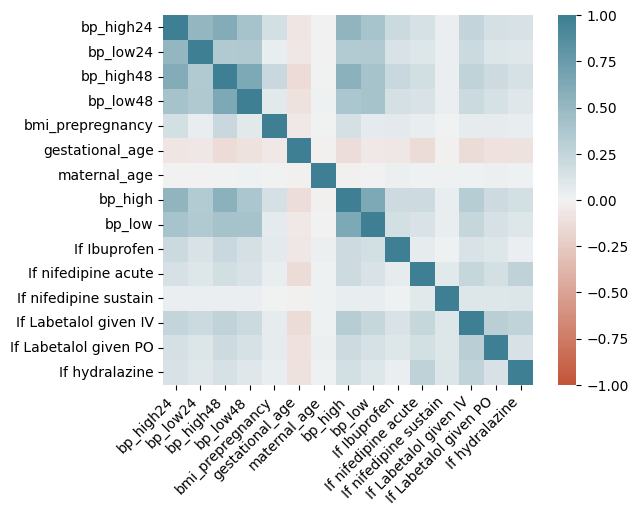

In [243]:
#olddfwithmed_keyc = olddfwithmed_key[['bp_high24','bp_low24','bp_high48','bp_low48',"m9's bmi_prepregnancy","gestational_age (ob_clinician's_final estimate-_calculated)",'maternal_age', 'bp_high', 'bp_low','If Ibuprofen', 'If nifedipine', 'If Labetalol', 'If hydralazine','Readmit']]

X_old.rename(columns={"m9's bmi_prepregnancy": "bmi_prepregnancy", "gestational_age (ob_clinician's_final estimate-_calculated)": "gestational_age"}, inplace = True)
corr = X_old.corr()

import seaborn as sns
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.savefig("old_data_corr.png", dpi=300)

/var/folders/5q/wwpsrggx0ddd8xk64j4vprc40000gn/T/ipykernel_73625/1810511834.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_new.rename(columns={"m9's bmi_prepregnancy": "bmi_prepregnancy", "gestational_age (ob_clinician's_final estimate-_calculated)": "gestational_age"}, inplace = True)


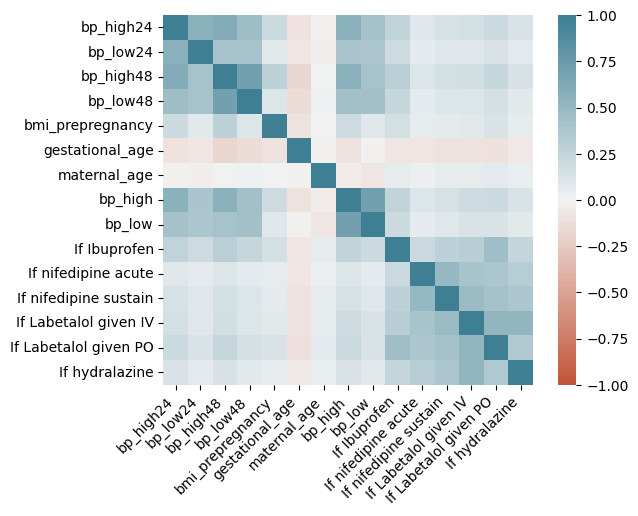

In [244]:
X_new.rename(columns={"m9's bmi_prepregnancy": "bmi_prepregnancy", "gestational_age (ob_clinician's_final estimate-_calculated)": "gestational_age"}, inplace = True)
corr = X_new.corr()
import seaborn as sns
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [8]:
X_new = X_new.reset_index(drop=True)

In [3]:
#nobp
X_nobp = combineddf.drop(['Unnamed: 0','bp_high24','bp_low24','bp_high48','bp_low48','bp_high','bp_low','READMIT_ ADM_DATE_TIME_1','READMIT_ ADM_DATE_TIME_2','Readmit'],axis=1) 

In [102]:
X_nobp

,m9's bmi_prepregnancy,gestational_age (ob_clinician's_final estimate-_calculated),maternal_age,If Ibuprofen,If nifedipine acute,If nifedipine sustain,If Labetalol given IV,If Labetalol given PO,If hydralazine
0,22.3,40.7,21.0,0,0,0,0,0,0
1,22.5,38.6,16.0,0,0,0,0,0,0
2,31.4,38.1,27.0,0,0,0,0,0,0
3,30.9,39.1,29.0,0,0,0,0,0,0
4,47.6,38.4,39.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
32640,31.4,34.3,31.0,0,0,0,0,0,0
32641,21.5,40.7,21.0,0,0,0,0,0,0
32642,26.6,40.1,34.0,0,0,0,0,0,0
32643,25.6,38.1,33.0,0,0,0,0,0,0


# Model selection and 

In [154]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_o = scaler.fit_transform(X_old)
scaled_n = scaler.fit_transform(X_new)

In [9]:
y_new = y_new.reset_index(drop=True)

In [10]:
from sklearn.model_selection import StratifiedKFold

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
balances = [{0: 1, 1: 1}, {0: 1, 1: 200}, {0: 1, 1: 300}, {0: 1, 1: 500}, {0: 1, 1: 1000}]
m_dep = [2, 4, 6, 8, 10, 50, 100]
n_est = [5, 10, 100, 500, 1000]
#m_fea = ['sqrt','log2']
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
rf_o_result_dfs = []
for balance in balances:
    print('I am bal')
    lis = []
    for i in m_dep:
        for j in n_est:
            lst_bala_accu_stratified = []
            lst_spe_stratified = []
            lst_sens_stratified = []
            lst_exp_cost = []
            lst_pre = []
            lst_npv = []
            for train_index, test_index in skf.split(scaled_o, y_old):
                X_train_fold, X_test_fold = scaled_o[train_index], scaled_o[test_index]
                y_train_fold, y_test_fold = y_old[train_index], y_old[test_index]
                RF_co = RandomForestClassifier(max_depth = i, n_estimators = j, class_weight=balance)
                RF_co.fit(X_train_fold, y_train_fold)
                RF_co_prd=RF_co.predict(X_test_fold)
                tn, fp, fn, tp = confusion_matrix(y_test_fold, RF_co_prd).ravel()
                ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
                spe = 1.*tn/(tn+fp)
                sens = 1.*tp/(tp+fn)
                pres = tp/(tp+fp)
                npvs = tn/(tn+fn)
                cos = 565.*fn + 1.*fp
                lst_bala_accu_stratified.append(ba)
                lst_spe_stratified.append(spe)
                lst_sens_stratified.append(sens)
                lst_exp_cost.append(cos)
                lst_pre.append(pres)
                lst_npv.append(npvs)
            #print(np.mean(lst_bala_accu_stratified))
            lis.append([balance,i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                        np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
    lis_dfOps = pd.DataFrame(lis)
    df_rf_baOps = lis_dfOps.sort_values(by=[5], ascending=False)
    rf_o_result_dfs.append(df_rf_baOps.head(1))
final_Oresult_df = pd.concat(rf_o_result_dfs, ignore_index=True)
#df_rf_pc5p = lis_df5p.sort_values(by=[5], ascending=False)
#print(df_rf_pc5p.head(1))

In [165]:
final_Oresult_df

,0,1,2,3,4,5,6,7,8
0,"{0: 1, 1: 1}",100,1000,1.000000,0.092208,0.546104,1.000000,0.995339,11074.0
1,"{0: 1, 1: 200}",2,1000,0.810311,0.786580,0.798446,0.020936,0.998652,3393.0
2,"{0: 1, 1: 300}",4,100,0.823068,0.759307,0.791188,0.021618,0.998502,3678.6
3,"{0: 1, 1: 500}",4,1000,0.772469,0.814719,0.793594,0.018135,0.998772,3212.4
4,"{0: 1, 1: 1000}",6,1000,0.796215,0.777489,0.786852,0.019248,0.998580,3565.0


In [216]:
final_Oresult_df['f1'] = 2* final_Oresult_df[4] * final_Oresult_df[6]/(final_Oresult_df[4] + final_Oresult_df[6])
final_Oresult_df['cost'] = final_Oresult_df[8] * 36

In [217]:
final_Oresult_df

,0,1,2,3,4,5,6,7,8,f1,cost
0,"{0: 1, 1: 1}",100,1000,1.000000,0.092208,0.546104,1.000000,0.995339,11074.0,0.168847,398664.0
1,"{0: 1, 1: 200}",2,1000,0.810311,0.786580,0.798446,0.020936,0.998652,3393.0,0.040786,122148.0
2,"{0: 1, 1: 300}",4,100,0.823068,0.759307,0.791188,0.021618,0.998502,3678.6,0.042039,132429.6
3,"{0: 1, 1: 500}",4,1000,0.772469,0.814719,0.793594,0.018135,0.998772,3212.4,0.035480,115646.4
4,"{0: 1, 1: 1000}",6,1000,0.796215,0.777489,0.786852,0.019248,0.998580,3565.0,0.037567,128340.0


In [251]:
from sklearn.model_selection import cross_val_score, KFold
balance = {0: 1, 1: 200}
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

rf_classifier = RandomForestClassifier(max_depth = 2, n_estimators = 1000, class_weight=balance)
feature_importances_list = []
for train_index, test_index in kf.split(X_old):
    X_train, X_test = X_old.loc[train_index], X_old.loc[test_index]
    y_train, y_test = y_old[train_index], y_old[test_index]

    rf_classifier.fit(X_train, y_train)
    feature_importances_list.append(rf_classifier.feature_importances_)
average_feature_importances = np.mean(feature_importances_list, axis=0)
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': average_feature_importances})


feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                                              Feature  Importance
2                                           bp_high48    0.236484
7                                             bp_high    0.172510
0                                           bp_high24    0.167386
8                                              bp_low    0.112507
3                                            bp_low48    0.098120
1                                            bp_low24    0.074475
5   gestational_age (ob_clinician's_final estimate...    0.068022
4                               m9's bmi_prepregnancy    0.022575
12                              If Labetalol given IV    0.018617
6                                        maternal_age    0.009441
9                                        If Ibuprofen    0.008045
10                                If nifedipine acute    0.007229
13                              If Labetalol given PO    0.003024
14                                     If hydralazine    0.001563
11        

In [256]:
X_new

,bp_high24,bp_low24,bp_high48,bp_low48,bmi_prepregnancy,gestational_age,maternal_age,bp_high,bp_low,If Ibuprofen,If nifedipine acute,If nifedipine sustain,If Labetalol given IV,If Labetalol given PO,If hydralazine
0,131.0,82.0,128.0,74.0,28.2,37.6,35.0,139.0,97.0,0,0,0,0,0,0
1,123.0,81.0,108.0,68.0,17.7,39.6,24.0,131.0,78.0,0,0,0,0,0,0
2,125.0,82.0,121.0,81.0,21.1,40.1,34.0,126.0,92.0,0,0,0,0,0,0
3,143.0,78.0,139.0,72.0,22.9,39.3,40.0,155.0,89.0,0,0,0,0,0,0
4,133.0,92.0,112.0,71.0,20.5,40.3,24.0,138.0,95.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11603,159.0,116.0,160.0,85.0,31.4,34.3,31.0,171.0,94.0,0,0,0,0,0,0
11604,158.0,89.0,116.0,61.0,21.5,40.7,21.0,139.0,99.0,0,0,0,0,0,0
11605,125.0,84.0,128.0,83.0,26.6,40.1,34.0,145.0,88.0,0,0,0,0,0,0
11606,115.0,71.0,109.0,74.0,25.6,38.1,33.0,123.0,87.0,0,0,0,0,0,0


In [257]:
balance = {0: 1, 1: 200}
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

rf_classifier = RandomForestClassifier(max_depth = 2, n_estimators = 1000, class_weight=balance)
feature_importances_list = []
for train_index, test_index in kf.split(X_new):
    X_train, X_test = X_new.loc[train_index], X_new.loc[test_index]
    y_train, y_test = y_new[train_index], y_new[test_index]

    rf_classifier.fit(X_train, y_train)
    feature_importances_list.append(rf_classifier.feature_importances_)
average_feature_importances = np.mean(feature_importances_list, axis=0)
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': average_feature_importances})


feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                                              Feature  Importance
2                                           bp_high48    0.178015
0                                           bp_high24    0.157151
7                                             bp_high    0.126119
6                                        maternal_age    0.125663
3                                            bp_low48    0.087423
9                                        If Ibuprofen    0.074443
13                              If Labetalol given PO    0.069596
1                                            bp_low24    0.052265
5   gestational_age (ob_clinician's_final estimate...    0.039978
8                                              bp_low    0.033329
4                               m9's bmi_prepregnancy    0.019008
11                              If nifedipine sustain    0.017536
12                              If Labetalol given IV    0.008309
14                                     If hydralazine    0.007802
10        

In [26]:
#validate
balance = {0: 1, 1: 200}
X_train, X_test, y_train, y_test = X_old, X_new, y_old, y_new

# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(max_depth = 2, n_estimators = 1000, class_weight=balance, random_state = 10)

# Train the model
rf_classifier.fit(X_train, y_train)
RF_prd=rf_classifier.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, RF_prd).ravel()
ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
spe = 1.*tn/(tn+fp)
sens = 1.*tp/(tp+fn)
pres = tp/(tp+fp)
npvs = tn/(tn+fn)
cos = 565.*fn + 1.*fp
lis=[ba,spe,sens,pres,npvs,cos]
lis


[0.750479149321368,
 0.710635717997575,
 0.7903225806451613,
 0.014454277286135693,
 0.9984181065952786,
 10686.0]

In [12]:
#validate
balance = {0: 1, 1: 300}
X_train, X_test, y_train, y_test = X_old, X_new, y_old, y_new

DT = DecisionTreeClassifier(max_depth=4, class_weight=balance, random_state = 10)
                
# Train the model
DT.fit(X_train, y_train)
DT_prd=DT.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, DT_prd).ravel()
ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
spe = 1.*tn/(tn+fp)
sens = 1.*tp/(tp+fn)
pres = tp/(tp+fp)
npvs = tn/(tn+fn)
cos = 565.*fn + 1.*fp
lis=[ba,spe,sens,pres,npvs,cos]
lis

[0.7037334532836397,
 0.649402390438247,
 0.7580645161290323,
 0.011477411477411478,
 0.9980034606681751,
 12523.0]

In [16]:
#validate
balance = {0: 1, 1: 300}
X_train, X_test, y_train, y_test = X_old, X_new, y_old, y_new

sv = SVC(C = 0.01, kernel = 'rbf', class_weight=balance, random_state = 10)
                
# Train the model
sv.fit(X_train, y_train)
sv_prd=sv.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, sv_prd).ravel()
ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
spe = 1.*tn/(tn+fp)
sens = 1.*tp/(tp+fn)
pres = tp/(tp+fp)
npvs = tn/(tn+fn)
cos = 565.*fn + 1.*fp
lis=[ba,spe,sens,pres,npvs,cos]
lis

[0.7176790733280063,
 0.5321323402043998,
 0.9032258064516129,
 0.010260168559912056,
 0.9990243902439024,
 8792.0]

In [18]:
#validate
balance = {0: 1, 1: 300}
X_train, X_test, y_train, y_test = X_old, X_new, y_old, y_new

LogReg1 = LogisticRegression(C=0.01, penalty='l1', solver='liblinear', class_weight=balance, random_state = 10)
                
# Train the model
LogReg1.fit(X_train, y_train)
LogReg1_prd=LogReg1.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, LogReg1_prd).ravel()
ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
spe = 1.*tn/(tn+fp)
sens = 1.*tp/(tp+fn)
pres = tp/(tp+fp)
npvs = tn/(tn+fn)
cos = 565.*fn + 1.*fp
lis=[ba,spe,sens,pres,npvs,cos]
lis

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[0.7299385906584043,
 0.6211675038974537,
 0.8387096774193549,
 0.01174875734297334,
 0.9986076301865775,
 10024.0]

In [20]:
#validate
balance = {0: 1, 1: 300}
X_train, X_test, y_train, y_test = X_old, X_new, y_old, y_new

LogReg2 = LogisticRegression(C=0.01, penalty='l2', solver='liblinear', class_weight=balance, random_state = 10)
                
# Train the model
LogReg2.fit(X_train, y_train)
LogReg2_prd=LogReg2.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, LogReg2_prd).ravel()
ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
spe = 1.*tn/(tn+fp)
sens = 1.*tp/(tp+fn)
pres = tp/(tp+fp)
npvs = tn/(tn+fn)
cos = 565.*fn + 1.*fp
lis=[ba,spe,sens,pres,npvs,cos]
lis

[0.7347887552175589,
 0.630867833015763,
 0.8387096774193549,
 0.01205377839592026,
 0.9986290101453249,
 9912.0]

In [21]:
f1 = 2*sens*pres/(sens+pres)
f1

0.02376599634369287

In [ ]:
balances = [{0: 1, 1: 1}, {0: 1, 1: 200}, {0: 1, 1: 300}, {0: 1, 1: 500}, {0: 1, 1: 1000}]
m_dep = [2, 4, 6, 8, 10, 50, 100]
n_est = [5, 10, 100, 500, 1000]
#m_fea = ['sqrt','log2']
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
rf_n_result_dfs = []
for balance in balances:
    print('I am bal')
    lis = []
    for i in m_dep:
        for j in n_est:
            lst_bala_accu_stratified = []
            lst_spe_stratified = []
            lst_sens_stratified = []
            lst_exp_cost = []
            lst_pre = []
            lst_npv = []
            for train_index, test_index in skf.split(scaled_n, y_new):
                X_train_fold, X_test_fold = scaled_n[train_index], scaled_n[test_index]
                y_train_fold, y_test_fold = y_new[train_index], y_new[test_index]
                RF_cn = RandomForestClassifier(max_depth = i, n_estimators = j, class_weight=balance)
                RF_cn.fit(X_train_fold, y_train_fold)
                RF_cn_prd=RF_cn.predict(X_test_fold)
                tn, fp, fn, tp = confusion_matrix(y_test_fold, RF_cn_prd).ravel()
                ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
                spe = 1.*tn/(tn+fp)
                sens = 1.*tp/(tp+fn)
                pres = tp/(tp+fp)
                npvs = tn/(tn+fn)
                cos = 565.*fn + 1.*fp
                lst_bala_accu_stratified.append(ba)
                lst_spe_stratified.append(spe)
                lst_sens_stratified.append(sens)
                lst_exp_cost.append(cos)
                lst_pre.append(pres)
                lst_npv.append(npvs)
            #print(np.mean(lst_bala_accu_stratified))
            lis.append([balance,i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                        np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
    lis_dfNps = pd.DataFrame(lis)
    df_rf_baNps = lis_dfNps.sort_values(by=[5], ascending=False)
    rf_n_result_dfs.append(df_rf_baNps.head(1))
final_Nresult_df = pd.concat(rf_n_result_dfs, ignore_index=True)
#df_rf_pc5p = lis_df5p.sort_values(by=[5], ascending=False)
#print(df_rf_pc5p.head(1))

In [179]:
final_Nresult_df = pd.concat(rf_n_result_dfs, ignore_index=True)
final_Nresult_df

,0,1,2,3,4,5,6,7,8
0,"{0: 1, 1: 1}",8,5,0.999567,0.015385,0.507476,NaN,0.994742,6894.0
1,"{0: 1, 1: 200}",2,100,0.800277,0.743590,0.771933,0.019669,0.998272,2269.2
2,"{0: 1, 1: 300}",2,500,0.683006,0.824359,0.753683,0.013781,0.998618,1975.0
3,"{0: 1, 1: 500}",4,100,0.755240,0.761538,0.758389,0.016335,0.998294,2260.2
4,"{0: 1, 1: 1000}",6,5,0.752211,0.724359,0.738285,0.015432,0.998061,2493.2


In [218]:
final_Nresult_df['f1'] = 2* final_Nresult_df[4] * final_Nresult_df[6]/(final_Nresult_df[4] + final_Nresult_df[6])
final_Nresult_df['cost'] = final_Nresult_df[8] * 36

In [219]:
final_Nresult_df

,0,1,2,3,4,5,6,7,8,f1,cost
0,"{0: 1, 1: 1}",8,5,0.999567,0.015385,0.507476,NaN,0.994742,6894.0,NaN,248184.0
1,"{0: 1, 1: 200}",2,100,0.800277,0.743590,0.771933,0.019669,0.998272,2269.2,0.038325,81691.2
2,"{0: 1, 1: 300}",2,500,0.683006,0.824359,0.753683,0.013781,0.998618,1975.0,0.027108,71100.0
3,"{0: 1, 1: 500}",4,100,0.755240,0.761538,0.758389,0.016335,0.998294,2260.2,0.031984,81367.2
4,"{0: 1, 1: 1000}",6,5,0.752211,0.724359,0.738285,0.015432,0.998061,2493.2,0.030220,89755.2


In [15]:
from sklearn.svm import SVC

In [ ]:
#SVC old
balances = [{0: 1, 1: 1}, {0: 1, 1: 200}, {0: 1, 1: 300}, {0: 1, 1: 500}, {0: 1, 1: 1000}]
c = [50, 10, 1.0, 0.1, 0.01]
ker = ['poly', 'rbf', 'sigmoid']
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
sv_o_result_dfs = []
for balance in balances:
    lis = []
    for i in c:
        for j in ker:
            lst_bala_accu_stratified = []
            lst_spe_stratified = []
            lst_sens_stratified = []
            lst_exp_cost = []
            lst_pre = []
            lst_npv = []
            for train_index, test_index in skf.split(scaled_o, y_old):
                X_train_fold, X_test_fold = scaled_o[train_index], scaled_o[test_index]
                y_train_fold, y_test_fold = y_old[train_index], y_old[test_index]
                sv = SVC(C = i, kernel = j, class_weight=balance)
                sv.fit(X_train_fold, y_train_fold)
                sv_prd=sv.predict(X_test_fold)
                tn, fp, fn, tp = confusion_matrix(y_test_fold, sv_prd).ravel()
                ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
                spe = 1.*tn/(tn+fp)
                sens = 1.*tp/(tp+fn)
                pres = tp/(tp+fp)
                npvs = tn/(tn+fn)
                cos = 565.*fn + 1.*fp
                lst_bala_accu_stratified.append(ba)
                lst_spe_stratified.append(spe)
                lst_sens_stratified.append(sens)
                lst_exp_cost.append(cos)
                lst_pre.append(pres)
                lst_npv.append(npvs)
            #print(np.mean(lst_bala_accu_stratified))
            lis.append([balance,i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                        np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
    lis_svo = pd.DataFrame(lis)
    df_svo = lis_svo.sort_values(by=[5], ascending=False)
    sv_o_result_dfs.append(df_svo.head(1))

In [183]:
final_svo_result_df = pd.concat(sv_o_result_dfs, ignore_index=True)
final_svo_result_df

,0,1,2,3,4,5,6,7,8
0,"{0: 1, 1: 1}",50.00,poly,0.994744,0.082251,0.538498,0.065733,0.995267,11209.0
1,"{0: 1, 1: 200}",0.01,rbf,0.794113,0.739394,0.766754,0.018047,0.998346,4025.8
2,"{0: 1, 1: 300}",0.01,rbf,0.719624,0.833333,0.776479,0.015045,0.998825,3207.6
3,"{0: 1, 1: 500}",0.01,rbf,0.637394,0.888745,0.763069,0.012491,0.999127,2873.8
4,"{0: 1, 1: 1000}",0.01,rbf,0.528310,0.897835,0.713073,0.009788,0.999065,3217.4


In [214]:
final_svo_result_df['f1'] = 2* final_svo_result_df[4] * final_svo_result_df[6]/(final_svo_result_df[4] + final_svo_result_df[6])
final_svo_result_df['cost'] = final_svo_result_df[8] * 36

In [215]:
final_svo_result_df

,0,1,2,3,4,5,6,7,8,f1,cost
0,"{0: 1, 1: 1}",50.00,poly,0.994744,0.082251,0.538498,0.065733,0.995267,11209.0,0.073070,403524.0
1,"{0: 1, 1: 200}",0.01,rbf,0.794113,0.739394,0.766754,0.018047,0.998346,4025.8,0.035233,144928.8
2,"{0: 1, 1: 300}",0.01,rbf,0.719624,0.833333,0.776479,0.015045,0.998825,3207.6,0.029556,115473.6
3,"{0: 1, 1: 500}",0.01,rbf,0.637394,0.888745,0.763069,0.012491,0.999127,2873.8,0.024636,103456.8
4,"{0: 1, 1: 1000}",0.01,rbf,0.528310,0.897835,0.713073,0.009788,0.999065,3217.4,0.019365,115826.4


In [ ]:
#SVC new
balances = [{0: 1, 1: 1}, {0: 1, 1: 200}, {0: 1, 1: 300}, {0: 1, 1: 500}, {0: 1, 1: 1000}]
c = [50, 10, 1.0, 0.1, 0.01]
ker = ['poly', 'rbf', 'sigmoid']
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
sv_n_result_dfs = []
for balance in balances:
    lis = []
    for i in c:
        for j in ker:
            lst_bala_accu_stratified = []
            lst_spe_stratified = []
            lst_sens_stratified = []
            lst_exp_cost = []
            lst_pre = []
            lst_npv = []
            for train_index, test_index in skf.split(scaled_n, y_new):
                X_train_fold, X_test_fold = scaled_n[train_index], scaled_n[test_index]
                y_train_fold, y_test_fold = y_new[train_index], y_new[test_index]
                sv = SVC(C = i, kernel = j, class_weight=balance)
                sv.fit(X_train_fold, y_train_fold)
                sv_prd=sv.predict(X_test_fold)
                tn, fp, fn, tp = confusion_matrix(y_test_fold, sv_prd).ravel()
                ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
                spe = 1.*tn/(tn+fp)
                sens = 1.*tp/(tp+fn)
                pres = tp/(tp+fp)
                npvs = tn/(tn+fn)
                cos = 565.*fn + 1.*fp
                lst_bala_accu_stratified.append(ba)
                lst_spe_stratified.append(spe)
                lst_sens_stratified.append(sens)
                lst_exp_cost.append(cos)
                lst_pre.append(pres)
                lst_npv.append(npvs)
            #print(np.mean(lst_bala_accu_stratified))
            lis.append([balance,i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                        np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
    lis_svn = pd.DataFrame(lis)
    df_svn = lis_svn.sort_values(by=[5], ascending=False)
    sv_n_result_dfs.append(df_svn.head(1))
final_svn_result_df = pd.concat(sv_n_result_dfs, ignore_index=True)

In [185]:
final_svn_result_df

,0,1,2,3,4,5,6,7,8
0,"{0: 1, 1: 1}",10.00,poly,0.997315,0.144872,0.571093,0.239341,0.995419,5995.2
1,"{0: 1, 1: 200}",0.01,rbf,0.805041,0.758974,0.782008,0.020450,0.998391,2145.2
2,"{0: 1, 1: 300}",0.01,rbf,0.725447,0.823077,0.774262,0.015815,0.998697,1877.0
3,"{0: 1, 1: 500}",0.01,rbf,0.627666,0.887179,0.757422,0.012609,0.999060,1650.8
4,"{0: 1, 1: 1000}",0.01,rbf,0.599170,0.887179,0.743175,0.011715,0.999012,1716.6


In [220]:
final_svn_result_df['f1'] = 2* final_svn_result_df[4] * final_svn_result_df[6]/(final_svn_result_df[4] + final_svn_result_df[6])
final_svn_result_df['cost'] = final_svn_result_df[8] * 36

In [221]:
final_svn_result_df

,0,1,2,3,4,5,6,7,8,f1,cost
0,"{0: 1, 1: 1}",10.00,poly,0.997315,0.144872,0.571093,0.239341,0.995419,5995.2,0.180492,215827.2
1,"{0: 1, 1: 200}",0.01,rbf,0.805041,0.758974,0.782008,0.020450,0.998391,2145.2,0.039828,77227.2
2,"{0: 1, 1: 300}",0.01,rbf,0.725447,0.823077,0.774262,0.015815,0.998697,1877.0,0.031033,67572.0
3,"{0: 1, 1: 500}",0.01,rbf,0.627666,0.887179,0.757422,0.012609,0.999060,1650.8,0.024865,59428.8
4,"{0: 1, 1: 1000}",0.01,rbf,0.599170,0.887179,0.743175,0.011715,0.999012,1716.6,0.023124,61797.6


In [ ]:
balances = [{0: 1, 1: 1}, {0: 1, 1: 200}, {0: 1, 1: 300}, {0: 1, 1: 500}, {0: 1, 1: 1000}]
m_dep = [2, 4, 6, 8, 10, 50, 100]
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
dt_o_result_dfs = []
for balance in balances:
    lis = []
    for i in m_dep:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        lst_exp_cost = []
        lst_pre = []
        lst_npv = []
        for train_index, test_index in skf.split(scaled_o, y_old):
                X_train_fold, X_test_fold = scaled_o[train_index], scaled_o[test_index]
                y_train_fold, y_test_fold = y_old[train_index], y_old[test_index]
                DT = DecisionTreeClassifier(max_depth=i, class_weight=balance)
                DT.fit(X_train_fold, y_train_fold)
                DT_prd=DT.predict(X_test_fold)
                tn, fp, fn, tp = confusion_matrix(y_test_fold, DT_prd).ravel()
                ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
                spe = 1.*tn/(tn+fp)
                sens = 1.*tp/(tp+fn)
                pres = tp/(tp+fp)
                npvs = tn/(tn+fn)
                cos = 565.*fn + 1.*fp
                lst_bala_accu_stratified.append(ba)
                lst_spe_stratified.append(spe)
                lst_sens_stratified.append(sens)
                lst_exp_cost.append(cos)
                lst_pre.append(pres)
                lst_npv.append(npvs)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([balance,i,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                        np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
    lis_dto = pd.DataFrame(lis)
    df_dto = lis_dto.sort_values(by=[4], ascending=False)
    dt_o_result_dfs.append(df_dto.head(1))
final_dto_result_df = pd.concat(dt_o_result_dfs, ignore_index=True)

In [187]:
final_dto_result_df

,0,1,2,3,4,5,6,7
0,"{0: 1, 1: 1}",100,0.993119,0.101732,0.547426,0.074678,0.995355,10989.8
1,"{0: 1, 1: 200}",2,0.751880,0.760173,0.756026,0.016204,0.998383,3976.6
2,"{0: 1, 1: 300}",4,0.743225,0.804762,0.773993,0.015948,0.998674,3447.8
3,"{0: 1, 1: 500}",4,0.703665,0.813853,0.758759,0.014112,0.998639,3500.4
4,"{0: 1, 1: 1000}",8,0.735917,0.796970,0.766443,0.015431,0.998579,3591.4


In [210]:
final_dto_result_df['f1'] = 2* final_dto_result_df[5] * final_dto_result_df[3]/(final_dto_result_df[5] + final_dto_result_df[3])
final_dto_result_df['cost'] = final_dto_result_df[7] * 36

In [211]:
final_dto_result_df

,0,1,2,3,4,5,6,7,f1,cost
0,"{0: 1, 1: 1}",100,0.993119,0.101732,0.547426,0.074678,0.995355,10989.8,0.086130,395632.8
1,"{0: 1, 1: 200}",2,0.751880,0.760173,0.756026,0.016204,0.998383,3976.6,0.031732,143157.6
2,"{0: 1, 1: 300}",4,0.743225,0.804762,0.773993,0.015948,0.998674,3447.8,0.031276,124120.8
3,"{0: 1, 1: 500}",4,0.703665,0.813853,0.758759,0.014112,0.998639,3500.4,0.027743,126014.4
4,"{0: 1, 1: 1000}",8,0.735917,0.796970,0.766443,0.015431,0.998579,3591.4,0.030277,129290.4


In [ ]:
balances = [{0: 1, 1: 1}, {0: 1, 1: 200}, {0: 1, 1: 300}, {0: 1, 1: 500}, {0: 1, 1: 1000}]
m_dep = [2, 4, 6, 8, 10, 50, 100]
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
dt_n_result_dfs = []
for balance in balances:
    lis = []
    for i in m_dep:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        lst_exp_cost = []
        lst_pre = []
        lst_npv = []
        for train_index, test_index in skf.split(scaled_n, y_new):
                X_train_fold, X_test_fold = scaled_n[train_index], scaled_n[test_index]
                y_train_fold, y_test_fold = y_new[train_index], y_new[test_index]
                DT = DecisionTreeClassifier(max_depth=i, class_weight=balance)
                DT.fit(X_train_fold, y_train_fold)
                DT_prd=DT.predict(X_test_fold)
                tn, fp, fn, tp = confusion_matrix(y_test_fold, DT_prd).ravel()
                ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
                spe = 1.*tn/(tn+fp)
                sens = 1.*tp/(tp+fn)
                pres = tp/(tp+fp)
                npvs = tn/(tn+fn)
                cos = 565.*fn + 1.*fp
                lst_bala_accu_stratified.append(ba)
                lst_spe_stratified.append(spe)
                lst_sens_stratified.append(sens)
                lst_exp_cost.append(cos)
                lst_pre.append(pres)
                lst_npv.append(npvs)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([balance,i,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                        np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
    lis_dtn = pd.DataFrame(lis)
    df_dtn = lis_dtn.sort_values(by=[4], ascending=False)
    dt_n_result_dfs.append(df_dtn.head(1))
final_dtn_result_df = pd.concat(dt_n_result_dfs, ignore_index=True)

In [189]:
final_dtn_result_df

,0,1,2,3,4,5,6,7
0,"{0: 1, 1: 1}",10,0.995063,0.064103,0.529583,0.056863,0.994977,6565.4
1,"{0: 1, 1: 200}",4,0.761825,0.662821,0.712323,0.014708,0.997636,2923.0
2,"{0: 1, 1: 300}",4,0.714362,0.694872,0.704617,0.012923,0.997715,2806.6
3,"{0: 1, 1: 500}",6,0.753947,0.647436,0.700692,0.013795,0.997533,3054.2
4,"{0: 1, 1: 1000}",4,0.574134,0.871795,0.722965,0.010878,0.998820,1887.4


In [222]:
final_dtn_result_df['f1'] = 2* final_dtn_result_df[5] * final_dtn_result_df[3]/(final_dtn_result_df[5] + final_dtn_result_df[3])
final_dtn_result_df['cost'] = final_dtn_result_df[7] * 36

In [223]:
final_dtn_result_df

,0,1,2,3,4,5,6,7,f1,cost
0,"{0: 1, 1: 1}",10,0.995063,0.064103,0.529583,0.056863,0.994977,6565.4,0.060266,236354.4
1,"{0: 1, 1: 200}",4,0.761825,0.662821,0.712323,0.014708,0.997636,2923.0,0.028777,105228.0
2,"{0: 1, 1: 300}",4,0.714362,0.694872,0.704617,0.012923,0.997715,2806.6,0.025374,101037.6
3,"{0: 1, 1: 500}",6,0.753947,0.647436,0.700692,0.013795,0.997533,3054.2,0.027015,109951.2
4,"{0: 1, 1: 1000}",4,0.574134,0.871795,0.722965,0.010878,0.998820,1887.4,0.021487,67946.4


In [ ]:
balances = [{0: 1, 1: 1}, {0: 1, 1: 200}, {0: 1, 1: 300}, {0: 1, 1: 500}, {0: 1, 1: 1000}]
c = [0.01, 0.1, 1, 10, 100]
sol = ['liblinear','saga']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
l1_o_result_dfs = []
for balance in balances:
    lis = []
    for i in c:
        for j in sol:
            lst_bala_accu_stratified = []
            lst_spe_stratified = []
            lst_sens_stratified = []
            lst_exp_cost = []
            lst_pre = []
            lst_npv = []
            for train_index, test_index in skf.split(scaled_o, y_old):
                X_train_fold, X_test_fold = scaled_o[train_index], scaled_o[test_index]
                y_train_fold, y_test_fold = y_old[train_index], y_old[test_index]
                LogReg1 = LogisticRegression(C=i, penalty='l1', solver=j, class_weight=balance)
                LogReg1.fit(X_train_fold, y_train_fold)
                LogReg1_prd=LogReg1.predict(X_test_fold)
                tn, fp, fn, tp = confusion_matrix(y_test_fold, LogReg1_prd).ravel()
                ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
                spe = 1.*tn/(tn+fp)
                sens = 1.*tp/(tp+fn)
                pres = tp/(tp+fp)
                npvs = tn/(tn+fn)
                cos = 565.*fn + 1.*fp
                lst_bala_accu_stratified.append(ba)
                lst_spe_stratified.append(spe)
                lst_sens_stratified.append(sens)
                lst_exp_cost.append(cos)
                lst_pre.append(pres)
                lst_npv.append(npvs)
            #print(np.mean(lst_bala_accu_stratified))
            lis.append([balance,i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                        np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
    lis_lr1o = pd.DataFrame(lis)
    df_lr1o = lis_lr1o.sort_values(by=[5], ascending=False)
    l1_o_result_dfs.append(df_lr1o.head(1))
final_lr1o_result_df = pd.concat(l1_o_result_dfs, ignore_index=True)

In [193]:
final_lr1o_result_df

,0,1,2,3,4,5,6,7,8
0,"{0: 1, 1: 1}",0.01,liblinear,1.000000,0.000000,0.500000,NaN,0.994866,12204.0
1,"{0: 1, 1: 200}",1.00,saga,0.798127,0.722078,0.760103,0.018793,0.998192,4235.0
2,"{0: 1, 1: 300}",0.01,liblinear,0.729085,0.814719,0.771902,0.015254,0.998713,3394.0
3,"{0: 1, 1: 500}",10.00,saga,0.643175,0.870130,0.756652,0.012411,0.998974,3075.6
4,"{0: 1, 1: 1000}",10.00,liblinear,0.432081,0.926407,0.679244,0.008355,0.999186,3281.2


In [205]:
final_lr1o_result_df['f1'] = 2* final_lr1o_result_df[6] * final_lr1o_result_df[4]/(final_lr1o_result_df[6] + final_lr1o_result_df[4])
final_lr1o_result_df['cost'] = final_lr1o_result_df[8] * 36

In [206]:
final_lr1o_result_df['f1']

0         NaN
1    0.036634
2    0.029948
3    0.024473
4    0.016561
Name: f1, dtype: float64

In [207]:
final_lr1o_result_df['cost']

0    439344.0
1    152460.0
2    122184.0
3    110721.6
4    118123.2
Name: cost, dtype: float64

In [ ]:
balances = [{0: 1, 1: 1}, {0: 1, 1: 200}, {0: 1, 1: 300}, {0: 1, 1: 500}, {0: 1, 1: 1000}]
c = [0.01, 0.1, 1, 10, 100]
sol = ['liblinear','saga']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
l1_n_result_dfs = []
for balance in balances:
    lis = []
    for i in c:
        for j in sol:
            lst_bala_accu_stratified = []
            lst_spe_stratified = []
            lst_sens_stratified = []
            lst_exp_cost = []
            lst_pre = []
            lst_npv = []
            for train_index, test_index in skf.split(scaled_n, y_new):
                X_train_fold, X_test_fold = scaled_n[train_index], scaled_n[test_index]
                y_train_fold, y_test_fold = y_new[train_index], y_new[test_index]
                LogReg1 = LogisticRegression(C=i, penalty='l1', solver=j, class_weight=balance)
                LogReg1.fit(X_train_fold, y_train_fold)
                LogReg1_prd=LogReg1.predict(X_test_fold)
                tn, fp, fn, tp = confusion_matrix(y_test_fold, LogReg1_prd).ravel()
                ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
                spe = 1.*tn/(tn+fp)
                sens = 1.*tp/(tp+fn)
                pres = tp/(tp+fp)
                npvs = tn/(tn+fn)
                cos = 565.*fn + 1.*fp
                lst_bala_accu_stratified.append(ba)
                lst_spe_stratified.append(spe)
                lst_sens_stratified.append(sens)
                lst_exp_cost.append(cos)
                lst_pre.append(pres)
                lst_npv.append(npvs)
            #print(np.mean(lst_bala_accu_stratified))
            lis.append([balance,i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                        np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
    lis_lr1n = pd.DataFrame(lis)
    df_lr1n = lis_lr1n.sort_values(by=[5], ascending=False)
    l1_n_result_dfs.append(df_lr1n.head(1))
final_lr1n_result_df = pd.concat(l1_n_result_dfs, ignore_index=True)

In [195]:
final_lr1n_result_df

,0,1,2,3,4,5,6,7,8
0,"{0: 1, 1: 1}",0.01,liblinear,1.000000,0.000000,0.500000,NaN,0.994659,7006.0
1,"{0: 1, 1: 200}",0.01,liblinear,0.801404,0.730769,0.766086,0.019107,0.998178,2379.6
2,"{0: 1, 1: 300}",0.01,liblinear,0.718172,0.778205,0.748188,0.014412,0.998344,2232.8
3,"{0: 1, 1: 500}",10.00,liblinear,0.615712,0.811538,0.713625,0.011015,0.998397,2243.4
4,"{0: 1, 1: 1000}",0.01,liblinear,0.446910,0.907692,0.677301,0.008701,0.998993,1955.2


In [224]:
final_lr1n_result_df['f1'] = 2* final_lr1n_result_df[6] * final_lr1n_result_df[4]/(final_lr1n_result_df[6] + final_lr1n_result_df[4])
final_lr1n_result_df['cost'] = final_lr1n_result_df[8] * 36

In [225]:
final_lr1n_result_df

,0,1,2,3,4,5,6,7,8,f1,cost
0,"{0: 1, 1: 1}",0.01,liblinear,1.000000,0.000000,0.500000,NaN,0.994659,7006.0,NaN,252216.0
1,"{0: 1, 1: 200}",0.01,liblinear,0.801404,0.730769,0.766086,0.019107,0.998178,2379.6,0.037241,85665.6
2,"{0: 1, 1: 300}",0.01,liblinear,0.718172,0.778205,0.748188,0.014412,0.998344,2232.8,0.028299,80380.8
3,"{0: 1, 1: 500}",10.00,liblinear,0.615712,0.811538,0.713625,0.011015,0.998397,2243.4,0.021736,80762.4
4,"{0: 1, 1: 1000}",0.01,liblinear,0.446910,0.907692,0.677301,0.008701,0.998993,1955.2,0.017236,70387.2


In [ ]:
balances = [{0: 1, 1: 1}, {0: 1, 1: 200}, {0: 1, 1: 300}, {0: 1, 1: 500}, {0: 1, 1: 1000}]
c = [0.01, 0.1, 1, 10, 100]
sol = ['newton-cg', 'lbfgs', 'liblinear']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
l2_o_result_dfs = []
for balance in balances:
    lis = []
    for i in c:
        for j in sol:
            lst_bala_accu_stratified = []
            lst_spe_stratified = []
            lst_sens_stratified = []
            lst_exp_cost = []
            lst_pre = []
            lst_npv = []
            for train_index, test_index in skf.split(scaled_o, y_old):
                X_train_fold, X_test_fold = scaled_o[train_index], scaled_o[test_index]
                y_train_fold, y_test_fold = y_old[train_index], y_old[test_index]
                LogReg2 = LogisticRegression(C=i, penalty='l2', solver=j, class_weight=balance)
                LogReg2.fit(X_train_fold, y_train_fold)
                LogReg2_prd=LogReg2.predict(X_test_fold)
                tn, fp, fn, tp = confusion_matrix(y_test_fold, LogReg2_prd).ravel()
                ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
                spe = 1.*tn/(tn+fp)
                sens = 1.*tp/(tp+fn)
                pres = tp/(tp+fp)
                npvs = tn/(tn+fn)
                cos = 565.*fn + 1.*fp
                lst_bala_accu_stratified.append(ba)
                lst_spe_stratified.append(spe)
                lst_sens_stratified.append(sens)
                lst_exp_cost.append(cos)
                lst_pre.append(pres)
                lst_npv.append(npvs)
            #print(np.mean(lst_bala_accu_stratified))
            lis.append([balance,i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                        np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
    lis_lr2o = pd.DataFrame(lis)
    df_lr2o = lis_lr2o.sort_values(by=[5], ascending=False)
    l2_o_result_dfs.append(df_lr2o.head(1))
final_lr2o_result_df = pd.concat(l2_o_result_dfs, ignore_index=True)

In [197]:
final_lr2o_result_df

,0,1,2,3,4,5,6,7,8
0,"{0: 1, 1: 1}",0.01,newton-cg,1.000000,0.000000,0.500000,NaN,0.994866,12204.0
1,"{0: 1, 1: 200}",0.01,newton-cg,0.810263,0.683550,0.746907,0.018070,0.998020,4636.2
2,"{0: 1, 1: 300}",0.01,liblinear,0.731712,0.814719,0.773216,0.015402,0.998716,3383.0
3,"{0: 1, 1: 500}",10.00,lbfgs,0.617708,0.879654,0.748681,0.011747,0.999029,3069.2
4,"{0: 1, 1: 1000}",10.00,newton-cg,0.432081,0.926407,0.679244,0.008355,0.999186,3281.2


In [201]:
final_lr2o_result_df['f1'] = 2* final_lr2o_result_df[6] * final_lr2o_result_df[4]/(final_lr2o_result_df[6] + final_lr2o_result_df[4])

In [202]:
final_lr2o_result_df['f1']

0         NaN
1    0.035209
2    0.030233
3    0.023185
4    0.016561
Name: f1, dtype: float64

In [203]:
final_lr2o_result_df['cost'] = final_lr2o_result_df[8] * 36

In [204]:
final_lr2o_result_df['cost']

0    439344.0
1    166903.2
2    121788.0
3    110491.2
4    118123.2
Name: cost, dtype: float64

In [ ]:
balances = [{0: 1, 1: 1}, {0: 1, 1: 200}, {0: 1, 1: 300}, {0: 1, 1: 500}, {0: 1, 1: 1000}]
c = [0.01, 0.1, 1, 10, 100]
sol = ['newton-cg', 'lbfgs', 'liblinear']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
l2_n_result_dfs = []
for balance in balances:
    lis = []
    for i in c:
        for j in sol:
            lst_bala_accu_stratified = []
            lst_spe_stratified = []
            lst_sens_stratified = []
            lst_exp_cost = []
            lst_pre = []
            lst_npv = []
            for train_index, test_index in skf.split(scaled_n, y_new):
                X_train_fold, X_test_fold = scaled_n[train_index], scaled_n[test_index]
                y_train_fold, y_test_fold = y_new[train_index], y_new[test_index]
                LogReg2 = LogisticRegression(C=i, penalty='l2', solver=j, class_weight=balance)
                LogReg2.fit(X_train_fold, y_train_fold)
                LogReg2_prd=LogReg2.predict(X_test_fold)
                tn, fp, fn, tp = confusion_matrix(y_test_fold, LogReg2_prd).ravel()
                ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
                spe = 1.*tn/(tn+fp)
                sens = 1.*tp/(tp+fn)
                pres = tp/(tp+fp)
                npvs = tn/(tn+fn)
                cos = 565.*fn + 1.*fp
                lst_bala_accu_stratified.append(ba)
                lst_spe_stratified.append(spe)
                lst_sens_stratified.append(sens)
                lst_exp_cost.append(cos)
                lst_pre.append(pres)
                lst_npv.append(npvs)
            #print(np.mean(lst_bala_accu_stratified))
            lis.append([balance,i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                        np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
    lis_lr2n = pd.DataFrame(lis)
    df_lr2n = lis_lr2n.sort_values(by=[5], ascending=False)
    l2_n_result_dfs.append(df_lr2n.head(1))
final_lr2n_result_df = pd.concat(l2_n_result_dfs, ignore_index=True)

In [199]:
final_lr2n_result_df

,0,1,2,3,4,5,6,7,8
0,"{0: 1, 1: 1}",0.01,newton-cg,1.000000,0.000000,0.500000,NaN,0.994659,7006.0
1,"{0: 1, 1: 200}",0.01,liblinear,0.803223,0.715385,0.759304,0.018839,0.998075,2488.4
2,"{0: 1, 1: 300}",0.01,newton-cg,0.730297,0.778205,0.754251,0.015047,0.998369,2204.8
3,"{0: 1, 1: 500}",10.00,newton-cg,0.615712,0.811538,0.713625,0.011015,0.998397,2243.4
4,"{0: 1, 1: 1000}",0.01,liblinear,0.451414,0.907692,0.679553,0.008781,0.999007,1944.8


In [226]:
final_lr2n_result_df['f1'] = 2* final_lr2n_result_df[6] * final_lr2n_result_df[4]/(final_lr2n_result_df[6] + final_lr2n_result_df[4])
final_lr2n_result_df['cost'] = final_lr2n_result_df[8] * 36

In [227]:
final_lr2n_result_df

,0,1,2,3,4,5,6,7,8,f1,cost
0,"{0: 1, 1: 1}",0.01,newton-cg,1.000000,0.000000,0.500000,NaN,0.994659,7006.0,NaN,252216.0
1,"{0: 1, 1: 200}",0.01,liblinear,0.803223,0.715385,0.759304,0.018839,0.998075,2488.4,0.036711,89582.4
2,"{0: 1, 1: 300}",0.01,newton-cg,0.730297,0.778205,0.754251,0.015047,0.998369,2204.8,0.029524,79372.8
3,"{0: 1, 1: 500}",10.00,newton-cg,0.615712,0.811538,0.713625,0.011015,0.998397,2243.4,0.021736,80762.4
4,"{0: 1, 1: 1000}",0.01,liblinear,0.451414,0.907692,0.679553,0.008781,0.999007,1944.8,0.017393,70012.8


In [106]:
balance = {0:1,1:500}
m_dep = [5, 6, 10, 50, 100]
n_est = [10, 100, 1000]
lis = []
for i in m_dep:
    for j in n_estimators:
        RF_c5 = RandomForestClassifier(max_depth = i, n_estimators = j, random_state = 10, class_weight=balance)
        RF_c5.fit(X_train, y_train)
        RF_c5_prd=RF_c5.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test,RF_c5_prd).ravel()
        ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
        lis.append([i,j,ba])
lis_df = pd.DataFrame(lis)
df_rf = lis_df.sort_values(by=[2], ascending=False)
print(df_rf.head(1))

   0     1         2
5  6  1000  0.823782


In [ ]:
balance = {0:1,1:500}
m_dep = [2, 4, 6, 8, 10, 50, 100]
n_est = [5, 10, 100, 500, 1000]
#m_fea = ['sqrt','log2']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
for i in m_dep:
    for j in n_est:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        lst_exp_cost = []
        lst_pre = []
        lst_npv = []
        for train_index, test_index in skf.split(scaled, y):
            X_train_fold, X_test_fold = scaled[train_index], scaled[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            RF_c5 = RandomForestClassifier(max_depth = i, n_estimators = j, class_weight=balance)
            RF_c5.fit(X_train_fold, y_train_fold)
            RF_c5_prd=RF_c5.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, RF_c5_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            pres = tp/(tp+fp)
            npvs = tn/(tn+fn)
            cos = 565.*fn + 1.*fp
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
            lst_exp_cost.append(cos)
            lst_pre.append(pres)
            lst_npv.append(npvs)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                    np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
lis_df5ps = pd.DataFrame(lis)
df_rf_ba5ps = lis_df5ps.sort_values(by=[4], ascending=False)
#df_rf_pc5p = lis_df5p.sort_values(by=[5], ascending=False)
print(df_rf_ba5ps.head(1))
#print(df_rf_pc5p.head(1))

In [27]:
len(scaled)

26116

In [ ]:
balance = {0:1,1:200}
m_dep = [2, 4, 6, 8, 10, 50, 100]
n_est = [5, 10, 100, 500, 1000]
#m_fea = ['sqrt','log2']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
for i in m_dep:
    for j in n_est:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        lst_exp_cost = []
        lst_pre = []
        lst_npv = []
        for train_index, test_index in skf.split(scaled, y):
            X_train_fold, X_test_fold = scaled[train_index], scaled[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            RF_c5 = RandomForestClassifier(max_depth = i, n_estimators = j, class_weight=balance)
            RF_c5.fit(X_train_fold, y_train_fold)
            RF_c5_prd=RF_c5.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, RF_c5_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            pres = tp/(tp+fp)
            npvs = tn/(tn+fn)
            cos = 565.*fn + 1.*fp
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
            lst_exp_cost.append(cos)
            lst_pre.append(pres)
            lst_npv.append(npvs)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                    np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
lis_df2ps = pd.DataFrame(lis)
df_rf_ba2ps = lis_df2ps.sort_values(by=[4], ascending=False)
#df_rf_pc2p = lis_df2p.sort_values(by=[5], ascending=False)
print(df_rf_ba2ps.head(1))
#print(df_rf_pc2p.head(1))

In [ ]:
balance = {0:1,1:300}
m_dep = [2, 4, 6, 8, 10, 50, 100]
n_est = [5, 10, 100, 500, 1000]
#m_fea = ['sqrt','log2']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
for i in m_dep:
    for j in n_est:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        lst_exp_cost = []
        lst_pre = []
        lst_npv = []
        for train_index, test_index in skf.split(scaled, y):
            X_train_fold, X_test_fold = scaled[train_index], scaled[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            RF_c5 = RandomForestClassifier(max_depth = i, n_estimators = j, class_weight=balance)
            RF_c5.fit(X_train_fold, y_train_fold)
            RF_c5_prd=RF_c5.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, RF_c5_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            pres = tp/(tp+fp)
            npvs = tn/(tn+fn)
            cos = 565.*fn + 1.*fp
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
            lst_exp_cost.append(cos)
            lst_pre.append(pres)
            lst_npv.append(npvs)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                    np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
lis_df3ps = pd.DataFrame(lis)
df_rf_ba3ps = lis_df3ps.sort_values(by=[4], ascending=False)
#df_rf_pc2p = lis_df2p.sort_values(by=[5], ascending=False)
print(df_rf_ba3ps.head(1))
#print(df_rf_pc2p.head(1))

In [ ]:
balance = {0:1,1:1000}
m_dep = [2, 4, 6, 8, 10, 50, 100]
n_est = [5, 10, 100, 500, 1000]
#m_fea = ['sqrt','log2']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
for i in m_dep:
    for j in n_est:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        lst_exp_cost = []
        lst_pre = []
        lst_npv = []
        for train_index, test_index in skf.split(scaled, y):
            X_train_fold, X_test_fold = scaled[train_index], scaled[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            RF_c5 = RandomForestClassifier(max_depth = i, n_estimators = j, class_weight=balance)
            RF_c5.fit(X_train_fold, y_train_fold)
            RF_c5_prd=RF_c5.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, RF_c5_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            pres = tp/(tp+fp)
            npvs = tn/(tn+fn)
            cos = 565.*fn + 1.*fp
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
            lst_exp_cost.append(cos)
            lst_pre.append(pres)
            lst_npv.append(npvs)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                    np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
lis_df10ps = pd.DataFrame(lis)
df_rf_ba10ps = lis_df10ps.sort_values(by=[4], ascending=False)
#df_rf_pc2p = lis_df2p.sort_values(by=[5], ascending=False)
print(df_rf_ba10ps.head(1))
#print(df_rf_pc2p.head(1))

In [187]:
lis_df10ps

,0,1,2,3,4,5,6,7
0,2,5,0.307929,0.958824,0.633376,0.007258,0.999312,5286.0
1,2,10,0.311594,0.947059,0.629326,0.007167,0.999170,5488.2
2,2,100,0.276212,0.970588,0.623400,0.006979,0.999470,5266.0
3,2,500,0.253087,0.970588,0.611838,0.006764,0.999448,5416.2
4,2,1000,0.257336,0.976471,0.616904,0.006841,0.999563,5275.6
5,4,5,0.536382,0.876471,0.706426,0.009895,0.998773,5384.2
6,4,10,0.528437,0.900000,0.714219,0.009892,0.999034,4983.8
7,4,100,0.552856,0.876471,0.714663,0.010178,0.998848,5277.2
8,4,500,0.557444,0.882353,0.719899,0.010337,0.998917,5134.4
9,4,1000,0.556767,0.882353,0.719560,0.010334,0.998908,5138.8


In [ ]:
#balance = {0:1,1:200}
m_dep = [2, 4, 6, 8, 10, 50, 100]
n_est = [5, 10, 100, 500, 1000]
#m_fea = ['sqrt','log2']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
for i in m_dep:
    for j in n_est:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        lst_exp_cost = []
        lst_pre = []
        lst_npv = []
        for train_index, test_index in skf.split(scaled, y):
            X_train_fold, X_test_fold = scaled[train_index], scaled[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            RF_c5 = RandomForestClassifier(max_depth = i, n_estimators = j)
            RF_c5.fit(X_train_fold, y_train_fold)
            RF_c5_prd=RF_c5.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, RF_c5_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            pres = 1.*tp/(tp+fp)
            npvs = 1.*tn/(tn+fn)
            cos = 565.*fn + 1.*fp
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
            lst_exp_cost.append(cos)
            lst_pre.append(pres)
            lst_npv.append(npvs)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                    np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
lis_df0ps = pd.DataFrame(lis)
df_rf_ba0ps = lis_df0ps.sort_values(by=[4], ascending=False)
#df_rf_pc2p = lis_df2p.sort_values(by=[5], ascending=False)
print(df_rf_ba0ps.head(1))
#print(df_rf_pc2p.head(1))

In [168]:
balance = {0:1,1:300}
c = [0.01, 0.1, 1, 10, 100]
sol = ['newton-cg', 'lbfgs', 'liblinear']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
for i in c:
    for j in sol:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        lst_exp_cost = []
        lst_pre = []
        lst_npv = []
        for train_index, test_index in skf.split(scaled, y):
            X_train_fold, X_test_fold = scaled[train_index], scaled[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            LogReg1 = LogisticRegression(C=i, penalty='l2', solver=j, class_weight=balance)
            LogReg1.fit(X_train_fold, y_train_fold)
            LogReg1_prd=LogReg1.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, LogReg1_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            pres = tp/(tp+fp)
            npvs = tn/(tn+fn)
            cos = 565.*fn + 1.*fp
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
            lst_exp_cost.append(cos)
            lst_pre.append(pres)
            lst_npv.append(npvs)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                    np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
lis_lr3ps = pd.DataFrame(lis)
df_lr_ba3ps = lis_lr3ps.sort_values(by=[4], ascending=False)
#df_lr_pc3p = lis_lr3p.sort_values(by=[5], ascending=False)
print(df_lr_ba3ps.head(1))
#print(df_lr_pc3p.head(1))

      0          1         2         3         4         5         6       7
9  10.0  newton-cg  0.716674  0.835294  0.775984  0.015188  0.998802  5004.2


In [169]:
balance = {0:1,1:200}
c = [0.01, 0.1, 1, 10, 100]
sol = ['newton-cg', 'lbfgs', 'liblinear']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
for i in c:
    for j in sol:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        lst_exp_cost = []
        lst_pre = []
        lst_npv = []
        for train_index, test_index in skf.split(scaled, y):
            X_train_fold, X_test_fold = scaled[train_index], scaled[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            LogReg1 = LogisticRegression(C=i, penalty='l2', solver=j, class_weight=balance)
            LogReg1.fit(X_train_fold, y_train_fold)
            LogReg1_prd=LogReg1.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, LogReg1_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            pres = tp/(tp+fp)
            npvs = tn/(tn+fn)
            cos = 565.*fn + 1.*fp
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
            lst_exp_cost.append(cos)
            lst_pre.append(pres)
            lst_npv.append(npvs)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                    np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
lis_lr2ps = pd.DataFrame(lis)
df_lr_ba2ps = lis_lr2ps.sort_values(by=[4], ascending=False)
#df_lr_pc3p = lis_lr3p.sort_values(by=[5], ascending=False)
print(df_lr_ba2ps.head(1))
#print(df_lr_pc3p.head(1))

      0      1         2         3         4         5         6       7
1  0.01  lbfgs  0.801263  0.729412  0.765337  0.018816  0.998238  6488.8


In [170]:
balance = {0:1,1:500}
c = [0.01, 0.1, 1, 10, 100]
sol = ['newton-cg', 'lbfgs', 'liblinear']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
for i in c:
    for j in sol:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        lst_exp_cost = []
        lst_pre = []
        lst_npv = []
        for train_index, test_index in skf.split(scaled, y):
            X_train_fold, X_test_fold = scaled[train_index], scaled[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            LogReg1 = LogisticRegression(C=i, penalty='l2', solver=j, class_weight=balance)
            LogReg1.fit(X_train_fold, y_train_fold)
            LogReg1_prd=LogReg1.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, LogReg1_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            pres = tp/(tp+fp)
            npvs = tn/(tn+fn)
            cos = 565.*fn + 1.*fp
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
            lst_exp_cost.append(cos)
            lst_pre.append(pres)
            lst_npv.append(npvs)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                    np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
lis_lr5ps = pd.DataFrame(lis)
df_lr_ba5ps = lis_lr5ps.sort_values(by=[4], ascending=False)
#df_lr_pc3p = lis_lr3p.sort_values(by=[5], ascending=False)
print(df_lr_ba5ps.head(1))
#print(df_lr_pc3p.head(1))

     0          1         2         3         4         5         6       7
6  1.0  newton-cg  0.581401  0.905882  0.743642  0.011202  0.999165  4526.8


In [171]:
balance = {0:1,1:1000}
c = [0.01, 0.1, 1, 10, 100]
sol = ['newton-cg', 'lbfgs', 'liblinear']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
for i in c:
    for j in sol:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        lst_exp_cost = []
        lst_pre = []
        lst_npv = []
        for train_index, test_index in skf.split(scaled, y):
            X_train_fold, X_test_fold = scaled[train_index], scaled[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            LogReg1 = LogisticRegression(C=i, penalty='l2', solver=j, class_weight=balance)
            LogReg1.fit(X_train_fold, y_train_fold)
            LogReg1_prd=LogReg1.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, LogReg1_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            pres = tp/(tp+fp)
            npvs = tn/(tn+fn)
            cos = 565.*fn + 1.*fp
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
            lst_exp_cost.append(cos)
            lst_pre.append(pres)
            lst_npv.append(npvs)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                    np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
lis_lr10ps = pd.DataFrame(lis)
df_lr_ba10ps = lis_lr10ps.sort_values(by=[4], ascending=False)
#df_lr_pc3p = lis_lr3p.sort_values(by=[5], ascending=False)
print(df_lr_ba10ps.head(1))
#print(df_lr_pc3p.head(1))

      0          1        2         3         4        5         6       7
0  0.01  newton-cg  0.37127  0.935294  0.653282  0.00773  0.999121  5326.6


In [ ]:
c = [0.01, 0.1, 1, 10, 100]
sol = ['newton-cg', 'lbfgs', 'liblinear']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
for i in c:
    for j in sol:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        lst_exp_cost = []
        lst_pre = []
        lst_npv = []
        for train_index, test_index in skf.split(scaled, y):
            X_train_fold, X_test_fold = scaled[train_index], scaled[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            LogReg1 = LogisticRegression(C=i, penalty='l2', solver=j)
            LogReg1.fit(X_train_fold, y_train_fold)
            LogReg1_prd=LogReg1.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, LogReg1_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            pres = tp/(tp+fp)
            npvs = tn/(tn+fn)
            cos = 565.*fn + 1.*fp
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
            lst_exp_cost.append(cos)
            lst_pre.append(pres)
            lst_npv.append(npvs)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                    np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
lis_lr0ps = pd.DataFrame(lis)
df_lr_ba0ps = lis_lr0ps.sort_values(by=[4], ascending=False)
#df_lr_pc3p = lis_lr3p.sort_values(by=[5], ascending=False)
print(df_lr_ba0ps.head(1))
#print(df_lr_pc3p.head(1))

In [183]:
lis_lr0ps

,0,1,2,3,4,5,6,7
0,0.01,newton-cg,1.000000,0.0,0.500000,NaN,0.994792,19210.0
1,0.01,lbfgs,1.000000,0.0,0.500000,NaN,0.994792,19210.0
2,0.01,liblinear,1.000000,0.0,0.500000,NaN,0.994792,19210.0
3,0.10,newton-cg,0.999938,0.0,0.499969,NaN,0.994792,19210.4
4,0.10,lbfgs,0.999938,0.0,0.499969,NaN,0.994792,19210.4
5,0.10,liblinear,1.000000,0.0,0.500000,NaN,0.994792,19210.0
6,1.00,newton-cg,0.999908,0.0,0.499954,NaN,0.994792,19210.6
7,1.00,lbfgs,0.999908,0.0,0.499954,NaN,0.994792,19210.6
8,1.00,liblinear,0.999908,0.0,0.499954,NaN,0.994792,19210.6
9,10.00,newton-cg,0.999908,0.0,0.499954,NaN,0.994792,19210.6


In [23]:
from sklearn.svm import SVC

In [162]:
balance = {0:1,1:1000}
c = [50, 10, 1.0, 0.1, 0.01]
ker = ['poly', 'rbf', 'sigmoid']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
for i in c:
    for j in ker:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        lst_exp_cost = []
        lst_pre = []
        lst_npv = []
        for train_index, test_index in skf.split(scaled, y):
            X_train_fold, X_test_fold = scaled[train_index], scaled[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            sv = SVC(C = i, kernel = j, class_weight=balance)
            sv.fit(X_train_fold, y_train_fold)
            sv_prd=sv.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, sv_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            pres = tp/(tp+fp)
            npvs = tn/(tn+fn)
            cos = 565.*fn + 1.*fp
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
            lst_exp_cost.append(cos)
            lst_pre.append(pres)
            lst_npv.append(npvs)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                    np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
lis_sv10 = pd.DataFrame(lis)
df_sv10 = lis_sv10.sort_values(by=[4], ascending=False)
print(df_sv10.head(1))

       0    1         2         3         4         5         6       7
13  0.01  rbf  0.449946  0.929412  0.689679  0.008781  0.999205  4928.6


In [163]:
balance = {0:1,1:500}
c = [50, 10, 1.0, 0.1, 0.01]
ker = ['poly', 'rbf', 'sigmoid']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
for i in c:
    for j in ker:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        lst_exp_cost = []
        lst_pre = []
        lst_npv = []
        for train_index, test_index in skf.split(scaled, y):
            X_train_fold, X_test_fold = scaled[train_index], scaled[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            sv = SVC(C = i, kernel = j, class_weight=balance)
            sv.fit(X_train_fold, y_train_fold)
            sv_prd=sv.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, sv_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            pres = tp/(tp+fp)
            npvs = tn/(tn+fn)
            cos = 565.*fn + 1.*fp
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
            lst_exp_cost.append(cos)
            lst_pre.append(pres)
            lst_npv.append(npvs)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                    np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
lis_sv5 = pd.DataFrame(lis)
df_sv5 = lis_sv5.sort_values(by=[4], ascending=False)
print(df_sv5.head(1))

       0    1         2         3       4         5        6       7
13  0.01  rbf  0.601848  0.882353  0.7421  0.011468  0.99899  4846.0


In [164]:
balance = {0:1,1:300}
c = [50, 10, 1.0, 0.1, 0.01]
ker = ['poly', 'rbf', 'sigmoid']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
for i in c:
    for j in ker:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        lst_exp_cost = []
        lst_pre = []
        lst_npv = []
        for train_index, test_index in skf.split(scaled, y):
            X_train_fold, X_test_fold = scaled[train_index], scaled[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            sv = SVC(C = i, kernel = j, class_weight=balance)
            sv.fit(X_train_fold, y_train_fold)
            sv_prd=sv.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, sv_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            pres = tp/(tp+fp)
            npvs = tn/(tn+fn)
            cos = 565.*fn + 1.*fp
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
            lst_exp_cost.append(cos)
            lst_pre.append(pres)
            lst_npv.append(npvs)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                    np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
lis_sv3 = pd.DataFrame(lis)
df_sv3 = lis_sv3.sort_values(by=[4], ascending=False)
print(df_sv3.head(1))

       0    1        2         3         4         5         6       7
13  0.01  rbf  0.71107  0.841176  0.776123  0.015033  0.998831  4927.6


In [165]:
balance = {0:1,1:200}
c = [50, 10, 1.0, 0.1, 0.01]
ker = ['poly', 'rbf', 'sigmoid']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
for i in c:
    for j in ker:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        lst_exp_cost = []
        lst_pre = []
        lst_npv = []
        for train_index, test_index in skf.split(scaled, y):
            X_train_fold, X_test_fold = scaled[train_index], scaled[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            sv = SVC(C = i, kernel = j, class_weight=balance)
            sv.fit(X_train_fold, y_train_fold)
            sv_prd=sv.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, sv_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            pres = tp/(tp+fp)
            npvs = tn/(tn+fn)
            cos = 565.*fn + 1.*fp
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
            lst_exp_cost.append(cos)
            lst_pre.append(pres)
            lst_npv.append(npvs)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                    np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
lis_sv2 = pd.DataFrame(lis)
df_sv2 = lis_sv2.sort_values(by=[4], ascending=False)
print(df_sv2.head(1))

       0    1        2         3         4         5         6       7
13  0.01  rbf  0.78756  0.729412  0.758486  0.017671  0.998205  6577.8


In [ ]:
#balance = {0:1,1:1000}
c = [50, 10, 1.0, 0.1, 0.01]
ker = ['poly', 'rbf', 'sigmoid']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
for i in c:
    for j in ker:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        lst_exp_cost = []
        lst_pre = []
        lst_npv = []
        for train_index, test_index in skf.split(scaled, y):
            X_train_fold, X_test_fold = scaled[train_index], scaled[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            sv = SVC(C = i, kernel = j)
            sv.fit(X_train_fold, y_train_fold)
            sv_prd=sv.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, sv_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            pres = tp/(tp+fp)
            npvs = tn/(tn+fn)
            cos = 565.*fn + 1.*fp
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
            lst_exp_cost.append(cos)
            lst_pre.append(pres)
            lst_npv.append(npvs)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                    np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
lis_sv0 = pd.DataFrame(lis)
df_sv0 = lis_sv0.sort_values(by=[4], ascending=False)
print(df_sv0.head(1))

In [178]:
balance = {0:1,1:1000}
m_dep = [2, 4, 6, 8, 10, 50, 100]
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
for i in m_dep:
    lst_bala_accu_stratified = []
    lst_spe_stratified = []
    lst_sens_stratified = []
    lst_exp_cost = []
    lst_pre = []
    lst_npv = []
    for train_index, test_index in skf.split(scaled, y):
            X_train_fold, X_test_fold = scaled[train_index], scaled[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            DT = DecisionTreeClassifier(max_depth=i, class_weight=balance)
            DT.fit(X_train_fold, y_train_fold)
            DT_prd=DT.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, DT_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            pres = tp/(tp+fp)
            npvs = tn/(tn+fn)
            cos = 565.*fn + 1.*fp
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
            lst_exp_cost.append(cos)
            lst_pre.append(pres)
            lst_npv.append(npvs)
    #print(np.mean(lst_bala_accu_stratified))
    lis.append([i,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                    np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
lis_dt10 = pd.DataFrame(lis)
df_dt10 = lis_dt10.sort_values(by=[3], ascending=False)
print(df_dt10.head(1))

   0         1         2         3         4         5       6
3  8  0.685851  0.741176  0.713514  0.012265  0.998029  7012.4


In [179]:
balance = {0:1,1:500}
m_dep = [2, 4, 6, 8, 10, 50, 100]
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
for i in m_dep:
    lst_bala_accu_stratified = []
    lst_spe_stratified = []
    lst_sens_stratified = []
    lst_exp_cost = []
    lst_pre = []
    lst_npv = []
    for train_index, test_index in skf.split(scaled, y):
            X_train_fold, X_test_fold = scaled[train_index], scaled[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            DT = DecisionTreeClassifier(max_depth=i, class_weight=balance)
            DT.fit(X_train_fold, y_train_fold)
            DT_prd=DT.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, DT_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            pres = tp/(tp+fp)
            npvs = tn/(tn+fn)
            cos = 565.*fn + 1.*fp
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
            lst_exp_cost.append(cos)
            lst_pre.append(pres)
            lst_npv.append(npvs)
    #print(np.mean(lst_bala_accu_stratified))
    lis.append([i,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                    np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
lis_dt5 = pd.DataFrame(lis)
df_dt5 = lis_dt5.sort_values(by=[3], ascending=False)
print(df_dt5.head(1))

   0         1         2         3         4         5       6
1  4  0.597229  0.835294  0.716261  0.010958  0.998585  5780.0


In [180]:
balance = {0:1,1:200}
m_dep = [2, 4, 6, 8, 10, 50, 100]
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
for i in m_dep:
    lst_bala_accu_stratified = []
    lst_spe_stratified = []
    lst_sens_stratified = []
    lst_exp_cost = []
    lst_pre = []
    lst_npv = []
    for train_index, test_index in skf.split(scaled, y):
            X_train_fold, X_test_fold = scaled[train_index], scaled[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            DT = DecisionTreeClassifier(max_depth=i, class_weight=balance)
            DT.fit(X_train_fold, y_train_fold)
            DT_prd=DT.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, DT_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            pres = tp/(tp+fp)
            npvs = tn/(tn+fn)
            cos = 565.*fn + 1.*fp
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
            lst_exp_cost.append(cos)
            lst_pre.append(pres)
            lst_npv.append(npvs)
    #print(np.mean(lst_bala_accu_stratified))
    lis.append([i,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                    np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
lis_dt2 = pd.DataFrame(lis)
df_dt2 = lis_dt2.sort_values(by=[3], ascending=False)
print(df_dt2.head(1))

   0         1         2         3         4         5       6
0  2  0.738599  0.758824  0.748711  0.015145  0.998295  6330.8


In [181]:
balance = {0:1,1:300}
m_dep = [2, 4, 6, 8, 10, 50, 100]
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
for i in m_dep:
    lst_bala_accu_stratified = []
    lst_spe_stratified = []
    lst_sens_stratified = []
    lst_exp_cost = []
    lst_pre = []
    lst_npv = []
    for train_index, test_index in skf.split(scaled, y):
            X_train_fold, X_test_fold = scaled[train_index], scaled[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            DT = DecisionTreeClassifier(max_depth=i, class_weight=balance)
            DT.fit(X_train_fold, y_train_fold)
            DT_prd=DT.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, DT_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            pres = tp/(tp+fp)
            npvs = tn/(tn+fn)
            cos = 565.*fn + 1.*fp
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
            lst_exp_cost.append(cos)
            lst_pre.append(pres)
            lst_npv.append(npvs)
    #print(np.mean(lst_bala_accu_stratified))
    lis.append([i,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                    np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
lis_dt3 = pd.DataFrame(lis)
df_dt3 = lis_dt3.sort_values(by=[3], ascending=False)
print(df_dt3.head(1))

   0         1         2         3         4         5       6
2  6  0.749808  0.723529  0.736668  0.014984  0.998078  6936.0


In [ ]:
#balance = {0:1,1:300}
m_dep = [2, 4, 6, 8, 10, 50, 100]
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
for i in m_dep:
    lst_bala_accu_stratified = []
    lst_spe_stratified = []
    lst_sens_stratified = []
    lst_exp_cost = []
    lst_pre = []
    lst_npv = []
    for train_index, test_index in skf.split(scaled, y):
            X_train_fold, X_test_fold = scaled[train_index], scaled[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            DT = DecisionTreeClassifier(max_depth=i)
            DT.fit(X_train_fold, y_train_fold)
            DT_prd=DT.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, DT_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            pres = tp/(tp+fp)
            npvs = tn/(tn+fn)
            cos = 565.*fn + 1.*fp
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
            lst_exp_cost.append(cos)
            lst_pre.append(pres)
            lst_npv.append(npvs)
    #print(np.mean(lst_bala_accu_stratified))
    lis.append([i,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                    np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
lis_dt0 = pd.DataFrame(lis)
df_dt0 = lis_dt0.sort_values(by=[3], ascending=False)
print(df_dt0.head(1))

In [5]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

In [ ]:
balance = {0:1,1:200}
c = [0.01, 0.1, 1, 10, 100]
sol = ['liblinear','saga']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
for i in c:
    for j in sol:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        lst_exp_cost = []
        lst_pre = []
        lst_npv = []
        for train_index, test_index in skf.split(scaled, y):
            X_train_fold, X_test_fold = scaled[train_index], scaled[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            LogReg1 = LogisticRegression(C=i, penalty='l1', solver=j, class_weight=balance)
            LogReg1.fit(X_train_fold, y_train_fold)
            LogReg1_prd=LogReg1.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, LogReg1_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            pres = tp/(tp+fp)
            npvs = tn/(tn+fn)
            cos = 565.*fn + 1.*fp
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
            lst_exp_cost.append(cos)
            lst_pre.append(pres)
            lst_npv.append(npvs)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                    np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
lis_lr2 = pd.DataFrame(lis)
df_lr2 = lis_lr2.sort_values(by=[4], ascending=False)
print(df_lr2.head(1))

In [ ]:
balance = {0:1,1:300}
c = [0.01, 0.1, 1, 10, 100]
sol = ['liblinear','saga']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
for i in c:
    for j in sol:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        lst_exp_cost = []
        lst_pre = []
        lst_npv = []
        for train_index, test_index in skf.split(scaled, y):
            X_train_fold, X_test_fold = scaled[train_index], scaled[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            LogReg1 = LogisticRegression(C=i, penalty='l1', solver=j, class_weight=balance)
            LogReg1.fit(X_train_fold, y_train_fold)
            LogReg1_prd=LogReg1.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, LogReg1_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            pres = tp/(tp+fp)
            npvs = tn/(tn+fn)
            cos = 565.*fn + 1.*fp
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
            lst_exp_cost.append(cos)
            lst_pre.append(pres)
            lst_npv.append(npvs)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                    np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
lis_lr31 = pd.DataFrame(lis)
df_lr31 = lis_lr31.sort_values(by=[4], ascending=False)
print(df_lr31.head(1))

In [ ]:
balance = {0:1,1:500}
c = [0.01, 0.1, 1, 10, 100]
sol = ['liblinear','saga']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
for i in c:
    for j in sol:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        lst_exp_cost = []
        lst_pre = []
        lst_npv = []
        for train_index, test_index in skf.split(scaled, y):
            X_train_fold, X_test_fold = scaled[train_index], scaled[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            LogReg1 = LogisticRegression(C=i, penalty='l1', solver=j, class_weight=balance)
            LogReg1.fit(X_train_fold, y_train_fold)
            LogReg1_prd=LogReg1.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, LogReg1_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            pres = tp/(tp+fp)
            npvs = tn/(tn+fn)
            cos = 565.*fn + 1.*fp
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
            lst_exp_cost.append(cos)
            lst_pre.append(pres)
            lst_npv.append(npvs)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                    np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
lis_lr5 = pd.DataFrame(lis)
df_lr5 = lis_lr5.sort_values(by=[4], ascending=False)
print(df_lr5.head(1))

In [ ]:
balance = {0:1,1:1000}
c = [0.01, 0.1, 1, 10, 100]
sol = ['liblinear','saga']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
for i in c:
    for j in sol:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        lst_exp_cost = []
        lst_pre = []
        lst_npv = []
        for train_index, test_index in skf.split(scaled, y):
            X_train_fold, X_test_fold = scaled[train_index], scaled[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            LogReg1 = LogisticRegression(C=i, penalty='l1', solver=j, class_weight=balance)
            LogReg1.fit(X_train_fold, y_train_fold)
            LogReg1_prd=LogReg1.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, LogReg1_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            pres = tp/(tp+fp)
            npvs = tn/(tn+fn)
            cos = 565.*fn + 1.*fp
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
            lst_exp_cost.append(cos)
            lst_pre.append(pres)
            lst_npv.append(npvs)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                    np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
lis_lr10 = pd.DataFrame(lis)
df_lr10 = lis_lr10.sort_values(by=[4], ascending=False)
print(df_lr10.head(1))

In [ ]:
#balance = {0:1,1:200}
c = [0.01, 0.1, 1, 10, 100]
sol = ['liblinear','saga']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
for i in c:
    for j in sol:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        lst_exp_cost = []
        lst_pre = []
        lst_npv = []
        for train_index, test_index in skf.split(scaled, y):
            X_train_fold, X_test_fold = scaled[train_index], scaled[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            LogReg1 = LogisticRegression(C=i, penalty='l1', solver=j)
            LogReg1.fit(X_train_fold, y_train_fold)
            LogReg1_prd=LogReg1.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, LogReg1_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            pres = tp/(tp+fp)
            npvs = tn/(tn+fn)
            cos = 565.*fn + 1.*fp
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
            lst_exp_cost.append(cos)
            lst_pre.append(pres)
            lst_npv.append(npvs)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                    np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
lis_lr0 = pd.DataFrame(lis)
df_lr0 = lis_lr0.sort_values(by=[4], ascending=False)
print(df_lr0.head(1))

In [ ]:
balance = {0:1,1:200}
c = [0.01, 0.1, 1, 10, 100]
sol = ['newton-cg', 'lbfgs', 'liblinear']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
for i in c:
    for j in sol:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        for train_index, test_index in skf.split(X, y):
            X_train_fold, X_test_fold = X.loc[train_index], X.loc[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            LogReg = LogisticRegression(C=i, penalty='l2', solver=j, class_weight=balance)
            LogReg.fit(X_train_fold, y_train_fold)
            LogReg_prd=LogReg.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, LogReg_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified)])
lis_lr = pd.DataFrame(lis)
df_lr = lis_lr.sort_values(by=[4], ascending=False)
print(df_lr.head(1))

In [91]:
balance = {0:1,1:300}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
lst_bala_accu_stratified = []
lst_spe_stratified = []
lst_sens_stratified = []
for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X.loc[train_index], X.loc[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    LogReg = LogisticRegression(C=0.1, penalty='l2', solver='liblinear', class_weight=balance)
    LogReg.fit(X_train_fold, y_train_fold)
    LogReg_prd=LogReg.predict(X_test_fold)
    tn, fp, fn, tp = confusion_matrix(y_test_fold, LogReg_prd).ravel()
    ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
    spe = 1.*tn/(tn+fp)
    sens = 1.*tp/(tp+fn)
    lst_bala_accu_stratified.append(ba)
    lst_spe_stratified.append(spe)
    lst_sens_stratified.append(sens)
print(lst_bala_accu_stratified)

[0.7457093691980257, 0.7741973463750396, 0.8241679119684826, 0.8086922066748177, 0.7598763754924602]


In [ ]:
balance = {0:1,1:300}
c = [0.01, 0.1, 1, 10, 100]
sol = ['newton-cg', 'lbfgs', 'liblinear']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
for i in c:
    for j in sol:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        for train_index, test_index in skf.split(X_nobp, y):
            X_train_fold, X_test_fold = X_nobp.loc[train_index], X_nobp.loc[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            LogReg1 = LogisticRegression(C=i, penalty='l2', solver=j, class_weight=balance)
            LogReg1.fit(X_train_fold, y_train_fold)
            LogReg1_prd=LogReg1.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, LogReg1_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified)])
lis_lr = pd.DataFrame(lis)
df_lr = lis_lr.sort_values(by=[4], ascending=False)
print(df_lr.head(1))

In [ ]:
balance = {0:1,1:300}
c = [0.01, 0.1, 1, 10, 100]
sol = ['newton-cg', 'lbfgs', 'liblinear']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
for i in c:
    for j in sol:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        for train_index, test_index in skf.split(X, y):
            X_train_fold, X_test_fold = X.loc[train_index], X.loc[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            LogReg1 = LogisticRegression(C=i, penalty='l2', solver=j, class_weight=balance)
            LogReg1.fit(X_train_fold, y_train_fold)
            LogReg1_prd=LogReg1.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, LogReg1_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified)])
lis_lr = pd.DataFrame(lis)
df_lr = lis_lr.sort_values(by=[4], ascending=False)
print(df_lr.head(1))

In [ ]:
balance = {0:1,1:500}
c = [0.01, 0.1, 1, 10, 100]
sol = ['newton-cg', 'lbfgs', 'liblinear']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
for i in c:
    for j in sol:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        for train_index, test_index in skf.split(X, y):
            X_train_fold, X_test_fold = X.loc[train_index], X.loc[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            LogReg1 = LogisticRegression(C=i, penalty='l2', solver=j, class_weight=balance)
            LogReg1.fit(X_train_fold, y_train_fold)
            LogReg1_prd=LogReg1.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, LogReg1_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified)])
lis_lr = pd.DataFrame(lis)
df_lr = lis_lr.sort_values(by=[4], ascending=False)
print(df_lr.head(1))

In [ ]:
balance = {0:1,1:1000}
c = [0.01, 0.1, 1, 10, 100]
sol = ['newton-cg', 'lbfgs', 'liblinear']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
for i in c:
    for j in sol:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        for train_index, test_index in skf.split(X, y):
            X_train_fold, X_test_fold = X.loc[train_index], X.loc[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            LogReg1 = LogisticRegression(C=i, penalty='l2', solver=j, class_weight=balance)
            LogReg1.fit(X_train_fold, y_train_fold)
            LogReg1_prd=LogReg1.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, LogReg1_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified)])
lis_lr = pd.DataFrame(lis)
df_lr = lis_lr.sort_values(by=[4], ascending=False)
print(df_lr.head(1))

In [ ]:
#balance = {0:1,1:1000}
c = [0.01, 0.1, 1, 10, 100]
sol = ['newton-cg', 'lbfgs', 'liblinear']
lis = []
#StratifiedKFold cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
#main loop for tuning
for i in c:
    for j in sol:
        lst_bala_accu_stratified = []
        lst_spe_stratified = []
        lst_sens_stratified = []
        for train_index, test_index in skf.split(X, y):
            X_train_fold, X_test_fold = X.loc[train_index], X.loc[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]
            LogReg1 = LogisticRegression(C=i, penalty='l2', solver=j)
            LogReg1.fit(X_train_fold, y_train_fold)
            LogReg1_prd=LogReg1.predict(X_test_fold)
            tn, fp, fn, tp = confusion_matrix(y_test_fold, LogReg1_prd).ravel()
            ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
            spe = 1.*tn/(tn+fp)
            sens = 1.*tp/(tp+fn)
            lst_bala_accu_stratified.append(ba)
            lst_spe_stratified.append(spe)
            lst_sens_stratified.append(sens)
        #print(np.mean(lst_bala_accu_stratified))
        lis.append([i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified)])
lis_lr = pd.DataFrame(lis)
df_lr = lis_lr.sort_values(by=[4], ascending=False)
print(df_lr.head(1))

In [148]:
print(df_lr1.head(1))

     0          1         2
5  0.1  liblinear  0.869103


In [ ]:
balance = {0:1,1:300}
c = [0.01, 0.1, 1, 10, 100]
sol = ['newton-cg', 'lbfgs', 'liblinear']
lis = []
for i in c:
    for j in sol:
        LogReg = LogisticRegression(C=i, penalty='l2', solver=j, random_state = 10, class_weight=balance)
        LogReg.fit(X_train, y_train)
        LogReg_prd=LogReg.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test,LogReg_prd).ravel()
        ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
        lis.append([i,j,ba])
lis_lr = pd.DataFrame(lis)
df_lr = lis_lr.sort_values(by=[2], ascending=False)
print(df_lr.head(1))

In [ ]:
balance = {0:1,1:1000}
c = [0.01, 0.1, 1, 10, 100]
sol = ['newton-cg', 'lbfgs', 'liblinear']
lis = []
for i in c:
    for j in sol:
        LogReg = LogisticRegression(C=i, penalty='l2', solver=j, random_state = 10, class_weight=balance)
        LogReg.fit(X_train, y_train)
        LogReg_prd=LogReg.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test,LogReg_prd).ravel()
        ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
        lis.append([i,j,ba])
lis_lr = pd.DataFrame(lis)
df_lr = lis_lr.sort_values(by=[2], ascending=False)
print(df_lr.head(1))

In [ ]:
balance = {0:1,1:500}
c = [0.01, 0.1, 1, 10, 100]
sol = ['newton-cg', 'lbfgs', 'liblinear']
lis = []
for i in c:
    for j in sol:
        LogReg = LogisticRegression(C=i, penalty='l2', solver=j, random_state = 10, class_weight=balance)
        LogReg.fit(X_train, y_train)
        LogReg_prd=LogReg.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test,LogReg_prd).ravel()
        ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
        lis.append([i,j,ba])
lis_lr = pd.DataFrame(lis)
df_lr = lis_lr.sort_values(by=[2], ascending=False)
print(df_lr.head(1))

In [66]:
#Random Forest
balance = {0:1,1:500}
RF_c5 = RandomForestClassifier(max_depth = 6, n_estimators = 1000, random_state = 10, class_weight=balance)
RF_c5.fit(X_train, y_train)
y_predRF_c5 = RF_c5.predict_proba(X_test).T[1]
RF_c5_score= roc_auc_score(y_test,y_predRF_c5)
RF_c5_prd=RF_c5.predict(X_test)
display_summary(y_test, RF_c5_prd)

confusion matrix
[[  30 1361]
 [   5 5133]]
sensitivity is %f 0.8571428571428571
specificity is %f 0.7904219279334771
accuracy is %f 0.7907795987134324
balanced accuracy is % 0.8237823925381671


In [100]:
balance = {0:1,1:200}
RF_c2 = RandomForestClassifier(max_depth = 4, n_estimators = 1000, random_state = 10, class_weight=balance)
RF_c2.fit(X_train, y_train)
y_predRF_c2 = RF_c2.predict_proba(X_test).T[1]
RF_c2_score= roc_auc_score(y_test,y_predRF_c2) 
RF_c2_prd=RF_c2.predict(X_test)
display_summary(y_test, RF_c2_prd)

confusion matrix
[[  30 1223]
 [   5 5271]]
sensitivity is %f 0.8571428571428571
specificity is %f 0.8116723129042193
accuracy is %f 0.8119160667789861
balanced accuracy is % 0.8344075850235382


In [58]:
balance = {0:1,1:300}
RF_c3 = RandomForestClassifier(max_depth = 6, n_estimators = 1000,random_state = 10, class_weight=balance)
RF_c3.fit(X_train, y_train)
y_predRF_c3 = RF_c3.predict_proba(X_test).T[1]
RF_c3_score= roc_auc_score(y_test,y_predRF_c3) 
RF_c3_prd=RF_c3.predict(X_test)
display_summary(y_test, RF_c3_prd)

confusion matrix
[[  22 1366]
 [  13 5128]]
sensitivity is %f 0.6285714285714286
specificity is %f 0.7896519864490299
accuracy is %f 0.7887884821565324
balanced accuracy is % 0.7091117075102292


In [59]:
balance = {0:1,1:1000}
RF_c10 = RandomForestClassifier(max_depth = 6, n_estimators = 1000,random_state = 10, class_weight=balance)
RF_c10.fit(X_train, y_train)
y_predRF_c10 = RF_c10.predict_proba(X_test).T[1]
RF_c10_score= roc_auc_score(y_test,y_predRF_c10) 
RF_c10_prd=RF_c10.predict(X_test)
display_summary(y_test, RF_c10_prd)

confusion matrix
[[  32 4757]
 [   3 1737]]
sensitivity is %f 0.9142857142857143
specificity is %f 0.267477671696951
accuracy is %f 0.27094501455046716
balanced accuracy is % 0.5908816929913326


In [10]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# Split the dataset into the Training set and Test set
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 10)


In [633]:
#Logistic Regression

LogReg = LogisticRegression(C=1, penalty='l1', solver='liblinear', max_iter=100000, random_state = 10)
LogReg.fit(X_train, y_train)
y_predLogReg = LogReg.predict_proba(X_test).T[1]
LogReg_score= roc_auc_score(y_test,y_predLogReg)

print('\n AUC of Logistic Regression on test data: {}'.format(round(LogReg_score,3)))


 AUC of Logistic Regression on test data: 0.893


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image
# Train the CART model
cartMdl = DecisionTreeClassifier(random_state=10,criterion='gini', #split criteria
                                 splitter='best', #how to split (best/greedy or random)
                                 max_depth=None, #max depth
                                 min_samples_split=2,  #min samples per split
                                 min_samples_leaf=1, #min samples per leaf
                                max_features = None,#max number of features to consider for each split
                                 max_leaf_nodes = 16,
                                class_weight = {0:1,1:500}) #how to weight the classes for imbalanced problems
cartMdl.fit(X_train, y_train)

# Save the decision tree as a graphic
export_graphviz(cartMdl,out_file='tree.dot',
                    feature_names = X.columns,
                    rounded = True, proportion = False, 
                   filled = True)

# Convert graph into a png file
# Windows users will need to comment this line and use the gvedit.exe program to manually create the image
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

#View the image
Image(filename = 'tree.png')

In [635]:
#Random Forest

rf = RandomForestClassifier(max_depth = 5, n_estimators = 100, max_features = 0.1,random_state = 10)
rf.fit(X_train, y_train)
y_predRf = rf.predict_proba(X_test).T[1]
rf_score= roc_auc_score(y_test,y_predRf) 

print('AUC of Random Forest on test data is {}'.format(round(rf_score, 3)))

AUC of Random Forest on test data is 0.912


In [ ]:
RandomForestClassifier(max_depth = i, n_estimators = j)

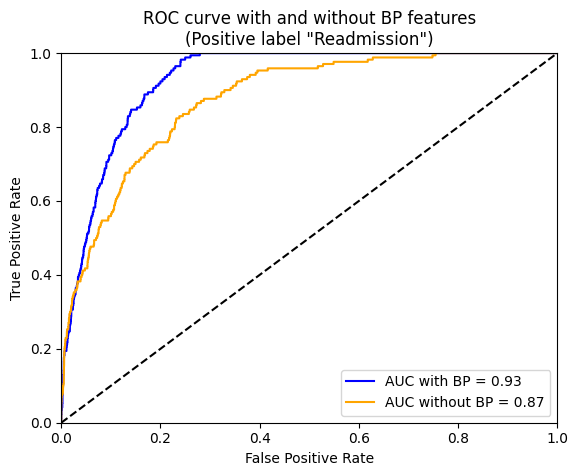

In [24]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
balance = {0:1,1:500}
classifier = RandomForestClassifier(max_depth = 6, n_estimators = 1000, class_weight=balance)
classifier.fit(X, y)
probs = classifier.predict_proba(X)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y, preds)
roc_auc = metrics.auc(fpr, tpr)
classifier.fit(X_nobp, y)
probs_n = classifier.predict_proba(X_nobp)
preds_n = probs_n[:,1]
fpr_n, tpr_n, threshold = metrics.roc_curve(y, preds_n)
roc_auc_n = metrics.auc(fpr_n, tpr_n)
# method I: plt
import matplotlib.pyplot as plt
plt.title('ROC curve with and without BP features\n(Positive label "Readmission")')
plt.plot(fpr, tpr, 'b', label = 'AUC with BP = %0.2f' % roc_auc)
plt.plot(fpr_n, tpr_n, 'orange', label = 'AUC without BP = %0.2f' % roc_auc_n)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.show()
plt.savefig('ROC_compare.png')

In [29]:
from scipy import interp
import matplotlib.patches as patches
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
balance = {0:1,1:500}
#cv = StratifiedKFold(n_splits=5)
classifier = RandomForestClassifier(max_depth = 6, n_estimators = 1000, class_weight=balance, random_state=10)
#clf = RandomForestClassifier(random_state=random_state)
cv = StratifiedKFold(n_splits=10,shuffle=False)
# plot arrows
fig1 = plt.figure(figsize=[6,6])
ax1 = fig1.add_subplot(111,aspect = 'equal')
#ax1.add_patch(
#    patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5)
#    )
#ax1.add_patch(
#    patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5)
#    )

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
#i = 1
for train,test in cv.split(X,y):
    prediction = classifier.fit(X.iloc[train],y.iloc[train]).predict_proba(X.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    #plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    #i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=1)

tprs_n = []
aucs_n = []
mean_fpr_n = np.linspace(0,1,100)
#i = 1
for train,test in cv.split(X_nobp,y):
    prediction_n = classifier.fit(X_nobp.iloc[train],y.iloc[train]).predict_proba(X_nobp.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction_n[:, 1])
    tprs_n.append(interp(mean_fpr_n, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs_n.append(roc_auc)
    #plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    #i= i+1

#plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr_n = np.mean(tprs_n, axis=0)
mean_auc_n = auc(mean_fpr_n, mean_tpr_n)
std_auc_n = np.std(aucs_n)
plt.plot(mean_fpr_n, mean_tpr_n, color='orange',
         label=r'Mean ROC WITHOUT BP (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_n, std_auc_n),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve with and without BP features')
plt.legend(loc="lower right")
#plt.text(0.32,0.7,'More accurate area',fontsize = 12)
#plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.savefig('final_Mean_ROC.png')
#plt.show()

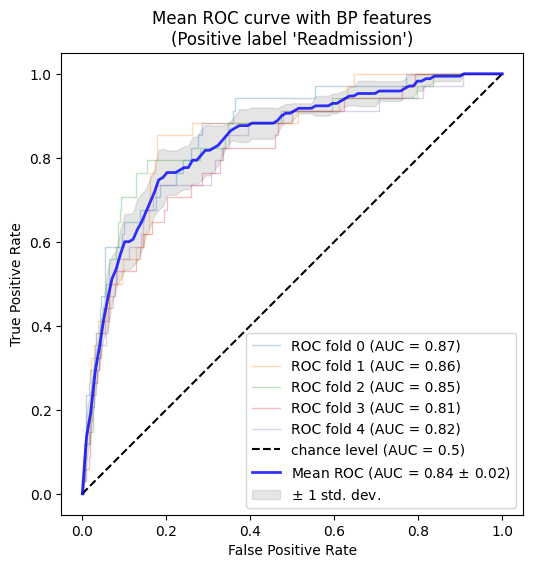

In [111]:
import matplotlib.pyplot as plt

from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

balance = {0:1,1:300}
cv = StratifiedKFold(n_splits=5)
classifier = LogisticRegression(C=0.1, penalty='l2', solver='liblinear', class_weight=balance)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X.loc[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.loc[test],
        y[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with BP features\n(Positive label 'Readmission')",
)
ax.axis("square")
ax.legend(loc="lower right")
#plt.show()
plt.savefig('Mean_ROC_bp.png')

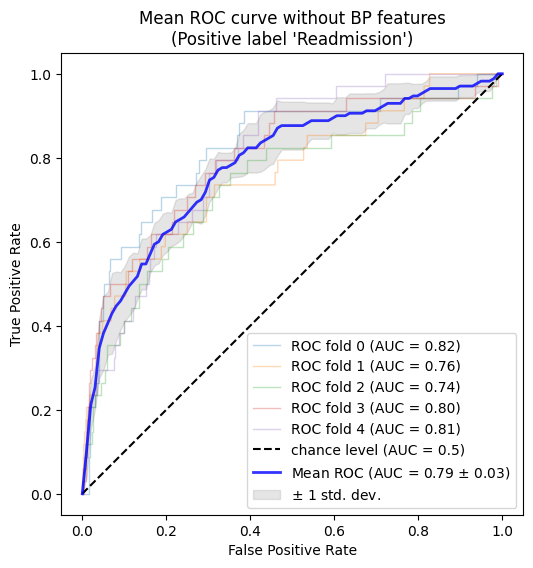

In [112]:
import matplotlib.pyplot as plt

from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

balance = {0:1,1:300}
cv = StratifiedKFold(n_splits=5)
classifier = LogisticRegression(C=0.1, penalty='l2', solver='liblinear', class_weight=balance)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X_nobp, y)):
    classifier.fit(X_nobp.loc[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X_nobp.loc[test],
        y[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve without BP features\n(Positive label 'Readmission')",
)
ax.axis("square")
ax.legend(loc="lower right")
#plt.show()
plt.savefig('Mean_ROC_wo_bp.png')

In [ ]:
#for Random Forest
y_predRF_c5 = RF_c5.predict_proba(X_test).T[1]
fprRf5, tprRf5, threshRf5 = roc_curve(y_test, y_predRF_c5)
roc_auc_rf5= roc_auc_score(y_test, y_predRF_c5)

y_predRF_c2 = RF_c2.predict_proba(X_test).T[1]
fprRf2, tprRf2, threshRf2 = roc_curve(y_test, y_predRF_c2)
roc_auc_rf2= roc_auc_score(y_test, y_predRF_c2)

y_predRF_c3 = RF_c3.predict_proba(X_test).T[1]
fprRf3, tprRf3, threshRf3 = roc_curve(y_test, y_predRF_c3)
roc_auc_rf3= roc_auc_score(y_test, y_predRF_c3)

y_predRF_c10 = RF_c10.predict_proba(X_test).T[1]
fprRf10, tprRf10, threshRf10 = roc_curve(y_test, y_predRF_c10)
roc_auc_rf10= roc_auc_score(y_test, y_predRF_c10)

fig = plt.figure(figsize=(12,8))
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fprRf2, tprRf2, label='cost ratio 200 (AUC = %0.3f)' % roc_auc_rf2) 
plt.plot(fprRf3, tprRf3, label='cost ratio 300 (AUC = %0.3f)' % roc_auc_rf3) 
plt.plot(fprRf5, tprRf5, label='cost ratio 500 (AUC = %0.3f)' % roc_auc_rf5) 
plt.plot(fprRf10, tprRf10, label='cost ratio 1000 (AUC = %0.3f)' % roc_auc_rf10) 

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Comparison of Different Models with BP features', fontsize = 15)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right');
plt.savefig('ROC_wo_bp.png')
#plt.show()

In [31]:
def display_summary(true,pred):
    tn, fp, fn, tp = confusion_matrix(true,pred).ravel()
    print('confusion matrix')
    print(np.array([[tp,fp],[fn,tn]]))
    print('sensitivity is %f',1.*tp/(tp+fn))
    print('specificity is %f',1.*tn/(tn+fp))
    print('accuracy is %f',1.*(tp+tn)/(tp+tn+fp+fn))
    print('balanced accuracy is %',1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp)))

In [ ]:
from sklearn.model_selection import LeaveOneOut
# Define the balance dictionary
balance = {0: 1, 1: 500}

# Initialize RandomForestClassifier parameters
max_depth = 6
n_estimators = 1000
random_state = 10

# Initialize the RandomForestClassifier
RF_c5 = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=random_state, class_weight=balance)
loo = LeaveOneOut()
results = np.empty(len(X))


for i, (train_index, test_index) in enumerate(loo.split(X)):
    print(i)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    RF_c5.fit(X_train, y_train)

    y_probabilities = RF_c5.predict_proba(X_test)
    results[i] = y_probabilities[:, 1][0]  # Access probabilities for class 1 (positive class) in each iteration
    #print(results[i])



In [52]:
with open('looresults.csv', 'w') as file:
    for item in results:
        file.write(f'{item},')

In [65]:
# Get the number of samples
num_samples = len(X)

# Initialize variables to store results
custom_threshold = [round(i, 2) for i in range(5, 90, 5)]
custom_threshold = [x / 100 for x in custom_threshold]

lst_bala_accu = []
lst_preci = []
lst_exp_cost = []
        
# Compute confusion matrix for each threshold
for i in custom_threshold:
    y_custom_predictions = (results > i).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, y_custom_predictions).ravel()
    ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
    preci = tp/(tp + fp)
    cos = (565.*fn + 1.*fp)*36
    lst_bala_accu.append(ba)
    lst_preci.append(preci)
    lst_exp_cost.append(cos)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


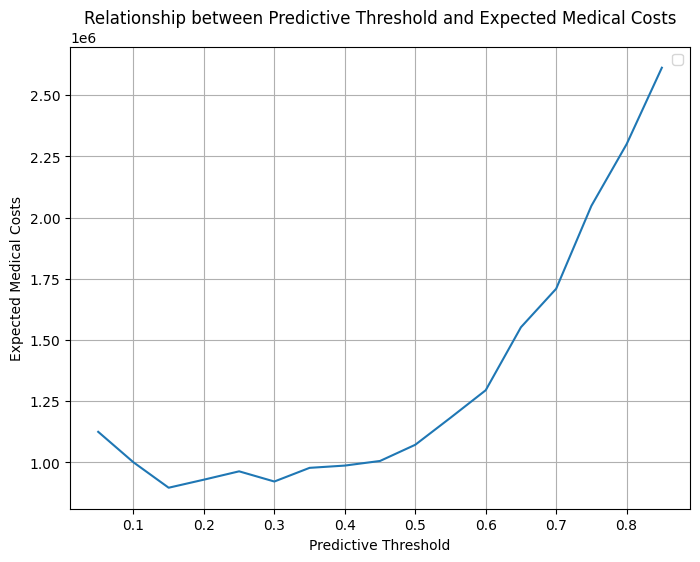

In [66]:
# Plot the relationship between custom threshold and accuracy
plt.figure(figsize=(8, 6))
plt.plot(custom_threshold, lst_exp_cost)
plt.title('Relationship between Predictive Threshold and Expected Medical Costs')
plt.xlabel('Predictive Threshold')
plt.ylabel('Expected Medical Costs')
#plt.xticks(custom_threshold)
plt.legend()
plt.grid(True)
plt.savefig('predictive_threshold_cost.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


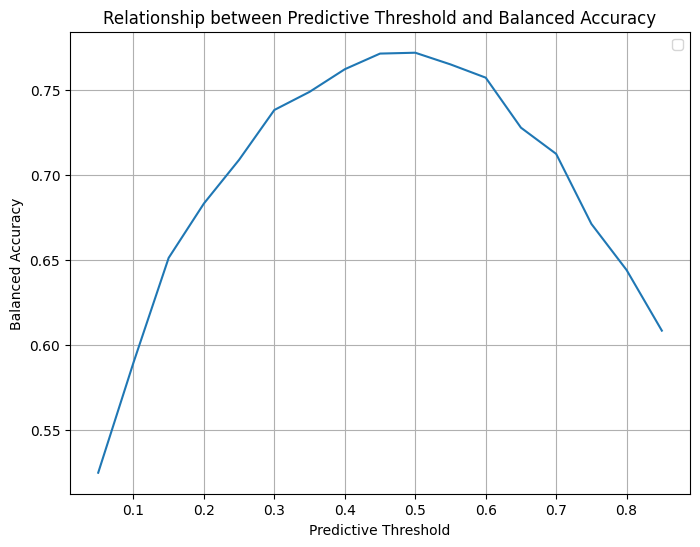

In [67]:
# Plot the relationship between custom threshold and accuracy
plt.figure(figsize=(8, 6))
plt.plot(custom_threshold, lst_bala_accu)
plt.title('Relationship between Predictive Threshold and Balanced Accuracy')
plt.xlabel('Predictive Threshold')
plt.ylabel('Balanced Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('predictive_threshold_balanced_accuracy.png')

In [31]:
balance = {0:1,1:500}
RF_c5 = RandomForestClassifier(max_depth = 6, n_estimators = 1000, random_state = 10, class_weight=balance)
RF_c5.fit(X, y)
# Get probability estimates for each class
y_probabilities = RF_c5.predict_proba(X)

# Set your custom threshold (e.g., 0.7)
custom_threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
lst_bala_accu = []
lst_exp_cost = []
lst_preci = []
for i in custom_threshold:
# Adjust predictions based on the threshold
    y_custom_predictions = (y_probabilities[:, 1] > i).astype(int)
    
    
    tn, fp, fn, tp = confusion_matrix(y, y_custom_predictions).ravel()
    ba = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
    preci = tp/(tp + fp)
    cos = (565.*fn + 1.*fp)*36
    lst_bala_accu.append(ba)
    lst_preci.append(preci)
    lst_exp_cost.append(cos)
        #print(np.mean(lst_bala_accu_stratified))
        #lis.append([i,j,np.mean(lst_spe_stratified),np.mean(lst_sens_stratified),np.mean(lst_bala_accu_stratified),
                    #np.mean(lst_pre),np.mean(lst_npv),np.mean(lst_exp_cost)])
#lis_lr10 = pd.DataFrame(lis)
#df_lr10 = lis_lr10.sort_values(by=[4], ascending=False)
#print(df_lr10.head(1))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


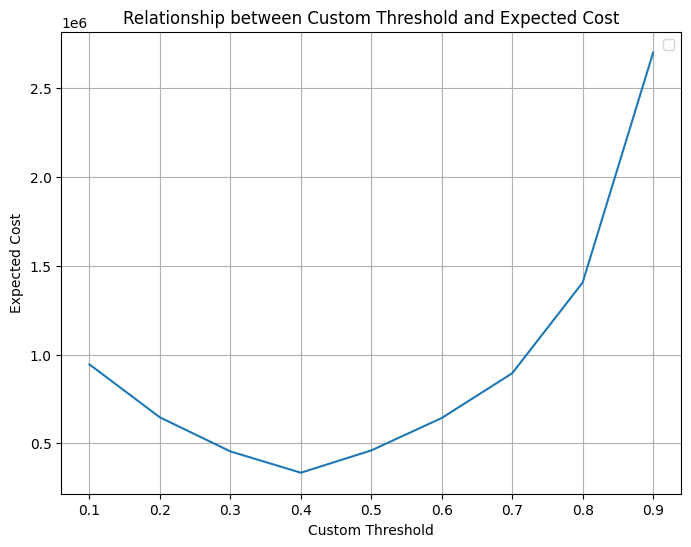

In [32]:
# Plot the relationship between custom threshold and accuracy
plt.figure(figsize=(8, 6))
plt.plot(custom_threshold, lst_exp_cost)
plt.title('Relationship between Custom Threshold and Expected Cost')
plt.xlabel('Custom Threshold')
plt.ylabel('Expected Cost')
plt.legend()
plt.grid(True)
plt.savefig('custom_threshold_cost.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


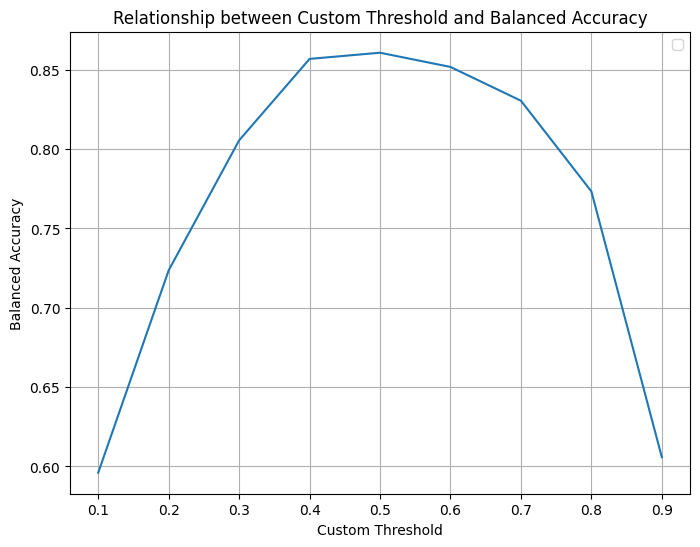

In [33]:
# Plot the relationship between custom threshold and accuracy
plt.figure(figsize=(8, 6))
plt.plot(custom_threshold, lst_bala_accu)
plt.title('Relationship between Custom Threshold and Balanced Accuracy')
plt.xlabel('Custom Threshold')
plt.ylabel('Balanced Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('custom_threshold_balanced_accuracy.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


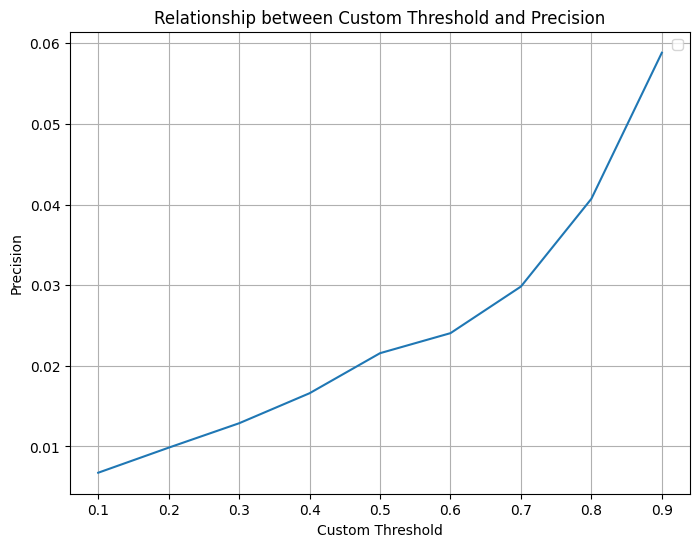

In [20]:
# Plot the relationship between custom threshold and accuracy
plt.figure(figsize=(8, 6))
plt.plot(custom_threshold, lst_preci)
plt.title('Relationship between Custom Threshold and Precision')
plt.xlabel('Custom Threshold')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

In [206]:
X_test.columns

Index(['bp_high24', 'bp_low24', 'bp_high48', 'bp_low48',
       'm9's bmi_prepregnancy',
       'gestational_age (ob_clinician's_final estimate-_calculated)',
       'maternal_age', 'bp_high', 'bp_low', 'If Ibuprofen',
       'If nifedipine acute', 'If nifedipine sustain', 'If Labetalol given IV',
       'If Labetalol given PO', 'If hydralazine'],
      dtype='object')

In [210]:
"\n".join([str(x) for x in X_test.columns])

"bp_high24\nbp_low24\nbp_high48\nbp_low48\nm9's bmi_prepregnancy\ngestational_age (ob_clinician's_final estimate-_calculated)\nmaternal_age\nbp_high\nbp_low\nIf Ibuprofen\nIf nifedipine acute\nIf nifedipine sustain\nIf Labetalol given IV\nIf Labetalol given PO\nIf hydralazine"

In [203]:
" ".join([str(x) for x in X_test.iloc[0].values.tolist()])

'138.0 85.0 122.0 71.0 22.7 41.1 29.0 141.0 89.0 0 0 0 0 0 0'

In [207]:
X_test.iloc[0].values.tolist()

[138.0, 85.0, 122.0, 71.0, 22.7, 41.1, 29.0, 141.0, 89.0, 0, 0, 0, 0, 0, 0]

In [192]:
from sklearn.externals import joblib
joblib.dump(RF_c5, '/Users/Troy-T/Downloads/model.joblib')

['/Users/Troy-T/Downloads/model.joblib']

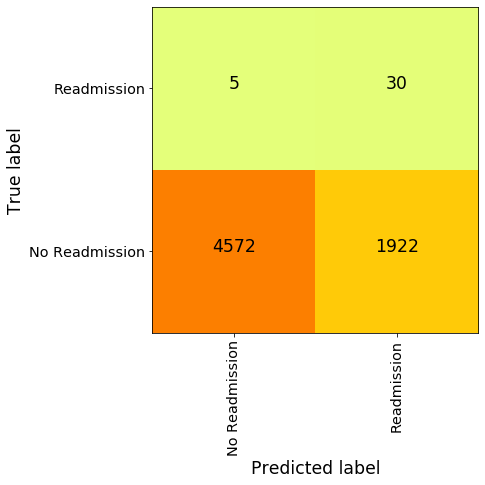

In [181]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, show, savefig, xlim, figure, \
                ylim, legend, boxplot, setp, axes
#Compute confusion matrix values
cMatrix = confusion_matrix(y_true = y_test, y_pred = RF_c10_prd)

#Plot
fig = figure(figsize=(10, 6)) #Create figure space
plt.imshow(cMatrix, cmap=plt.cm.Wistia) #Plot CM

#Add numbers to plot
plt.text(0, 0, '{}'.format(cMatrix[0, 0]), horizontalalignment='center',fontsize = 'xx-large')
plt.text(0, 1, '{}'.format(cMatrix[1, 0]), horizontalalignment='center',fontsize = 'xx-large')
plt.text(1, 0, '{}'.format(cMatrix[0, 1]), horizontalalignment='center',fontsize = 'xx-large')
plt.text(1, 1, '{}'.format(cMatrix[1, 1]), horizontalalignment='center',fontsize = 'xx-large')

#Add Health and Heart Disease labels to each axis
tick_marks = [0,1]
labels = ['No Readmission', 'Readmission']
plt.xticks(tick_marks, labels, rotation=90,fontsize = 'x-large')
plt.ylim([-0.5,1.5])
plt.yticks(tick_marks, labels,fontsize = 'x-large')

#Add axis labels
plt.ylabel('True label',fontsize = 'xx-large')
plt.xlabel('Predicted label',fontsize = 'xx-large')
plt.show()

In [672]:
olddffff = olddffff.replace('<5', 5)

In [673]:
olddffff['alt_(sgpt)_fst_vlu']=olddffff['alt_(sgpt)_fst_vlu'].fillna(0)
olddffff['alt_(sgpt)_mx_vlu']=olddffff['alt_(sgpt)_mx_vlu'].fillna(0)
olddffff['alt_(sgpt)_dsc_vlu']=olddffff['alt_(sgpt)_dsc_vlu'].fillna(0)
olddffff['ALT max']=olddffff[['alt_(sgpt)_fst_vlu','alt_(sgpt)_mx_vlu','alt_(sgpt)_dsc_vlu']].max(axis=1)

In [674]:
olddffff['ast_(sgot)_fst_vlu']=olddffff['ast_(sgot)_fst_vlu'].fillna(0)
olddffff['ast_(sgot)_mx_vlu']=olddffff['ast_(sgot)_mx_vlu'].fillna(0)
olddffff['ast_(sgot)_dsc_vlu']=olddffff['ast_(sgot)_dsc_vlu'].fillna(0)
olddffff['AST max']=olddffff[['ast_(sgot)_fst_vlu','ast_(sgot)_mx_vlu','ast_(sgot)_dsc_vlu']].max(axis=1)

In [676]:
olddffff['If ALT normal']=(olddffff['ALT max']<66)

In [677]:
olddffff['If AST normal']=(olddffff['AST max']<64)

In [679]:
olddffff['If ALT normal']=olddffff['If ALT normal']*1
olddffff['If AST normal']=olddffff['If AST normal']*1
olddffff.head()

,mother's_mrn,mother's_dob,maternal_age,date of_admission,time of_admission,date of_birth,time of_birth,discharge_date,Postpartum days,Total Days of Admission,...,bp_high24,bp_low24,labor_time_y,bp_high48,bp_low48,labor_time,ALT max,AST max,If ALT normal,If AST normal
0,753717,1988-06-17,21.0,2009-01-01,645,2009-01-01,1500,2009-01-03,2.0,2.0,...,121,65,2009-01-01 15:24:00,107,67,2009-01-02 22:19:00,0,0.0,1,1
1,773792,1993-05-18,16.0,2009-01-01,1027,2009-01-01,1412,2009-01-03,2.0,2.0,...,144,63,2009-01-01 16:29:00,129,76,2009-01-03 00:06:00,0,0.0,1,1
2,780226,1981-12-08,27.0,2009-01-01,1557,2009-01-03,1449,2009-01-05,2.0,4.0,...,141,75,2009-01-03 15:12:00,139,89,2009-01-04 16:08:00,0,0.0,1,1
3,63811,1970-07-13,39.0,2009-01-02,1838,2009-01-06,819,NaT,NaN,NaN,...,159,92,2009-01-06 11:54:00,131,80,2009-01-07 18:09:00,10,13.0,1,1
4,142638,1980-05-31,29.0,2009-01-02,700,2009-01-02,2206,2009-01-04,2.0,2.0,...,122,51,2009-01-02 22:39:00,125,88,2009-01-04 09:30:00,0,0.0,1,1


In [680]:
olddflabmed = pd.merge(olddffff, Mdata1, on=["mother's_mrn"])

In [684]:
olddflabmed_key = olddflabmed[['READMIT_ ADM_DATE_TIME_1','READMIT_ ADM_DATE_TIME_2','bp_high24','bp_low24','bp_high48','bp_low48',"m9's bmi_prepregnancy","gestational_age (ob_clinician's_final estimate-_calculated)",'maternal_age', 'bp_high', 'bp_low','If Ibuprofen', 'If nifedipine acute', 'If nifedipine sustain', 'If Labetalol given IV', 'If Labetalol given PO', 'If hydralazine', 'If ALT normal', 'If AST normal']]

In [685]:
olddflabmed_key = olddflabmed_key.replace('.', np.nan)
olddflabmed_key.dropna(subset=['bp_high24','bp_low24','bp_high48','bp_low48',"m9's bmi_prepregnancy","gestational_age (ob_clinician's_final estimate-_calculated)",'maternal_age', 'bp_high', 'bp_low','If Ibuprofen', 'If nifedipine acute', 'If nifedipine sustain', 'If Labetalol given IV', 'If Labetalol given PO', 'If hydralazine', 'If ALT normal', 'If AST normal'], how='any', axis=0, inplace = True)
print(olddflabmed_key.shape)
olddflabmed_key.head()
olddflabmed_key.info()

(21037, 19)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21037 entries, 0 to 21209
Data columns (total 19 columns):
 #   Column                                                       Non-Null Count  Dtype         
---  ------                                                       --------------  -----         
 0   READMIT_ ADM_DATE_TIME_1                                     108 non-null    datetime64[ns]
 1   READMIT_ ADM_DATE_TIME_2                                     4 non-null      datetime64[ns]
 2   bp_high24                                                    21037 non-null  int64         
 3   bp_low24                                                     21037 non-null  object        
 4   bp_high48                                                    21037 non-null  int64         
 5   bp_low48                                                     21037 non-null  object        
 6   m9's bmi_prepregnancy                                        21037 non-null  float64       
 7   g

In [686]:
olddflabmed_key['READMIT_ ADM_DATE_TIME_1'].fillna(0,inplace=True)
olddflabmed_key['READMIT_ ADM_DATE_TIME_1']=olddflabmed_key['READMIT_ ADM_DATE_TIME_1'].apply(lambda x: 1 if x!=0 else 0)
olddflabmed_key['READMIT_ ADM_DATE_TIME_2'].fillna(0,inplace=True)
olddflabmed_key['READMIT_ ADM_DATE_TIME_2']=olddflabmed_key['READMIT_ ADM_DATE_TIME_2'].apply(lambda x: 1 if x!=0 else 0)
# change True False to 1 0
olddflabmed_key['If Ibuprofen'] = olddflabmed_key['If Ibuprofen']*1
olddflabmed_key['If nifedipine acute'] = olddflabmed_key['If nifedipine acute']*1
olddflabmed_key['If nifedipine sustain'] = olddflabmed_key['If nifedipine sustain']*1
olddflabmed_key['If Labetalol given IV'] = olddflabmed_key['If Labetalol given IV']*1
olddflabmed_key['If Labetalol given PO'] = olddflabmed_key['If Labetalol given PO']*1
olddflabmed_key['If hydralazine'] = olddflabmed_key['If hydralazine']*1
olddflabmed_key.head(50)

,READMIT_ ADM_DATE_TIME_1,READMIT_ ADM_DATE_TIME_2,bp_high24,bp_low24,bp_high48,bp_low48,m9's bmi_prepregnancy,gestational_age (ob_clinician's_final estimate-_calculated),maternal_age,bp_high,bp_low,If Ibuprofen,If nifedipine acute,If nifedipine sustain,If Labetalol given IV,If Labetalol given PO,If hydralazine,If ALT normal,If AST normal
0,0,0,121,65,107,67,22.3,40.7,21.0,109,61,0,0,0,0,0,0,1,1
1,0,0,144,63,129,76,22.5,38.6,16.0,104,60,0,0,0,0,0,0,1,1
2,0,0,141,75,139,89,31.4,38.1,27.0,134,81,0,0,0,0,0,0,1,1
3,0,0,127,69,131,84,30.9,39.1,29.0,110,64,0,0,0,0,0,0,1,1
4,0,0,159,92,131,80,47.6,38.4,39.0,175,103,0,0,0,0,0,0,1,1
5,0,0,122,51,125,88,22.2,39.9,29.0,123,80,0,0,0,0,0,0,1,1
6,0,0,121,73,122,76,21.3,38.1,30.0,113,66,0,0,0,0,0,0,1,1
7,0,0,132,71,121,78,24.3,38.1,35.0,130,70,0,0,0,0,0,0,1,1
8,0,0,140,92,126,84,25.7,41.1,24.0,139,82,0,0,0,0,0,0,1,1
9,0,0,155,97,118,69,27.4,40.1,26.0,131,82,0,0,0,0,0,0,1,1


In [687]:
readmit = np.logical_or(olddflabmed_key['READMIT_ ADM_DATE_TIME_1'] > 0, olddflabmed_key['READMIT_ ADM_DATE_TIME_2'] > 0)
olddflabmed_key['Readmit'] = readmit
# change True False to 1 0
olddflabmed_key['Readmit'] = olddfwithmed_key['Readmit']*1
olddflabmed_key.head()

,READMIT_ ADM_DATE_TIME_1,READMIT_ ADM_DATE_TIME_2,bp_high24,bp_low24,bp_high48,bp_low48,m9's bmi_prepregnancy,gestational_age (ob_clinician's_final estimate-_calculated),maternal_age,bp_high,bp_low,If Ibuprofen,If nifedipine acute,If nifedipine sustain,If Labetalol given IV,If Labetalol given PO,If hydralazine,If ALT normal,If AST normal,Readmit
0,0,0,121,65,107,67,22.3,40.7,21.0,109,61,0,0,0,0,0,0,1,1,0
1,0,0,144,63,129,76,22.5,38.6,16.0,104,60,0,0,0,0,0,0,1,1,0
2,0,0,141,75,139,89,31.4,38.1,27.0,134,81,0,0,0,0,0,0,1,1,0
3,0,0,127,69,131,84,30.9,39.1,29.0,110,64,0,0,0,0,0,0,1,1,0
4,0,0,159,92,131,80,47.6,38.4,39.0,175,103,0,0,0,0,0,0,1,1,0


In [701]:
X = olddflabmed_key.drop(['READMIT_ ADM_DATE_TIME_1','READMIT_ ADM_DATE_TIME_2','Readmit'],axis=1)
y = olddflabmed_key.Readmit

In [702]:
# Split the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 10)

In [152]:
#Random Forest
balance = {0:1,1:500}
RF_c = RandomForestClassifier(max_depth = 5, n_estimators = 1000, random_state = 10, class_weight=balance)
RF_c.fit(X_train, y_train)
y_predRF_c = RF_c.predict_proba(X_test).T[1]
RF_c_score= roc_auc_score(y_test,y_predRF_c)
RF_c_prd=RF_c.predict(X_test)
display_summary(y_test, RF_c_prd)

confusion matrix
[[  30 1678]
 [   5 4816]]
sensitivity is %f 0.8571428571428571
specificity is %f 0.7416076378195258
accuracy is %f 0.7422269872874866
balanced accuracy is % 0.7993752474811915


In [704]:
balance = {0:1,1:1000}
RF_c = RandomForestClassifier(max_depth = 5, n_estimators = 1000, random_state = 10, class_weight=balance)
RF_c.fit(X_train, y_train)
y_predRF_c = RF_c.predict_proba(X_test).T[1]
RF_c_score= roc_auc_score(y_test,y_predRF_c)
RF_c_prd=RF_c.predict(X_test)
display_summary(y_test, RF_c_prd)

confusion matrix
[[  22 1033]
 [   2 3151]]
sensitivity is %f 0.9166666666666666
specificity is %f 0.7531070745697896
accuracy is %f 0.7540399239543726
balanced accuracy is % 0.8348868706182282


In [708]:
balance = {0:1,1:300}
RF_c = RandomForestClassifier(max_depth = 5, n_estimators = 1000,random_state = 10, class_weight=balance)
RF_c.fit(X_train, y_train)
y_predRF_c = RF_c.predict_proba(X_test).T[1]
RF_c_score= roc_auc_score(y_test,y_predRF_c) 
RF_c_prd=RF_c.predict(X_test)
display_summary(y_test, RF_c_prd)

confusion matrix
[[  17  543]
 [   7 3641]]
sensitivity is %f 0.7083333333333334
specificity is %f 0.8702198852772467
accuracy is %f 0.8692965779467681
balanced accuracy is % 0.7892766093052901


In [710]:
balance = {0:1,1:200}
RF_c = RandomForestClassifier(max_depth = 5, n_estimators = 1000,random_state = 10, class_weight=balance)
RF_c.fit(X_train, y_train)
y_predRF_c = RF_c.predict_proba(X_test).T[1]
RF_c_score= roc_auc_score(y_test,y_predRF_c) 
RF_c_prd=RF_c.predict(X_test)
display_summary(y_test, RF_c_prd)

confusion matrix
[[  14  435]
 [  10 3749]]
sensitivity is %f 0.5833333333333334
specificity is %f 0.8960325047801148
accuracy is %f 0.8942490494296578
balanced accuracy is % 0.739682919056724


In [ ]:
#Compute confusion matrix values
cMatrix = confusion_matrix(y_true = ytest, y_pred = yhatDround)

#Plot
fig = figure(figsize=(10, 6)) #Create figure space
plt.imshow(cMatrix, cmap=plt.cm.Blues) #Plot CM

#Add numbers to plot
plt.text(0, 0, '{}'.format(cMatrix[0, 0]), horizontalalignment='center',fontsize = 'xx-large')
plt.text(0, 1, '{}'.format(cMatrix[1, 0]), horizontalalignment='center',fontsize = 'xx-large')
plt.text(1, 0, '{}'.format(cMatrix[0, 1]), horizontalalignment='center',fontsize = 'xx-large')
plt.text(1, 1, '{}'.format(cMatrix[1, 1]), horizontalalignment='center',fontsize = 'xx-large')

#Add Health and Heart Disease labels to each axis
tick_marks = [0,1]
labels = ['Healthy', 'Heart Disease']
plt.xticks(tick_marks, labels, rotation=90,fontsize = 'x-large')
plt.ylim([-0.5,1.5])
plt.yticks(tick_marks, labels,fontsize = 'x-large')

#Add axis labels
plt.ylabel('True label',fontsize = 'xx-large')
plt.xlabel('Predicted label',fontsize = 'xx-large')
plt.show()

In [705]:
feature_importances = pd.DataFrame(RF_c.feature_importances_, index = X.columns, columns=['importance']).sort_values('importance', ascending=False)

In [706]:
feature_importances

,importance
bp_high48,0.214495
bp_high24,0.141736
bp_high,0.140690
gestational_age (ob_clinician's_final estimate-_calculated),0.109239
bp_low24,0.090526
bp_low48,0.090183
bp_low,0.088390
m9's bmi_prepregnancy,0.059826
maternal_age,0.056254
If Ibuprofen,0.004259


Feature: 0, Score: 0.14174
Feature: 1, Score: 0.09053
Feature: 2, Score: 0.21449
Feature: 3, Score: 0.09018
Feature: 4, Score: 0.05983
Feature: 5, Score: 0.10924
Feature: 6, Score: 0.05625
Feature: 7, Score: 0.14069
Feature: 8, Score: 0.08839
Feature: 9, Score: 0.00426
Feature: 10, Score: 0.00055
Feature: 11, Score: 0.00001
Feature: 12, Score: 0.00222
Feature: 13, Score: 0.00035
Feature: 14, Score: 0.00011
Feature: 15, Score: 0.00092
Feature: 16, Score: 0.00023


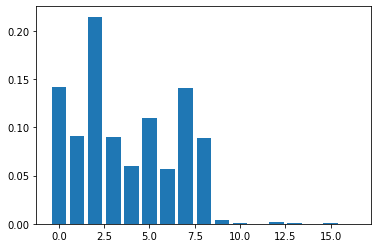

In [707]:
from matplotlib import pyplot
# get importance
importance = RF_c.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [453]:
Hyper = pd.ExcelFile('diagnose.xlsx')
H1 = pd.read_excel(Hyper, '09-11')
H2 = pd.read_excel(Hyper, '11-15 non preeclampsia dx')
H3 = pd.read_excel(Hyper, '11-15 preeclampsia')

In [454]:
oldnewps = oldps.append(newps)

In [455]:
oldnewps.count()

32645

In [456]:
oldnewpsdf = oldnewps.to_frame()

In [457]:
oldnewpsdf['MRN'] = oldnewpsdf["mother's_mrn"]

In [458]:
H1

,HSP_ACCOUNT_NAME,Unnamed: 1,MRN,DX_NAME,ADM_DATE_TIME
0,"PETE,NICOLE C",NaN,520851,"Mild or unspecified pre-eclampsia, with delivery",2009-01-02 06:14:00
1,"WIRE,ASHLEY M",NaN,780829,"Transient hypertension of pregnancy, with deli...",2009-01-02 08:00:00
2,"OSWALD,MELISSA A",NaN,575505,"Severe pre-eclampsia, with delivery",2009-01-02 08:01:00
3,"KAPANKE,DANIELLE S",NaN,786261,"Mild or unspecified pre-eclampsia, antepartum",2009-01-02 15:10:00
4,"LATIN,TASHA M",NaN,792428,Pre-eclampsia or eclampsia superimposed on pre...,2009-01-02 18:01:00
...,...,...,...,...,...
2460,"RUEF,KRYSTAL J",NaN,844654,"Mild or unspecified pre-eclampsia, with delivery",2011-12-28 16:35:00
2461,"RILEY,JESSICA T",NaN,435238,"Transient hypertension of pregnancy, with deli...",2011-12-28 23:15:00
2462,"TWUMASI,SHERRI S",NaN,594086,Benign essential hypertension antepartum,2011-12-30 00:00:00
2463,"GREEN,RASHANNA J",NaN,589601,Unspecified hypertension antepartum(642.93),2011-12-30 12:00:00


In [459]:
H1new = H1[['MRN','DX_NAME']]

In [460]:
H2

,PAT_NAME,Meriter MRN,BIRTH_DATE,DX_NAME
0,"CUTHBERTSON,AMY L",768615,2011-03-15 03:10:00,Benign essential hypertension with delivery
1,"CLEFISCH,HEATHER L",698050,2011-03-30 10:58:00,Benign essential hypertension with delivery
2,"MCLAUGHLIN,LYNDSEY S",524782,2011-03-31 20:34:00,Benign essential hypertension with delivery
3,"ADU,MARY",819449,2011-04-10 19:11:00,Benign essential hypertension with delivery
4,"CANFIELD,NICOLE A",699788,2011-04-13 14:18:00,Benign essential hypertension with delivery
...,...,...,...,...
2104,"KLESS,NICOLE L",1053835,2015-01-30 16:48:00,"Unspecified hypertension, with delivery, with ..."
2105,"FAUST,SHARON E",MWH8290,2015-09-06 21:56:00,"Transient hypertension of pregnancy, with deli..."
2106,"VOGTS-DOBBINS,HEATHER R",6022532,2015-03-16 15:00:00,"Unspecified hypertension, with delivery, with ..."
2107,"GERLEMAN,KENDRA M",6016099,2015-03-24 12:08:00,"Unspecified hypertension, with delivery, with ..."


In [461]:
H2['MRN'] = H2['Meriter MRN']

In [462]:
H2new = H2[['MRN','DX_NAME']]

In [472]:
H2new

,MRN,DX_NAME
0,768615,Benign essential hypertension with delivery
1,698050,Benign essential hypertension with delivery
2,524782,Benign essential hypertension with delivery
3,819449,Benign essential hypertension with delivery
4,699788,Benign essential hypertension with delivery
...,...,...
2104,1053835,"Unspecified hypertension, with delivery, with ..."
2105,MWH8290,"Transient hypertension of pregnancy, with deli..."
2106,6022532,"Unspecified hypertension, with delivery, with ..."
2107,6016099,"Unspecified hypertension, with delivery, with ..."


In [463]:
H3

,PAT_NAME,PAT_MRN_ID,Meriter MRN,BIRTH_DATE,LOC_ID,LOC_NAME,DX_NAME
0,"MATTHEWS,ENDIA R",95768387,660471.0,2015-09-15 19:03:00,101401,UPH MERITER HOSPITAL,Pre-eclampsia or eclampsia superimposed on pre...
1,"PETERSON,RACHAEL L",96210111,NaN,2015-09-24 10:40:00,101401,UPH MERITER HOSPITAL,"Severe pre-eclampsia, with delivery"
2,"STADEN,ROSE A",96000894,6026339.0,2015-09-25 04:58:00,101401,UPH MERITER HOSPITAL,"Mild or unspecified pre-eclampsia, with delivery"
3,"MORENO ESPINOSA,ARACELI",95808078,768990.0,2015-09-25 09:31:00,101401,UPH MERITER HOSPITAL,"Mild or unspecified pre-eclampsia, with delivery"
4,"WALLER,SHERRY S",96075471,814161.0,2015-09-27 01:55:00,101401,UPH MERITER HOSPITAL,Pre-eclampsia or eclampsia superimposed on pre...
...,...,...,...,...,...,...,...
1432,"CORRIGAN,LINDSAY S",0,NaN,2019-06-24 19:13:00,101401,UPH MERITER HOSPITAL,Severe pre-eclampsia complicating childbirth
1433,"SELENSKE,ANA I",95968507,869159.0,2019-06-25 06:57:00,101401,UPH MERITER HOSPITAL,"Unspecified pre-eclampsia, complicating childb..."
1434,"HOLME,CORA E",95621925,532984.0,2019-06-25 18:12:00,101401,UPH MERITER HOSPITAL,Severe pre-eclampsia complicating childbirth
1435,"LOBACCARO,SHANNON",97055094,NaN,2019-06-27 05:35:00,101401,UPH MERITER HOSPITAL,"Mild to moderate pre-eclampsia, complicating c..."


In [467]:
H3['MRN'] = H3['PAT_MRN_ID']

In [470]:
H3new = H3[['MRN','DX_NAME']]

In [471]:
H3new

,MRN,DX_NAME
0,95768387,Pre-eclampsia or eclampsia superimposed on pre...
1,96210111,"Severe pre-eclampsia, with delivery"
2,96000894,"Mild or unspecified pre-eclampsia, with delivery"
3,95808078,"Mild or unspecified pre-eclampsia, with delivery"
4,96075471,Pre-eclampsia or eclampsia superimposed on pre...
...,...,...
1432,0,Severe pre-eclampsia complicating childbirth
1433,95968507,"Unspecified pre-eclampsia, complicating childb..."
1434,95621925,Severe pre-eclampsia complicating childbirth
1435,97055094,"Mild to moderate pre-eclampsia, complicating c..."


In [473]:
hyperpsdf1 = H1new.append(H2new)

In [475]:
hyperpsdf1

,MRN,DX_NAME
0,520851,"Mild or unspecified pre-eclampsia, with delivery"
1,780829,"Transient hypertension of pregnancy, with deli..."
2,575505,"Severe pre-eclampsia, with delivery"
3,786261,"Mild or unspecified pre-eclampsia, antepartum"
4,792428,Pre-eclampsia or eclampsia superimposed on pre...
...,...,...
2104,1053835,"Unspecified hypertension, with delivery, with ..."
2105,MWH8290,"Transient hypertension of pregnancy, with deli..."
2106,6022532,"Unspecified hypertension, with delivery, with ..."
2107,6016099,"Unspecified hypertension, with delivery, with ..."


In [476]:
hyperpsdf = hyperpsdf1.append(H3new)

In [477]:
hyperpsdf

,MRN,DX_NAME
0,520851,"Mild or unspecified pre-eclampsia, with delivery"
1,780829,"Transient hypertension of pregnancy, with deli..."
2,575505,"Severe pre-eclampsia, with delivery"
3,786261,"Mild or unspecified pre-eclampsia, antepartum"
4,792428,Pre-eclampsia or eclampsia superimposed on pre...
...,...,...
1432,0,Severe pre-eclampsia complicating childbirth
1433,95968507,"Unspecified pre-eclampsia, complicating childb..."
1434,95621925,Severe pre-eclampsia complicating childbirth
1435,97055094,"Mild to moderate pre-eclampsia, complicating c..."


In [478]:
hypertotal = pd.merge(hyperpsdf, oldnewpsdf, on=['MRN'])

In [479]:
hypertotal = hypertotal.drop_duplicates()

In [480]:
hypertotal

,MRN,DX_NAME,mother's_mrn
0,520851,"Mild or unspecified pre-eclampsia, with delivery",520851
2,780829,"Transient hypertension of pregnancy, with deli...",780829
3,575505,"Severe pre-eclampsia, with delivery",575505
5,575505,"Transient hypertension of pregnancy, with deli...",575505
9,786261,"Mild or unspecified pre-eclampsia, antepartum",786261
...,...,...,...
6645,96443879,"Pre-existing hypertension with pre-eclampsia, ...",96443879
6646,95474970,"Unspecified pre-eclampsia, complicating childb...",95474970
6647,95768111,Severe pre-eclampsia complicating childbirth,95768111
6648,95378877,Severe pre-eclampsia complicating childbirth,95378877


In [484]:
len(hypertotal['MRN'].unique())

3439

In [485]:
hypertotal.loc[hypertotal['DX_NAME'] == 'Unspecified pre-eclampsia, complicating the puerperium']

,MRN,DX_NAME,mother's_mrn
5736,96323168,"Unspecified pre-eclampsia, complicating the pu...",96323168
5810,96102725,"Unspecified pre-eclampsia, complicating the pu...",96102725
5833,96356159,"Unspecified pre-eclampsia, complicating the pu...",96356159
5895,95300603,"Unspecified pre-eclampsia, complicating the pu...",95300603
6039,95496950,"Unspecified pre-eclampsia, complicating the pu...",95496950
6051,95982495,"Unspecified pre-eclampsia, complicating the pu...",95982495
6069,96549368,"Unspecified pre-eclampsia, complicating the pu...",96549368
6119,95596739,"Unspecified pre-eclampsia, complicating the pu...",95596739
6173,96614445,"Unspecified pre-eclampsia, complicating the pu...",96614445
6260,96615323,"Unspecified pre-eclampsia, complicating the pu...",96615323


In [487]:
hypertotal.loc[hypertotal['DX_NAME'] == 'Unspecified hypertension, with delivery']

,MRN,DX_NAME,mother's_mrn
355,464041,"Unspecified hypertension, with delivery",464041
446,798877,"Unspecified hypertension, with delivery",798877
677,205809,"Unspecified hypertension, with delivery",205809
735,363888,"Unspecified hypertension, with delivery",363888
802,793681,"Unspecified hypertension, with delivery",793681
...,...,...,...
5440,633009,"Unspecified hypertension, with delivery",633009
5441,805716,"Unspecified hypertension, with delivery",805716
5442,146898,"Unspecified hypertension, with delivery",146898
5443,883710,"Unspecified hypertension, with delivery",883710


In [488]:
hypertotal['chronic_c'] = hypertotal['DX_NAME'].str.contains('Pre-existing essential hypertension complicating childbirth|Pre-existing essential hypertension complicating pregnancy, third trimester|Pre-existing essential hypertension complicating the puerperium|Unspecified pre-existing hypertension complicating childbirth|Pre-eclampsia or eclampsia superimposed on pre-existing hypertension, with delivery|Benign essential hypertension with delivery|Other pre-existing hypertension, with delivery')

In [491]:
hypertotal['chronic_superc'] = hypertotal['DX_NAME'].str.contains('Pre-existing hypertension with pre-eclampsia, complicating childbirth|Pre-existing hypertension with pre-eclampsia, third trimester|Pre-existing hypertension with pre-eclampsia, unspecified trimester|Pre-existing secondary hypertension complicating childbirth|Pre-eclampsia or eclampsia superimposed on pre-existing hypertension, with delivery')

In [494]:
hypertotal['gest_c'] = hypertotal['DX_NAME'].str.contains('Gestational (pregnancy-induced) hypertension without significant proteinuria, complicating childbirth|Gestational (pregnancy-induced) hypertension without significant proteinuria, first trimester|Gestational (pregnancy-induced) hypertension without significant proteinuria, second trimester|Gestational (pregnancy-induced) hypertension without significant proteinuria, third trimester|Gestational (pregnancy-induced) hypertension without significant proteinuria, unspecified trimester|Transient hypertension of pregnancy, with delivery|Transient hypertension of pregnancy, antepartum')

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [497]:
hypertotal['preunsp_c'] = hypertotal['DX_NAME'].str.contains('Unspecified pre-eclampsia, complicating childbirth|Unspecified pre-eclampsia, complicating the puerperium|Unspecified pre-eclampsia, second trimester|Unspecified pre-eclampsia, third trimester|Unspecified pre-eclampsia, unspecified trimester')

In [498]:
hypertotal['prem_c'] = hypertotal['DX_NAME'].str.contains('Mild or unspecified pre-eclampsia, with delivery|Mild to moderate pre-eclampsia, complicating childbirth|Mild or unspecified pre-eclampsia, antepartum|Mild or unspecified pre-eclampsia, postpartum condition or complication|Mild or unspecified pre-eclampsia, with delivery, with current postpartum complication')

In [499]:
hypertotal['pres_c'] = hypertotal['DX_NAME'].str.contains('Severe pre-eclampsia complicating childbirth|Severe pre-eclampsia, complicating the puerperium|Severe pre-eclampsia, second trimester|Severe pre-eclampsia, third trimester|Severe pre-eclampsia, unspecified trimester|Severe pre-eclampsia, with delivery|Eclampsia complicating labor|Severe pre-eclampsia, antepartum|Severe pre-eclampsia, with delivery, with current postpartum complication|Eclampsia, postpartum condition or complication|Eclampsia, with delivery')

In [500]:
hypertotal['hyunsp_c'] = hypertotal['DX_NAME'].str.contains('Unspecified hypertension, with delivery|Unspecified hypertension, with delivery, with current postpartum complication')

In [501]:
hypertotal

,MRN,DX_NAME,mother's_mrn,chronic_c,chronic_superc,gest_c,preunsp_c,prem_c,pres_c,hyunsp_c
0,520851,"Mild or unspecified pre-eclampsia, with delivery",520851,False,False,False,False,True,False,False
2,780829,"Transient hypertension of pregnancy, with deli...",780829,False,False,True,False,False,False,False
3,575505,"Severe pre-eclampsia, with delivery",575505,False,False,False,False,False,True,False
5,575505,"Transient hypertension of pregnancy, with deli...",575505,False,False,True,False,False,False,False
9,786261,"Mild or unspecified pre-eclampsia, antepartum",786261,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...
6645,96443879,"Pre-existing hypertension with pre-eclampsia, ...",96443879,False,True,False,False,False,False,False
6646,95474970,"Unspecified pre-eclampsia, complicating childb...",95474970,False,False,False,True,False,False,False
6647,95768111,Severe pre-eclampsia complicating childbirth,95768111,False,False,False,False,False,True,False
6648,95378877,Severe pre-eclampsia complicating childbirth,95378877,False,False,False,False,False,True,False


In [490]:
hypertotal['chronic_c'].value_counts()

False    3647
True      452
Name: chronic_c, dtype: int64

In [493]:
hypertotal['chronic_superc'].value_counts()

False    3828
True      271
Name: chronic_superc, dtype: int64

In [496]:
hypertotal['gest_c'].value_counts()

False    3082
True     1017
Name: gest_c, dtype: int64

In [504]:
hypertotal[hypertotal['chronic_superc'] == True]

,MRN,DX_NAME,mother's_mrn,chronic_c,chronic_superc,gest_c,preunsp_c,prem_c,pres_c,hyunsp_c
12,792428,Pre-eclampsia or eclampsia superimposed on pre...,792428,True,True,False,False,False,False,False
20,63811,Pre-eclampsia or eclampsia superimposed on pre...,63811,True,True,False,False,False,False,False
26,662104,Pre-eclampsia or eclampsia superimposed on pre...,662104,True,True,False,False,False,False,False
59,783190,Pre-eclampsia or eclampsia superimposed on pre...,783190,True,True,False,False,False,False,False
100,771932,Pre-eclampsia or eclampsia superimposed on pre...,771932,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
6593,96777775,"Pre-existing hypertension with pre-eclampsia, ...",96777775,False,True,False,False,False,False,False
6598,96861559,"Pre-existing hypertension with pre-eclampsia, ...",96861559,False,True,False,False,False,False,False
6601,95333226,"Pre-existing hypertension with pre-eclampsia, ...",95333226,False,True,False,False,False,False,False
6637,96200230,"Pre-existing hypertension with pre-eclampsia, ...",96200230,False,True,False,False,False,False,False


In [507]:
hypertotal

,MRN,DX_NAME,mother's_mrn,chronic_c,chronic_superc,gest_c,preunsp_c,prem_c,pres_c,hyunsp_c
0,520851,"Mild or unspecified pre-eclampsia, with delivery",520851,False,False,False,False,True,False,False
2,780829,"Transient hypertension of pregnancy, with deli...",780829,False,False,True,False,False,False,False
3,575505,"Severe pre-eclampsia, with delivery",575505,False,False,False,False,False,True,False
5,575505,"Transient hypertension of pregnancy, with deli...",575505,False,False,True,False,False,False,False
9,786261,"Mild or unspecified pre-eclampsia, antepartum",786261,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...
6645,96443879,"Pre-existing hypertension with pre-eclampsia, ...",96443879,False,True,False,False,False,False,False
6646,95474970,"Unspecified pre-eclampsia, complicating childb...",95474970,False,False,False,True,False,False,False
6647,95768111,Severe pre-eclampsia complicating childbirth,95768111,False,False,False,False,False,True,False
6648,95378877,Severe pre-eclampsia complicating childbirth,95378877,False,False,False,False,False,True,False


In [510]:
hypertotal.loc[hypertotal['MRN'] == 96443879]

,MRN,DX_NAME,mother's_mrn,chronic_c,chronic_superc,gest_c,preunsp_c,prem_c,pres_c,hyunsp_c
6645,96443879,"Pre-existing hypertension with pre-eclampsia, ...",96443879,False,True,False,False,False,False,False


In [514]:
hypertotal=hypertotal.drop(columns=['DX_NAME'])

In [516]:
hypertotal=hypertotal.drop_duplicates()

In [517]:
hypertotal

,MRN,mother's_mrn,chronic_c,chronic_superc,gest_c,preunsp_c,prem_c,pres_c,hyunsp_c
0,520851,520851,False,False,False,False,True,False,False
2,780829,780829,False,False,True,False,False,False,False
3,575505,575505,False,False,False,False,False,True,False
5,575505,575505,False,False,True,False,False,False,False
9,786261,786261,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...
6645,96443879,96443879,False,True,False,False,False,False,False
6646,95474970,95474970,False,False,False,True,False,False,False
6647,95768111,95768111,False,False,False,False,False,True,False
6648,95378877,95378877,False,False,False,False,False,True,False


In [519]:
hypertotal['chronic_c'] = hypertotal['chronic_c']*1
hypertotal['chronic_superc'] = hypertotal['chronic_superc']*1
hypertotal['gest_c'] = hypertotal['gest_c']*1
hypertotal['preunsp_c'] = hypertotal['preunsp_c']*1
hypertotal['prem_c'] = hypertotal['prem_c']*1
hypertotal['pres_c'] = hypertotal['pres_c']*1
hypertotal['hyunsp_c'] = hypertotal['hyunsp_c']*1

In [520]:
hypertotal

,MRN,mother's_mrn,chronic_c,chronic_superc,gest_c,preunsp_c,prem_c,pres_c,hyunsp_c
0,520851,520851,0,0,0,0,1,0,0
2,780829,780829,0,0,1,0,0,0,0
3,575505,575505,0,0,0,0,0,1,0
5,575505,575505,0,0,1,0,0,0,0
9,786261,786261,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
6645,96443879,96443879,0,1,0,0,0,0,0
6646,95474970,95474970,0,0,0,1,0,0,0
6647,95768111,95768111,0,0,0,0,0,1,0
6648,95378877,95378877,0,0,0,0,0,1,0


In [521]:
hypertotal[hypertotal.duplicated(['MRN'], keep=False)]

,MRN,mother's_mrn,chronic_c,chronic_superc,gest_c,preunsp_c,prem_c,pres_c,hyunsp_c
3,575505,575505,0,0,0,0,0,1,0
5,575505,575505,0,0,1,0,0,0,0
12,792428,792428,1,1,0,0,0,0,0
16,792428,792428,0,0,0,0,0,0,0
23,673523,673523,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
5059,645065,645065,0,0,0,0,0,0,1
5113,342560,342560,0,0,1,0,0,0,0
5114,342560,342560,0,0,0,0,0,0,1
5296,762479,762479,0,0,1,0,0,0,0


In [524]:
hyperfinal = hypertotal.groupby(['MRN']).sum()

In [529]:
hyperfinal = hyperfinal.reset_index()

In [530]:
hyperfinal.loc[hyperfinal['MRN'] == 575505]

,MRN,chronic_c,chronic_superc,gest_c,preunsp_c,prem_c,pres_c,hyunsp_c
620,575505,0,0,1,0,0,1,0


In [531]:
len(hyperfinal[(hyperfinal['chronic_c']>0) & (hyperfinal['gest_c']>0)])

49

In [550]:
hyperfinal['chronic_p'] = np.where(((hyperfinal['chronic_c']==1) & (hyperfinal['chronic_superc']+hyperfinal['preunsp_c']+hyperfinal['prem_c']+hyperfinal['pres_c']==0)), 1, 0)
hyperfinal['chronic_superp'] = np.where(((hyperfinal['chronic_superc']==1) | ((hyperfinal['preunsp_c']+hyperfinal['prem_c']+hyperfinal['pres_c']>=1)&hyperfinal['chronic_c']==1)), 1, 0)
hyperfinal['gest_p'] = np.where(((hyperfinal['gest_c']==1) & (hyperfinal['chronic_c']+hyperfinal['chronic_superc']+hyperfinal['preunsp_c']+hyperfinal['prem_c']+hyperfinal['pres_c']==0)), 1, 0)
hyperfinal['pre_p'] = np.where(((hyperfinal['chronic_c']+hyperfinal['chronic_superc']==0) & (hyperfinal['preunsp_c']+hyperfinal['prem_c']+hyperfinal['pres_c']>0)), 1, 0)
hyperfinal['pres_p'] = np.where(((hyperfinal['pre_p']==1) & (hyperfinal['pres_c']==1)), 1, 0)
hyperfinal['prem_p'] = np.where(((hyperfinal['pre_p']==1) & (hyperfinal['prem_c']==1)), 1, 0)

hyperfinal

,MRN,chronic_c,chronic_superc,gest_c,preunsp_c,prem_c,pres_c,hyunsp_c,chronic_p,chronic_superp,gest_p,pre_p,wut_p,pres_p,prem_p
0,264,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,839,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2,7383,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,7937,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,9919,0,0,0,0,0,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3434,96991368,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3435,97042331,0,0,0,0,0,1,0,0,0,0,1,0,1,0
3436,97052237,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3437,97055997,0,0,0,0,0,1,0,0,0,0,1,0,1,0


In [542]:
hyperfinal['chronic_p'].value_counts()

0    3140
1     299
Name: chronic_p, dtype: int64

In [543]:
hyperfinal['chronic_superp'].value_counts()

0    3155
1     284
Name: chronic_superp, dtype: int64

In [544]:
hyperfinal['gest_p'].value_counts()

0    2646
1     793
Name: gest_p, dtype: int64

In [545]:
hyperfinal['pre_p'].value_counts()

1    1863
0    1576
Name: pre_p, dtype: int64

In [551]:
hyperfinal['prem_p'].value_counts()

0    2857
1     582
Name: prem_p, dtype: int64

In [552]:
hyperfinal['pres_p'].value_counts()

0    2611
1     828
Name: pres_p, dtype: int64

In [569]:
readmits1 = df1[["mother's_mrn", 'READMIT_ ADM_DATE_TIME_1', 'READMIT_ ADM_DATE_TIME_2']]
readmits2 = dfnew[["mother's_mrn", 'READMIT_ ADM_DATE_TIME_1', 'READMIT_ ADM_DATE_TIME_2']]

In [570]:
readmits = readmits1.append(readmits2)

In [571]:
readmits['MRN'] = readmits["mother's_mrn"]

In [572]:
readmits.head()

,mother's_mrn,READMIT_ ADM_DATE_TIME_1,READMIT_ ADM_DATE_TIME_2,MRN
0,611696,NaT,NaT,611696
1,753717,NaT,NaT,753717
2,773792,NaT,NaT,773792
3,780226,NaT,NaT,780226
4,63811,NaT,NaT,63811


In [573]:
readmits['READMIT_ ADM_DATE_TIME_1'].fillna(0,inplace=True)
readmits['READMIT_ ADM_DATE_TIME_1']=readmits['READMIT_ ADM_DATE_TIME_1'].apply(lambda x: 1 if x!=0 else 0)
readmits['READMIT_ ADM_DATE_TIME_2'].fillna(0,inplace=True)
readmits['READMIT_ ADM_DATE_TIME_2']=readmits['READMIT_ ADM_DATE_TIME_2'].apply(lambda x: 1 if x!=0 else 0)

In [574]:
rea = np.logical_or(readmits['READMIT_ ADM_DATE_TIME_1'] > 0, readmits['READMIT_ ADM_DATE_TIME_2'] > 0)
readmits['Readmit'] = rea
# change True False to 1 0
readmits['Readmit'] = readmits['Readmit']*1
readmits.head()

,mother's_mrn,READMIT_ ADM_DATE_TIME_1,READMIT_ ADM_DATE_TIME_2,MRN,Readmit
0,611696,0,0,611696,0
1,753717,0,0,753717,0
2,773792,0,0,773792,0
3,780226,0,0,780226,0
4,63811,0,0,63811,0


In [581]:
readmits=readmits.drop_duplicates()

In [582]:
hyper_re = pd.merge(hyperfinal, readmits, on=['MRN'])

In [583]:
hyper_re=hyper_re.drop_duplicates()

In [584]:
hyper_re

,MRN,chronic_c,chronic_superc,gest_c,preunsp_c,prem_c,pres_c,hyunsp_c,chronic_p,chronic_superp,gest_p,pre_p,wut_p,pres_p,prem_p,mother's_mrn,READMIT_ ADM_DATE_TIME_1,READMIT_ ADM_DATE_TIME_2,Readmit
0,264,1,0,0,0,0,0,0,1,0,0,0,0,0,0,264,0,0,0
1,839,0,0,1,0,0,0,0,0,0,1,0,0,0,0,839,0,0,0
2,7383,0,0,1,0,0,0,0,0,0,1,0,0,0,0,7383,0,0,0
3,7937,1,0,0,0,0,0,0,1,0,0,0,0,0,0,7937,0,0,0
4,9919,0,0,0,0,0,1,0,0,0,0,1,0,1,0,9919,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3464,96991368,0,0,0,1,0,0,0,0,0,0,1,0,0,0,96991368,0,0,0
3465,97042331,0,0,0,0,0,1,0,0,0,0,1,0,1,0,97042331,0,0,0
3466,97052237,0,0,0,1,0,0,0,0,0,0,1,0,0,0,97052237,0,0,0
3467,97055997,0,0,0,0,0,1,0,0,0,0,1,0,1,0,97055997,0,0,0


In [585]:
hyper_re['chronic_re'] = np.where(((hyper_re['chronic_p']==1) & (hyper_re['Readmit']==1)), 1, 0)
hyper_re['chronicsuper_re'] = np.where(((hyper_re['chronic_superp']==1) & (hyper_re['Readmit']==1)), 1, 0)
hyper_re['gest_re'] = np.where(((hyper_re['gest_p']==1) & (hyper_re['Readmit']==1)), 1, 0)
hyper_re['prem_re'] = np.where(((hyper_re['prem_p']==1) & (hyper_re['Readmit']==1)), 1, 0)
hyper_re['pres_re'] = np.where(((hyper_re['pres_p']==1) & (hyper_re['Readmit']==1)), 1, 0)
hyper_re['prem_re'] = np.where(((hyper_re['prem_p']==1) & (hyper_re['Readmit']==1)), 1, 0)

hyper_re

,MRN,chronic_c,chronic_superc,gest_c,preunsp_c,prem_c,pres_c,hyunsp_c,chronic_p,chronic_superp,...,prem_p,mother's_mrn,READMIT_ ADM_DATE_TIME_1,READMIT_ ADM_DATE_TIME_2,Readmit,chronic_re,chronicsuper_re,gest_re,prem_re,pres_re
0,264,1,0,0,0,0,0,0,1,0,...,0,264,0,0,0,0,0,0,0,0
1,839,0,0,1,0,0,0,0,0,0,...,0,839,0,0,0,0,0,0,0,0
2,7383,0,0,1,0,0,0,0,0,0,...,0,7383,0,0,0,0,0,0,0,0
3,7937,1,0,0,0,0,0,0,1,0,...,0,7937,0,0,0,0,0,0,0,0
4,9919,0,0,0,0,0,1,0,0,0,...,0,9919,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3464,96991368,0,0,0,1,0,0,0,0,0,...,0,96991368,0,0,0,0,0,0,0,0
3465,97042331,0,0,0,0,0,1,0,0,0,...,0,97042331,0,0,0,0,0,0,0,0
3466,97052237,0,0,0,1,0,0,0,0,0,...,0,97052237,0,0,0,0,0,0,0,0
3467,97055997,0,0,0,0,0,1,0,0,0,...,0,97055997,0,0,0,0,0,0,0,0


In [579]:
hyper_re['chronic_re'].value_counts()

0    3453
1      16
Name: chronic_re, dtype: int64

In [586]:
hyper_re['chronicsuper_re'].value_counts()

0    3454
1      15
Name: chronicsuper_re, dtype: int64

In [587]:
hyper_re['gest_re'].value_counts()

0    3456
1      13
Name: gest_re, dtype: int64

In [588]:
hyper_re['prem_re'].value_counts()

0    3443
1      26
Name: prem_re, dtype: int64

In [589]:
hyper_re['pres_re'].value_counts()

0    3451
1      18
Name: pres_re, dtype: int64

In [590]:
hyper_re['Readmit'].value_counts()

0    3373
1      96
Name: Readmit, dtype: int64